## Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [32]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, \
                            roc_auc_score, \
                            precision_score, \
                            classification_report, \
                            precision_recall_curve, \
                            confusion_matrix
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [29]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class NumberSelectorNorm(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]/X[[self.key]].max()
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [51]:
res = pd.DataFrame(columns=['Model', 'f-score', 'Precision', 'Recall'])

In [52]:
# RandomForestClassifier

classifiers = [RandomForestClassifier(random_state = 42), CatBoostClassifier(random_state = 42)]

for clf in classifiers:

    final_transformers = list()

    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
                    ('selector', FeatureSelector(column=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))
                ])
        final_transformers.append((cat_col, cat_transformer))

    for cont_col in continuous_columns:
        cont_transformer = Pipeline([
                    ('selector', NumberSelector(key=cont_col))
                ])
        final_transformers.append((cont_col, cont_transformer))

    feats = FeatureUnion(final_transformers)

    feature_processing = Pipeline([('feats', feats)])

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', clf),
    ]);

    pipeline.fit(X_train, y_train);

    #наши прогнозы для тестовой выборки
    preds = pipeline.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    res.loc[len(res)] = [clf, fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629
Learning rate set to 0.024355
0:	learn: 0.6726753	total: 3.81ms	remaining: 3.81s
1:	learn: 0.6548724	total: 7.43ms	remaining: 3.71s
2:	learn: 0.6406350	total: 10.6ms	remaining: 3.52s
3:	learn: 0.6238459	total: 14.4ms	remaining: 3.58s
4:	learn: 0.6081549	total: 18.3ms	remaining: 3.64s
5:	learn: 0.5929898	total: 22.3ms	remaining: 3.69s
6:	learn: 0.5788184	total: 26.3ms	remaining: 3.73s
7:	learn: 0.5660495	total: 30.2ms	remaining: 3.75s
8:	learn: 0.5556642	total: 34.4ms	remaining: 3.79s
9:	learn: 0.5441880	total: 38.6ms	remaining: 3.82s
10:	learn: 0.5348572	total: 42.7ms	remaining: 3.84s
11:	learn: 0.5257381	total: 45.8ms	remaining: 3.77s
12:	learn: 0.5169543	total: 49.6ms	remaining: 3.77s
13:	learn: 0.5074631	total: 53.6ms	remaining: 3.78s
14:	learn: 0.4985761	total: 58.4ms	remaining: 3.84s
15:	learn: 0.4914582	total: 62.6ms	remaining: 3.85s
16:	learn: 0.4826288	total: 66.4ms	remaining: 3.84s
17:	learn: 0.4757425	total

C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


31:	learn: 0.4094687	total: 127ms	remaining: 3.83s
32:	learn: 0.4055005	total: 131ms	remaining: 3.83s
33:	learn: 0.4024437	total: 135ms	remaining: 3.85s
34:	learn: 0.3995681	total: 140ms	remaining: 3.86s
35:	learn: 0.3966061	total: 145ms	remaining: 3.87s
36:	learn: 0.3949880	total: 148ms	remaining: 3.85s
37:	learn: 0.3923507	total: 152ms	remaining: 3.85s
38:	learn: 0.3898271	total: 156ms	remaining: 3.85s
39:	learn: 0.3881244	total: 160ms	remaining: 3.84s
40:	learn: 0.3862735	total: 165ms	remaining: 3.86s
41:	learn: 0.3840544	total: 169ms	remaining: 3.86s
42:	learn: 0.3817453	total: 173ms	remaining: 3.86s
43:	learn: 0.3799903	total: 178ms	remaining: 3.86s
44:	learn: 0.3781194	total: 182ms	remaining: 3.86s
45:	learn: 0.3767125	total: 186ms	remaining: 3.86s
46:	learn: 0.3754446	total: 191ms	remaining: 3.86s
47:	learn: 0.3740596	total: 195ms	remaining: 3.86s
48:	learn: 0.3722382	total: 199ms	remaining: 3.86s
49:	learn: 0.3708519	total: 203ms	remaining: 3.86s
50:	learn: 0.3694544	total: 207

200:	learn: 0.3134651	total: 853ms	remaining: 3.39s
201:	learn: 0.3133604	total: 857ms	remaining: 3.39s
202:	learn: 0.3131309	total: 863ms	remaining: 3.39s
203:	learn: 0.3130178	total: 868ms	remaining: 3.39s
204:	learn: 0.3128292	total: 873ms	remaining: 3.38s
205:	learn: 0.3125498	total: 877ms	remaining: 3.38s
206:	learn: 0.3124080	total: 882ms	remaining: 3.38s
207:	learn: 0.3123190	total: 887ms	remaining: 3.38s
208:	learn: 0.3120617	total: 891ms	remaining: 3.37s
209:	learn: 0.3119706	total: 896ms	remaining: 3.37s
210:	learn: 0.3118659	total: 901ms	remaining: 3.37s
211:	learn: 0.3117991	total: 905ms	remaining: 3.36s
212:	learn: 0.3116590	total: 909ms	remaining: 3.36s
213:	learn: 0.3114070	total: 913ms	remaining: 3.35s
214:	learn: 0.3112205	total: 918ms	remaining: 3.35s
215:	learn: 0.3111104	total: 922ms	remaining: 3.35s
216:	learn: 0.3109467	total: 926ms	remaining: 3.34s
217:	learn: 0.3108510	total: 930ms	remaining: 3.34s
218:	learn: 0.3107001	total: 935ms	remaining: 3.33s
219:	learn: 

361:	learn: 0.2927712	total: 1.58s	remaining: 2.79s
362:	learn: 0.2926692	total: 1.58s	remaining: 2.78s
363:	learn: 0.2925831	total: 1.59s	remaining: 2.78s
364:	learn: 0.2924619	total: 1.59s	remaining: 2.77s
365:	learn: 0.2922517	total: 1.6s	remaining: 2.77s
366:	learn: 0.2920932	total: 1.6s	remaining: 2.76s
367:	learn: 0.2919873	total: 1.61s	remaining: 2.76s
368:	learn: 0.2919231	total: 1.61s	remaining: 2.75s
369:	learn: 0.2918377	total: 1.61s	remaining: 2.75s
370:	learn: 0.2916669	total: 1.63s	remaining: 2.77s
371:	learn: 0.2915772	total: 1.64s	remaining: 2.77s
372:	learn: 0.2914147	total: 1.64s	remaining: 2.76s
373:	learn: 0.2913419	total: 1.65s	remaining: 2.75s
374:	learn: 0.2912757	total: 1.65s	remaining: 2.75s
375:	learn: 0.2911471	total: 1.65s	remaining: 2.75s
376:	learn: 0.2910827	total: 1.66s	remaining: 2.74s
377:	learn: 0.2910373	total: 1.66s	remaining: 2.73s
378:	learn: 0.2909250	total: 1.67s	remaining: 2.73s
379:	learn: 0.2907834	total: 1.67s	remaining: 2.73s
380:	learn: 0.

551:	learn: 0.2708245	total: 2.49s	remaining: 2.02s
552:	learn: 0.2707202	total: 2.49s	remaining: 2.02s
553:	learn: 0.2706075	total: 2.5s	remaining: 2.01s
554:	learn: 0.2704549	total: 2.5s	remaining: 2.01s
555:	learn: 0.2703274	total: 2.51s	remaining: 2s
556:	learn: 0.2701829	total: 2.51s	remaining: 2s
557:	learn: 0.2700658	total: 2.52s	remaining: 1.99s
558:	learn: 0.2699253	total: 2.52s	remaining: 1.99s
559:	learn: 0.2697667	total: 2.52s	remaining: 1.98s
560:	learn: 0.2697091	total: 2.53s	remaining: 1.98s
561:	learn: 0.2696321	total: 2.53s	remaining: 1.97s
562:	learn: 0.2694618	total: 2.54s	remaining: 1.97s
563:	learn: 0.2693698	total: 2.54s	remaining: 1.96s
564:	learn: 0.2692692	total: 2.55s	remaining: 1.96s
565:	learn: 0.2691663	total: 2.55s	remaining: 1.96s
566:	learn: 0.2690467	total: 2.56s	remaining: 1.95s
567:	learn: 0.2689769	total: 2.56s	remaining: 1.95s
568:	learn: 0.2688408	total: 2.56s	remaining: 1.94s
569:	learn: 0.2687182	total: 2.57s	remaining: 1.94s
570:	learn: 0.268639

735:	learn: 0.2526952	total: 3.39s	remaining: 1.22s
736:	learn: 0.2526334	total: 3.4s	remaining: 1.21s
737:	learn: 0.2525361	total: 3.4s	remaining: 1.21s
738:	learn: 0.2524257	total: 3.41s	remaining: 1.2s
739:	learn: 0.2523256	total: 3.41s	remaining: 1.2s
740:	learn: 0.2522433	total: 3.42s	remaining: 1.19s
741:	learn: 0.2521577	total: 3.42s	remaining: 1.19s
742:	learn: 0.2520589	total: 3.43s	remaining: 1.19s
743:	learn: 0.2519721	total: 3.43s	remaining: 1.18s
744:	learn: 0.2518278	total: 3.44s	remaining: 1.18s
745:	learn: 0.2517128	total: 3.44s	remaining: 1.17s
746:	learn: 0.2515984	total: 3.45s	remaining: 1.17s
747:	learn: 0.2515311	total: 3.45s	remaining: 1.16s
748:	learn: 0.2514377	total: 3.46s	remaining: 1.16s
749:	learn: 0.2513380	total: 3.46s	remaining: 1.15s
750:	learn: 0.2512460	total: 3.46s	remaining: 1.15s
751:	learn: 0.2511294	total: 3.47s	remaining: 1.14s
752:	learn: 0.2510403	total: 3.47s	remaining: 1.14s
753:	learn: 0.2509387	total: 3.48s	remaining: 1.13s
754:	learn: 0.25

894:	learn: 0.2394811	total: 4.12s	remaining: 483ms
895:	learn: 0.2393763	total: 4.12s	remaining: 478ms
896:	learn: 0.2392517	total: 4.13s	remaining: 474ms
897:	learn: 0.2391556	total: 4.13s	remaining: 470ms
898:	learn: 0.2390290	total: 4.14s	remaining: 465ms
899:	learn: 0.2389141	total: 4.14s	remaining: 460ms
900:	learn: 0.2388526	total: 4.15s	remaining: 456ms
901:	learn: 0.2387900	total: 4.15s	remaining: 451ms
902:	learn: 0.2387051	total: 4.16s	remaining: 447ms
903:	learn: 0.2386319	total: 4.16s	remaining: 442ms
904:	learn: 0.2385611	total: 4.17s	remaining: 437ms
905:	learn: 0.2384805	total: 4.17s	remaining: 433ms
906:	learn: 0.2383808	total: 4.17s	remaining: 428ms
907:	learn: 0.2382997	total: 4.18s	remaining: 423ms
908:	learn: 0.2382417	total: 4.18s	remaining: 419ms
909:	learn: 0.2381782	total: 4.18s	remaining: 414ms
910:	learn: 0.2380953	total: 4.19s	remaining: 409ms
911:	learn: 0.2379772	total: 4.19s	remaining: 405ms
912:	learn: 0.2378667	total: 4.2s	remaining: 400ms
913:	learn: 0

In [53]:
res

,Model,f-score,Precision,Recall
0,"(DecisionTreeClassifier(max_features='auto', r...",0.640641,0.653061,0.628684
1,<catboost.core.CatBoostClassifier object at 0x...,0.646586,0.661191,0.632613


In [54]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelectorNorm(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
]);

pipeline.fit(X_train, y_train);

#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
res.loc[len(res)] = ['LogisticRegression', fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.225586, F-Score=0.507, Precision=0.438, Recall=0.601


In [55]:
res

,Model,f-score,Precision,Recall
0,"(DecisionTreeClassifier(max_features='auto', r...",0.640641,0.653061,0.628684
1,<catboost.core.CatBoostClassifier object at 0x...,0.646586,0.661191,0.632613
2,LogisticRegression,0.506623,0.437768,0.601179


In [83]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state=42)),
]);

pipeline.fit(X_train, y_train);

#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Learning rate set to 0.024355
0:	learn: 0.6726753	total: 3.88ms	remaining: 3.88s
1:	learn: 0.6548724	total: 7.48ms	remaining: 3.73s
2:	learn: 0.6406350	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6238459	total: 19ms	remaining: 4.73s
4:	learn: 0.6081549	total: 22.9ms	remaining: 4.57s
5:	learn: 0.5929898	total: 26.9ms	remaining: 4.46s
6:	learn: 0.5788184	total: 30.9ms	remaining: 4.38s
7:	learn: 0.5660495	total: 35.4ms	remaining: 4.38s
8:	learn: 0.5556642	total: 39.6ms	remaining: 4.36s
9:	learn: 0.5441880	total: 43.6ms	remaining: 4.31s
10:	learn: 0.5348572	total: 47.7ms	remaining: 4.29s
11:	learn: 0.5257381	total: 50.9ms	remaining: 4.19s
12:	learn: 0.5169543	total: 54.8ms	remaining: 4.16s
13:	learn: 0.5074631	total: 58.8ms	remaining: 4.14s
14:	learn: 0.4985761	total: 62.9ms	remaining: 4.13s
15:	learn: 0.4914582	total: 66.9ms	remaining: 4.11s
16:	learn: 0.4826288	total: 70.8ms	remaining: 4.09s
17:	learn: 0.4757425	total: 74.9ms	remaining: 4.08s
18:	learn: 0.4680409	total: 79.1ms	remaining: 4

162:	learn: 0.3196437	total: 721ms	remaining: 3.7s
163:	learn: 0.3195088	total: 725ms	remaining: 3.69s
164:	learn: 0.3193381	total: 729ms	remaining: 3.69s
165:	learn: 0.3191891	total: 734ms	remaining: 3.69s
166:	learn: 0.3188936	total: 738ms	remaining: 3.68s
167:	learn: 0.3187668	total: 742ms	remaining: 3.67s
168:	learn: 0.3185737	total: 746ms	remaining: 3.67s
169:	learn: 0.3183363	total: 751ms	remaining: 3.67s
170:	learn: 0.3181994	total: 755ms	remaining: 3.66s
171:	learn: 0.3180969	total: 759ms	remaining: 3.65s
172:	learn: 0.3178583	total: 764ms	remaining: 3.65s
173:	learn: 0.3176927	total: 768ms	remaining: 3.65s
174:	learn: 0.3175205	total: 772ms	remaining: 3.64s
175:	learn: 0.3173698	total: 776ms	remaining: 3.63s
176:	learn: 0.3171537	total: 780ms	remaining: 3.63s
177:	learn: 0.3170621	total: 785ms	remaining: 3.62s
178:	learn: 0.3168519	total: 789ms	remaining: 3.62s
179:	learn: 0.3166220	total: 793ms	remaining: 3.61s
180:	learn: 0.3165047	total: 798ms	remaining: 3.61s
181:	learn: 0

321:	learn: 0.2976341	total: 1.44s	remaining: 3.04s
322:	learn: 0.2974752	total: 1.45s	remaining: 3.04s
323:	learn: 0.2974034	total: 1.46s	remaining: 3.06s
324:	learn: 0.2973277	total: 1.47s	remaining: 3.05s
325:	learn: 0.2971831	total: 1.47s	remaining: 3.04s
326:	learn: 0.2970472	total: 1.48s	remaining: 3.04s
327:	learn: 0.2969816	total: 1.48s	remaining: 3.04s
328:	learn: 0.2969282	total: 1.49s	remaining: 3.03s
329:	learn: 0.2968354	total: 1.49s	remaining: 3.02s
330:	learn: 0.2967367	total: 1.49s	remaining: 3.02s
331:	learn: 0.2966247	total: 1.5s	remaining: 3.02s
332:	learn: 0.2964952	total: 1.5s	remaining: 3.01s
333:	learn: 0.2963896	total: 1.51s	remaining: 3s
334:	learn: 0.2962553	total: 1.51s	remaining: 3s
335:	learn: 0.2960411	total: 1.51s	remaining: 3s
336:	learn: 0.2959534	total: 1.52s	remaining: 2.99s
337:	learn: 0.2958017	total: 1.52s	remaining: 2.98s
338:	learn: 0.2957024	total: 1.53s	remaining: 2.98s
339:	learn: 0.2955973	total: 1.55s	remaining: 3.01s
340:	learn: 0.2954622	t

514:	learn: 0.2747374	total: 2.37s	remaining: 2.23s
515:	learn: 0.2746571	total: 2.38s	remaining: 2.23s
516:	learn: 0.2745302	total: 2.38s	remaining: 2.23s
517:	learn: 0.2744076	total: 2.39s	remaining: 2.22s
518:	learn: 0.2743035	total: 2.39s	remaining: 2.22s
519:	learn: 0.2741917	total: 2.4s	remaining: 2.21s
520:	learn: 0.2740383	total: 2.4s	remaining: 2.21s
521:	learn: 0.2739496	total: 2.4s	remaining: 2.2s
522:	learn: 0.2738348	total: 2.41s	remaining: 2.2s
523:	learn: 0.2737198	total: 2.41s	remaining: 2.19s
524:	learn: 0.2735812	total: 2.42s	remaining: 2.19s
525:	learn: 0.2734901	total: 2.42s	remaining: 2.18s
526:	learn: 0.2733796	total: 2.42s	remaining: 2.18s
527:	learn: 0.2732806	total: 2.43s	remaining: 2.17s
528:	learn: 0.2731589	total: 2.43s	remaining: 2.17s
529:	learn: 0.2730691	total: 2.44s	remaining: 2.16s
530:	learn: 0.2729671	total: 2.44s	remaining: 2.16s
531:	learn: 0.2728244	total: 2.45s	remaining: 2.15s
532:	learn: 0.2727127	total: 2.45s	remaining: 2.15s
533:	learn: 0.272

679:	learn: 0.2578473	total: 3.1s	remaining: 1.46s
680:	learn: 0.2577440	total: 3.11s	remaining: 1.46s
681:	learn: 0.2576057	total: 3.12s	remaining: 1.45s
682:	learn: 0.2574762	total: 3.12s	remaining: 1.45s
683:	learn: 0.2573871	total: 3.13s	remaining: 1.44s
684:	learn: 0.2572743	total: 3.13s	remaining: 1.44s
685:	learn: 0.2571631	total: 3.13s	remaining: 1.44s
686:	learn: 0.2570367	total: 3.14s	remaining: 1.43s
687:	learn: 0.2569763	total: 3.15s	remaining: 1.43s
688:	learn: 0.2568536	total: 3.15s	remaining: 1.42s
689:	learn: 0.2567343	total: 3.15s	remaining: 1.42s
690:	learn: 0.2566382	total: 3.17s	remaining: 1.42s
691:	learn: 0.2565530	total: 3.18s	remaining: 1.41s
692:	learn: 0.2564860	total: 3.19s	remaining: 1.41s
693:	learn: 0.2564067	total: 3.19s	remaining: 1.41s
694:	learn: 0.2562902	total: 3.2s	remaining: 1.4s
695:	learn: 0.2562235	total: 3.2s	remaining: 1.4s
696:	learn: 0.2561496	total: 3.2s	remaining: 1.39s
697:	learn: 0.2560776	total: 3.21s	remaining: 1.39s
698:	learn: 0.2560

880:	learn: 0.2405396	total: 4.01s	remaining: 541ms
881:	learn: 0.2404538	total: 4.01s	remaining: 537ms
882:	learn: 0.2403897	total: 4.01s	remaining: 532ms
883:	learn: 0.2402872	total: 4.02s	remaining: 527ms
884:	learn: 0.2402374	total: 4.02s	remaining: 523ms
885:	learn: 0.2401493	total: 4.03s	remaining: 518ms
886:	learn: 0.2400845	total: 4.03s	remaining: 514ms
887:	learn: 0.2399942	total: 4.04s	remaining: 509ms
888:	learn: 0.2399224	total: 4.04s	remaining: 504ms
889:	learn: 0.2398541	total: 4.04s	remaining: 500ms
890:	learn: 0.2397851	total: 4.05s	remaining: 495ms
891:	learn: 0.2397149	total: 4.05s	remaining: 491ms
892:	learn: 0.2396599	total: 4.06s	remaining: 486ms
893:	learn: 0.2395697	total: 4.06s	remaining: 482ms
894:	learn: 0.2394811	total: 4.07s	remaining: 477ms
895:	learn: 0.2393763	total: 4.07s	remaining: 472ms
896:	learn: 0.2392517	total: 4.07s	remaining: 468ms
897:	learn: 0.2391556	total: 4.08s	remaining: 463ms
898:	learn: 0.2390290	total: 4.08s	remaining: 459ms
899:	learn: 

Confusion matrix, without normalization
[[1826  165]
 [ 188  321]]


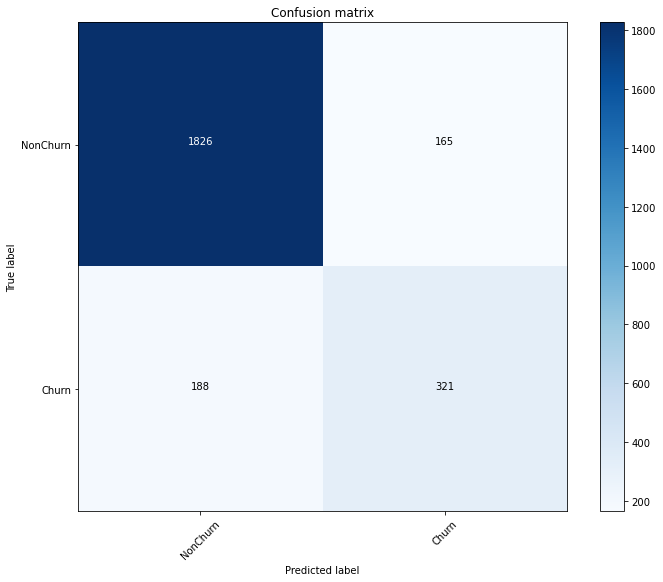

In [84]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### CatBoost оказался лучше

In [64]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state=42)),
]);

pipeline.fit(X_train, y_train);

#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
# res.loc[len(res)] = [clf, fscore[ix], precision[ix], recall[ix]]

Learning rate set to 0.024355
0:	learn: 0.6726753	total: 4.76ms	remaining: 4.75s
1:	learn: 0.6548724	total: 9.38ms	remaining: 4.68s
2:	learn: 0.6406350	total: 13.6ms	remaining: 4.53s
3:	learn: 0.6238459	total: 18.6ms	remaining: 4.63s
4:	learn: 0.6081549	total: 23.5ms	remaining: 4.68s
5:	learn: 0.5929898	total: 28.3ms	remaining: 4.68s
6:	learn: 0.5788184	total: 34.9ms	remaining: 4.95s
7:	learn: 0.5660495	total: 40ms	remaining: 4.96s
8:	learn: 0.5556642	total: 45.5ms	remaining: 5.01s
9:	learn: 0.5441880	total: 50.6ms	remaining: 5.01s
10:	learn: 0.5348572	total: 55.7ms	remaining: 5s
11:	learn: 0.5257381	total: 59.7ms	remaining: 4.91s
12:	learn: 0.5169543	total: 64.8ms	remaining: 4.92s
13:	learn: 0.5074631	total: 71ms	remaining: 5s
14:	learn: 0.4985761	total: 76.2ms	remaining: 5s
15:	learn: 0.4914582	total: 81ms	remaining: 4.98s
16:	learn: 0.4826288	total: 86ms	remaining: 4.97s
17:	learn: 0.4757425	total: 90.7ms	remaining: 4.95s
18:	learn: 0.4680409	total: 96.2ms	remaining: 4.97s
19:	learn

192:	learn: 0.3146412	total: 902ms	remaining: 3.77s
193:	learn: 0.3144819	total: 906ms	remaining: 3.76s
194:	learn: 0.3143049	total: 910ms	remaining: 3.76s
195:	learn: 0.3142286	total: 914ms	remaining: 3.75s
196:	learn: 0.3140282	total: 919ms	remaining: 3.75s
197:	learn: 0.3138784	total: 924ms	remaining: 3.74s
198:	learn: 0.3137244	total: 929ms	remaining: 3.74s
199:	learn: 0.3136178	total: 933ms	remaining: 3.73s
200:	learn: 0.3134651	total: 938ms	remaining: 3.73s
201:	learn: 0.3133604	total: 943ms	remaining: 3.73s
202:	learn: 0.3131309	total: 947ms	remaining: 3.72s
203:	learn: 0.3130178	total: 951ms	remaining: 3.71s
204:	learn: 0.3128292	total: 955ms	remaining: 3.7s
205:	learn: 0.3125498	total: 959ms	remaining: 3.7s
206:	learn: 0.3124080	total: 963ms	remaining: 3.69s
207:	learn: 0.3123190	total: 983ms	remaining: 3.74s
208:	learn: 0.3120617	total: 987ms	remaining: 3.74s
209:	learn: 0.3119706	total: 991ms	remaining: 3.73s
210:	learn: 0.3118659	total: 995ms	remaining: 3.72s
211:	learn: 0.

395:	learn: 0.2888821	total: 1.81s	remaining: 2.76s
396:	learn: 0.2887154	total: 1.82s	remaining: 2.76s
397:	learn: 0.2885832	total: 1.82s	remaining: 2.75s
398:	learn: 0.2885028	total: 1.83s	remaining: 2.75s
399:	learn: 0.2883838	total: 1.83s	remaining: 2.75s
400:	learn: 0.2882539	total: 1.83s	remaining: 2.74s
401:	learn: 0.2880947	total: 1.84s	remaining: 2.74s
402:	learn: 0.2879765	total: 1.84s	remaining: 2.73s
403:	learn: 0.2878836	total: 1.85s	remaining: 2.73s
404:	learn: 0.2877630	total: 1.85s	remaining: 2.72s
405:	learn: 0.2876166	total: 1.86s	remaining: 2.71s
406:	learn: 0.2874938	total: 1.86s	remaining: 2.71s
407:	learn: 0.2874008	total: 1.86s	remaining: 2.7s
408:	learn: 0.2872411	total: 1.87s	remaining: 2.7s
409:	learn: 0.2871418	total: 1.87s	remaining: 2.69s
410:	learn: 0.2870198	total: 1.88s	remaining: 2.69s
411:	learn: 0.2869354	total: 1.88s	remaining: 2.68s
412:	learn: 0.2868057	total: 1.88s	remaining: 2.68s
413:	learn: 0.2866392	total: 1.89s	remaining: 2.67s
414:	learn: 0.

595:	learn: 0.2661523	total: 2.72s	remaining: 1.84s
596:	learn: 0.2660421	total: 2.73s	remaining: 1.84s
597:	learn: 0.2659666	total: 2.73s	remaining: 1.83s
598:	learn: 0.2658557	total: 2.73s	remaining: 1.83s
599:	learn: 0.2657675	total: 2.74s	remaining: 1.83s
600:	learn: 0.2656665	total: 2.75s	remaining: 1.82s
601:	learn: 0.2655607	total: 2.75s	remaining: 1.82s
602:	learn: 0.2655023	total: 2.75s	remaining: 1.81s
603:	learn: 0.2653779	total: 2.76s	remaining: 1.81s
604:	learn: 0.2652995	total: 2.76s	remaining: 1.8s
605:	learn: 0.2652078	total: 2.77s	remaining: 1.8s
606:	learn: 0.2650862	total: 2.78s	remaining: 1.8s
607:	learn: 0.2649963	total: 2.78s	remaining: 1.79s
608:	learn: 0.2648904	total: 2.79s	remaining: 1.79s
609:	learn: 0.2648238	total: 2.79s	remaining: 1.78s
610:	learn: 0.2647095	total: 2.79s	remaining: 1.78s
611:	learn: 0.2645745	total: 2.8s	remaining: 1.77s
612:	learn: 0.2644554	total: 2.8s	remaining: 1.77s
613:	learn: 0.2643384	total: 2.81s	remaining: 1.76s
614:	learn: 0.264

759:	learn: 0.2504346	total: 3.44s	remaining: 1.09s
760:	learn: 0.2503913	total: 3.45s	remaining: 1.08s
761:	learn: 0.2503316	total: 3.45s	remaining: 1.08s
762:	learn: 0.2502871	total: 3.46s	remaining: 1.07s
763:	learn: 0.2501835	total: 3.47s	remaining: 1.07s
764:	learn: 0.2500594	total: 3.47s	remaining: 1.07s
765:	learn: 0.2499587	total: 3.48s	remaining: 1.06s
766:	learn: 0.2499149	total: 3.48s	remaining: 1.06s
767:	learn: 0.2498166	total: 3.49s	remaining: 1.05s
768:	learn: 0.2497629	total: 3.49s	remaining: 1.05s
769:	learn: 0.2496902	total: 3.5s	remaining: 1.04s
770:	learn: 0.2496257	total: 3.5s	remaining: 1.04s
771:	learn: 0.2495410	total: 3.5s	remaining: 1.03s
772:	learn: 0.2494596	total: 3.51s	remaining: 1.03s
773:	learn: 0.2493578	total: 3.51s	remaining: 1.03s
774:	learn: 0.2492805	total: 3.52s	remaining: 1.02s
775:	learn: 0.2491851	total: 3.52s	remaining: 1.02s
776:	learn: 0.2490880	total: 3.53s	remaining: 1.01s
777:	learn: 0.2490090	total: 3.53s	remaining: 1.01s
778:	learn: 0.2

923:	learn: 0.2369621	total: 4.17s	remaining: 343ms
924:	learn: 0.2369244	total: 4.18s	remaining: 339ms
925:	learn: 0.2368362	total: 4.18s	remaining: 334ms
926:	learn: 0.2367682	total: 4.19s	remaining: 330ms
927:	learn: 0.2366766	total: 4.19s	remaining: 325ms
928:	learn: 0.2365845	total: 4.19s	remaining: 321ms
929:	learn: 0.2365169	total: 4.2s	remaining: 316ms
930:	learn: 0.2364395	total: 4.2s	remaining: 311ms
931:	learn: 0.2363598	total: 4.21s	remaining: 307ms
932:	learn: 0.2362803	total: 4.21s	remaining: 302ms
933:	learn: 0.2362154	total: 4.21s	remaining: 298ms
934:	learn: 0.2361600	total: 4.23s	remaining: 294ms
935:	learn: 0.2360771	total: 4.23s	remaining: 289ms
936:	learn: 0.2359805	total: 4.23s	remaining: 285ms
937:	learn: 0.2359117	total: 4.24s	remaining: 280ms
938:	learn: 0.2358582	total: 4.24s	remaining: 276ms
939:	learn: 0.2357405	total: 4.25s	remaining: 271ms
940:	learn: 0.2356708	total: 4.25s	remaining: 266ms
941:	learn: 0.2356142	total: 4.25s	remaining: 262ms
942:	learn: 0.

In [67]:
params={'classifier__depth':[6, 10],
        'classifier__l2_leaf_reg':[2, 4, 6]
        }

In [68]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train);
search.best_params_

0:	learn: 0.6688071	total: 3.63ms	remaining: 3.63s
1:	learn: 0.6503858	total: 7.06ms	remaining: 3.52s
2:	learn: 0.6290967	total: 10.9ms	remaining: 3.61s
3:	learn: 0.6105407	total: 14.1ms	remaining: 3.51s
4:	learn: 0.5921353	total: 17.7ms	remaining: 3.53s
5:	learn: 0.5759499	total: 21.3ms	remaining: 3.54s
6:	learn: 0.5606681	total: 25ms	remaining: 3.55s
7:	learn: 0.5448642	total: 28.8ms	remaining: 3.57s
8:	learn: 0.5310288	total: 32.4ms	remaining: 3.57s
9:	learn: 0.5214452	total: 35.7ms	remaining: 3.53s
10:	learn: 0.5116463	total: 38.9ms	remaining: 3.5s
11:	learn: 0.4996571	total: 42.9ms	remaining: 3.53s
12:	learn: 0.4914308	total: 46.6ms	remaining: 3.54s
13:	learn: 0.4823762	total: 50.4ms	remaining: 3.55s
14:	learn: 0.4732714	total: 54ms	remaining: 3.54s
15:	learn: 0.4660951	total: 59.1ms	remaining: 3.63s
16:	learn: 0.4604772	total: 65.2ms	remaining: 3.77s
17:	learn: 0.4531628	total: 69.9ms	remaining: 3.81s
18:	learn: 0.4458624	total: 75.3ms	remaining: 3.89s
19:	learn: 0.4403880	total:

177:	learn: 0.3078649	total: 730ms	remaining: 3.37s
178:	learn: 0.3076628	total: 741ms	remaining: 3.4s
179:	learn: 0.3074876	total: 745ms	remaining: 3.39s
180:	learn: 0.3073018	total: 748ms	remaining: 3.38s
181:	learn: 0.3070093	total: 752ms	remaining: 3.38s
182:	learn: 0.3068589	total: 756ms	remaining: 3.37s
183:	learn: 0.3066674	total: 760ms	remaining: 3.37s
184:	learn: 0.3064998	total: 763ms	remaining: 3.36s
185:	learn: 0.3063886	total: 767ms	remaining: 3.36s
186:	learn: 0.3061916	total: 771ms	remaining: 3.35s
187:	learn: 0.3060006	total: 775ms	remaining: 3.35s
188:	learn: 0.3056943	total: 778ms	remaining: 3.34s
189:	learn: 0.3054638	total: 782ms	remaining: 3.33s
190:	learn: 0.3052179	total: 786ms	remaining: 3.33s
191:	learn: 0.3050279	total: 790ms	remaining: 3.32s
192:	learn: 0.3047724	total: 793ms	remaining: 3.32s
193:	learn: 0.3045855	total: 797ms	remaining: 3.31s
194:	learn: 0.3044286	total: 802ms	remaining: 3.31s
195:	learn: 0.3042842	total: 806ms	remaining: 3.31s
196:	learn: 0

354:	learn: 0.2754569	total: 1.45s	remaining: 2.64s
355:	learn: 0.2753620	total: 1.46s	remaining: 2.64s
356:	learn: 0.2751831	total: 1.46s	remaining: 2.63s
357:	learn: 0.2750198	total: 1.47s	remaining: 2.63s
358:	learn: 0.2747566	total: 1.47s	remaining: 2.62s
359:	learn: 0.2745249	total: 1.47s	remaining: 2.62s
360:	learn: 0.2743119	total: 1.48s	remaining: 2.62s
361:	learn: 0.2741450	total: 1.48s	remaining: 2.61s
362:	learn: 0.2740134	total: 1.49s	remaining: 2.61s
363:	learn: 0.2738514	total: 1.49s	remaining: 2.6s
364:	learn: 0.2737093	total: 1.49s	remaining: 2.6s
365:	learn: 0.2734928	total: 1.5s	remaining: 2.59s
366:	learn: 0.2732875	total: 1.5s	remaining: 2.59s
367:	learn: 0.2731073	total: 1.52s	remaining: 2.61s
368:	learn: 0.2729504	total: 1.52s	remaining: 2.6s
369:	learn: 0.2728115	total: 1.52s	remaining: 2.6s
370:	learn: 0.2726881	total: 1.53s	remaining: 2.59s
371:	learn: 0.2725622	total: 1.53s	remaining: 2.59s
372:	learn: 0.2723888	total: 1.54s	remaining: 2.58s
373:	learn: 0.2721

520:	learn: 0.2493415	total: 2.18s	remaining: 2.01s
521:	learn: 0.2492061	total: 2.19s	remaining: 2s
522:	learn: 0.2490275	total: 2.19s	remaining: 2s
523:	learn: 0.2488452	total: 2.2s	remaining: 2s
524:	learn: 0.2487122	total: 2.2s	remaining: 1.99s
525:	learn: 0.2485960	total: 2.21s	remaining: 1.99s
526:	learn: 0.2484225	total: 2.21s	remaining: 1.98s
527:	learn: 0.2482618	total: 2.21s	remaining: 1.98s
528:	learn: 0.2481119	total: 2.22s	remaining: 1.98s
529:	learn: 0.2479034	total: 2.22s	remaining: 1.97s
530:	learn: 0.2477531	total: 2.23s	remaining: 1.97s
531:	learn: 0.2476747	total: 2.23s	remaining: 1.96s
532:	learn: 0.2475354	total: 2.23s	remaining: 1.96s
533:	learn: 0.2473591	total: 2.24s	remaining: 1.95s
534:	learn: 0.2471960	total: 2.24s	remaining: 1.95s
535:	learn: 0.2471028	total: 2.25s	remaining: 1.94s
536:	learn: 0.2469904	total: 2.25s	remaining: 1.94s
537:	learn: 0.2469029	total: 2.25s	remaining: 1.94s
538:	learn: 0.2467062	total: 2.26s	remaining: 1.93s
539:	learn: 0.2465216	t

682:	learn: 0.2277831	total: 2.91s	remaining: 1.35s
683:	learn: 0.2276521	total: 2.91s	remaining: 1.34s
684:	learn: 0.2275222	total: 2.92s	remaining: 1.34s
685:	learn: 0.2273733	total: 2.92s	remaining: 1.34s
686:	learn: 0.2273142	total: 2.92s	remaining: 1.33s
687:	learn: 0.2271530	total: 2.93s	remaining: 1.33s
688:	learn: 0.2270293	total: 2.93s	remaining: 1.32s
689:	learn: 0.2269370	total: 2.94s	remaining: 1.32s
690:	learn: 0.2268121	total: 2.94s	remaining: 1.31s
691:	learn: 0.2267401	total: 2.94s	remaining: 1.31s
692:	learn: 0.2266239	total: 2.95s	remaining: 1.3s
693:	learn: 0.2265334	total: 2.95s	remaining: 1.3s
694:	learn: 0.2263892	total: 2.96s	remaining: 1.3s
695:	learn: 0.2262537	total: 2.96s	remaining: 1.29s
696:	learn: 0.2261894	total: 2.96s	remaining: 1.29s
697:	learn: 0.2260293	total: 2.97s	remaining: 1.28s
698:	learn: 0.2259011	total: 2.97s	remaining: 1.28s
699:	learn: 0.2257298	total: 2.98s	remaining: 1.27s
700:	learn: 0.2256525	total: 2.98s	remaining: 1.27s
701:	learn: 0.2

849:	learn: 0.2089697	total: 3.63s	remaining: 641ms
850:	learn: 0.2088248	total: 3.64s	remaining: 637ms
851:	learn: 0.2087665	total: 3.64s	remaining: 632ms
852:	learn: 0.2086782	total: 3.64s	remaining: 628ms
853:	learn: 0.2086072	total: 3.65s	remaining: 624ms
854:	learn: 0.2085138	total: 3.65s	remaining: 619ms
855:	learn: 0.2084168	total: 3.66s	remaining: 615ms
856:	learn: 0.2083176	total: 3.66s	remaining: 611ms
857:	learn: 0.2082365	total: 3.66s	remaining: 606ms
858:	learn: 0.2081128	total: 3.68s	remaining: 605ms
859:	learn: 0.2080045	total: 3.69s	remaining: 600ms
860:	learn: 0.2078958	total: 3.69s	remaining: 596ms
861:	learn: 0.2077815	total: 3.69s	remaining: 592ms
862:	learn: 0.2076740	total: 3.7s	remaining: 587ms
863:	learn: 0.2075830	total: 3.71s	remaining: 585ms
864:	learn: 0.2074968	total: 3.72s	remaining: 581ms
865:	learn: 0.2074149	total: 3.72s	remaining: 576ms
866:	learn: 0.2073040	total: 3.73s	remaining: 572ms
867:	learn: 0.2072217	total: 3.73s	remaining: 568ms
868:	learn: 0

46:	learn: 0.3640029	total: 182ms	remaining: 3.69s
47:	learn: 0.3621601	total: 186ms	remaining: 3.69s
48:	learn: 0.3606816	total: 192ms	remaining: 3.72s
49:	learn: 0.3599011	total: 197ms	remaining: 3.73s
50:	learn: 0.3586970	total: 201ms	remaining: 3.74s
51:	learn: 0.3574215	total: 205ms	remaining: 3.74s
52:	learn: 0.3566723	total: 209ms	remaining: 3.74s
53:	learn: 0.3553003	total: 214ms	remaining: 3.75s
54:	learn: 0.3544548	total: 218ms	remaining: 3.75s
55:	learn: 0.3534221	total: 224ms	remaining: 3.78s
56:	learn: 0.3525996	total: 229ms	remaining: 3.79s
57:	learn: 0.3515784	total: 233ms	remaining: 3.78s
58:	learn: 0.3507771	total: 237ms	remaining: 3.77s
59:	learn: 0.3497479	total: 240ms	remaining: 3.77s
60:	learn: 0.3490914	total: 244ms	remaining: 3.76s
61:	learn: 0.3483067	total: 248ms	remaining: 3.75s
62:	learn: 0.3479196	total: 251ms	remaining: 3.73s
63:	learn: 0.3467696	total: 255ms	remaining: 3.73s
64:	learn: 0.3459811	total: 260ms	remaining: 3.74s
65:	learn: 0.3450233	total: 264

231:	learn: 0.2977027	total: 905ms	remaining: 3s
232:	learn: 0.2975796	total: 918ms	remaining: 3.02s
233:	learn: 0.2973563	total: 922ms	remaining: 3.02s
234:	learn: 0.2971368	total: 926ms	remaining: 3.01s
235:	learn: 0.2969474	total: 930ms	remaining: 3.01s
236:	learn: 0.2967588	total: 934ms	remaining: 3s
237:	learn: 0.2965911	total: 937ms	remaining: 3s
238:	learn: 0.2964377	total: 947ms	remaining: 3.02s
239:	learn: 0.2963355	total: 951ms	remaining: 3.01s
240:	learn: 0.2961951	total: 954ms	remaining: 3s
241:	learn: 0.2959131	total: 958ms	remaining: 3s
242:	learn: 0.2957022	total: 962ms	remaining: 3s
243:	learn: 0.2954949	total: 966ms	remaining: 2.99s
244:	learn: 0.2953157	total: 969ms	remaining: 2.99s
245:	learn: 0.2951486	total: 973ms	remaining: 2.98s
246:	learn: 0.2949881	total: 978ms	remaining: 2.98s
247:	learn: 0.2948674	total: 982ms	remaining: 2.98s
248:	learn: 0.2947516	total: 986ms	remaining: 2.97s
249:	learn: 0.2946423	total: 990ms	remaining: 2.97s
250:	learn: 0.2944517	total: 9

401:	learn: 0.2680409	total: 1.63s	remaining: 2.42s
402:	learn: 0.2678092	total: 1.63s	remaining: 2.42s
403:	learn: 0.2675666	total: 1.64s	remaining: 2.42s
404:	learn: 0.2673973	total: 1.64s	remaining: 2.41s
405:	learn: 0.2672593	total: 1.65s	remaining: 2.41s
406:	learn: 0.2670741	total: 1.65s	remaining: 2.4s
407:	learn: 0.2668568	total: 1.65s	remaining: 2.4s
408:	learn: 0.2667215	total: 1.66s	remaining: 2.4s
409:	learn: 0.2665027	total: 1.66s	remaining: 2.39s
410:	learn: 0.2663374	total: 1.67s	remaining: 2.4s
411:	learn: 0.2662240	total: 1.68s	remaining: 2.4s
412:	learn: 0.2660326	total: 1.68s	remaining: 2.39s
413:	learn: 0.2659326	total: 1.69s	remaining: 2.38s
414:	learn: 0.2658323	total: 1.69s	remaining: 2.38s
415:	learn: 0.2656540	total: 1.69s	remaining: 2.38s
416:	learn: 0.2655346	total: 1.7s	remaining: 2.37s
417:	learn: 0.2653595	total: 1.7s	remaining: 2.37s
418:	learn: 0.2651487	total: 1.7s	remaining: 2.36s
419:	learn: 0.2649516	total: 1.71s	remaining: 2.36s
420:	learn: 0.264808

577:	learn: 0.2416379	total: 2.36s	remaining: 1.72s
578:	learn: 0.2414768	total: 2.37s	remaining: 1.72s
579:	learn: 0.2413936	total: 2.37s	remaining: 1.72s
580:	learn: 0.2412820	total: 2.37s	remaining: 1.71s
581:	learn: 0.2411931	total: 2.38s	remaining: 1.71s
582:	learn: 0.2410400	total: 2.38s	remaining: 1.7s
583:	learn: 0.2409209	total: 2.39s	remaining: 1.7s
584:	learn: 0.2407308	total: 2.39s	remaining: 1.7s
585:	learn: 0.2405837	total: 2.39s	remaining: 1.69s
586:	learn: 0.2404939	total: 2.4s	remaining: 1.69s
587:	learn: 0.2403861	total: 2.4s	remaining: 1.68s
588:	learn: 0.2401839	total: 2.4s	remaining: 1.68s
589:	learn: 0.2400896	total: 2.41s	remaining: 1.67s
590:	learn: 0.2399556	total: 2.41s	remaining: 1.67s
591:	learn: 0.2397965	total: 2.42s	remaining: 1.67s
592:	learn: 0.2396153	total: 2.42s	remaining: 1.66s
593:	learn: 0.2394937	total: 2.42s	remaining: 1.66s
594:	learn: 0.2393793	total: 2.43s	remaining: 1.65s
595:	learn: 0.2392635	total: 2.43s	remaining: 1.65s
596:	learn: 0.2391

757:	learn: 0.2199840	total: 3.08s	remaining: 984ms
758:	learn: 0.2198809	total: 3.09s	remaining: 980ms
759:	learn: 0.2197514	total: 3.09s	remaining: 976ms
760:	learn: 0.2196166	total: 3.1s	remaining: 973ms
761:	learn: 0.2194297	total: 3.1s	remaining: 969ms
762:	learn: 0.2192690	total: 3.11s	remaining: 965ms
763:	learn: 0.2191550	total: 3.11s	remaining: 961ms
764:	learn: 0.2190981	total: 3.11s	remaining: 957ms
765:	learn: 0.2189586	total: 3.12s	remaining: 953ms
766:	learn: 0.2187870	total: 3.12s	remaining: 949ms
767:	learn: 0.2187077	total: 3.13s	remaining: 945ms
768:	learn: 0.2186410	total: 3.13s	remaining: 941ms
769:	learn: 0.2185337	total: 3.13s	remaining: 936ms
770:	learn: 0.2184584	total: 3.14s	remaining: 932ms
771:	learn: 0.2184098	total: 3.14s	remaining: 928ms
772:	learn: 0.2182772	total: 3.15s	remaining: 924ms
773:	learn: 0.2181673	total: 3.15s	remaining: 920ms
774:	learn: 0.2180278	total: 3.15s	remaining: 916ms
775:	learn: 0.2178880	total: 3.16s	remaining: 912ms
776:	learn: 0.

949:	learn: 0.1987512	total: 3.99s	remaining: 210ms
950:	learn: 0.1986242	total: 4s	remaining: 206ms
951:	learn: 0.1985325	total: 4s	remaining: 202ms
952:	learn: 0.1984109	total: 4s	remaining: 198ms
953:	learn: 0.1983239	total: 4.01s	remaining: 193ms
954:	learn: 0.1982302	total: 4.01s	remaining: 189ms
955:	learn: 0.1981273	total: 4.02s	remaining: 185ms
956:	learn: 0.1980108	total: 4.03s	remaining: 181ms
957:	learn: 0.1979647	total: 4.03s	remaining: 177ms
958:	learn: 0.1978840	total: 4.03s	remaining: 173ms
959:	learn: 0.1977408	total: 4.04s	remaining: 168ms
960:	learn: 0.1976329	total: 4.04s	remaining: 164ms
961:	learn: 0.1975536	total: 4.05s	remaining: 160ms
962:	learn: 0.1974613	total: 4.05s	remaining: 156ms
963:	learn: 0.1973842	total: 4.06s	remaining: 152ms
964:	learn: 0.1972691	total: 4.06s	remaining: 147ms
965:	learn: 0.1972020	total: 4.07s	remaining: 143ms
966:	learn: 0.1971492	total: 4.07s	remaining: 139ms
967:	learn: 0.1970438	total: 4.08s	remaining: 135ms
968:	learn: 0.1969623

132:	learn: 0.3141681	total: 555ms	remaining: 3.62s
133:	learn: 0.3138992	total: 568ms	remaining: 3.67s
134:	learn: 0.3137012	total: 574ms	remaining: 3.67s
135:	learn: 0.3133409	total: 578ms	remaining: 3.67s
136:	learn: 0.3130295	total: 582ms	remaining: 3.66s
137:	learn: 0.3127947	total: 585ms	remaining: 3.66s
138:	learn: 0.3125082	total: 589ms	remaining: 3.65s
139:	learn: 0.3122635	total: 593ms	remaining: 3.64s
140:	learn: 0.3120119	total: 597ms	remaining: 3.63s
141:	learn: 0.3118099	total: 600ms	remaining: 3.63s
142:	learn: 0.3117278	total: 603ms	remaining: 3.62s
143:	learn: 0.3115120	total: 607ms	remaining: 3.61s
144:	learn: 0.3114451	total: 610ms	remaining: 3.6s
145:	learn: 0.3111502	total: 614ms	remaining: 3.59s
146:	learn: 0.3108706	total: 618ms	remaining: 3.58s
147:	learn: 0.3106041	total: 621ms	remaining: 3.58s
148:	learn: 0.3103527	total: 625ms	remaining: 3.57s
149:	learn: 0.3099686	total: 629ms	remaining: 3.56s
150:	learn: 0.3096699	total: 632ms	remaining: 3.56s
151:	learn: 0

299:	learn: 0.2808579	total: 1.28s	remaining: 2.99s
300:	learn: 0.2807101	total: 1.28s	remaining: 2.98s
301:	learn: 0.2806260	total: 1.29s	remaining: 2.98s
302:	learn: 0.2805260	total: 1.29s	remaining: 2.97s
303:	learn: 0.2803207	total: 1.3s	remaining: 2.97s
304:	learn: 0.2801460	total: 1.3s	remaining: 2.96s
305:	learn: 0.2800022	total: 1.3s	remaining: 2.96s
306:	learn: 0.2797844	total: 1.31s	remaining: 2.95s
307:	learn: 0.2795767	total: 1.31s	remaining: 2.95s
308:	learn: 0.2794021	total: 1.32s	remaining: 2.94s
309:	learn: 0.2792132	total: 1.32s	remaining: 2.94s
310:	learn: 0.2789504	total: 1.32s	remaining: 2.93s
311:	learn: 0.2787090	total: 1.33s	remaining: 2.93s
312:	learn: 0.2785318	total: 1.33s	remaining: 2.92s
313:	learn: 0.2783081	total: 1.33s	remaining: 2.92s
314:	learn: 0.2781412	total: 1.34s	remaining: 2.91s
315:	learn: 0.2779980	total: 1.34s	remaining: 2.91s
316:	learn: 0.2778400	total: 1.35s	remaining: 2.9s
317:	learn: 0.2775924	total: 1.35s	remaining: 2.9s
318:	learn: 0.277

460:	learn: 0.2554807	total: 2s	remaining: 2.35s
461:	learn: 0.2553551	total: 2.01s	remaining: 2.34s
462:	learn: 0.2552429	total: 2.01s	remaining: 2.34s
463:	learn: 0.2550501	total: 2.02s	remaining: 2.33s
464:	learn: 0.2549003	total: 2.02s	remaining: 2.33s
465:	learn: 0.2547587	total: 2.03s	remaining: 2.32s
466:	learn: 0.2546370	total: 2.03s	remaining: 2.32s
467:	learn: 0.2545324	total: 2.03s	remaining: 2.31s
468:	learn: 0.2543542	total: 2.04s	remaining: 2.31s
469:	learn: 0.2542285	total: 2.04s	remaining: 2.3s
470:	learn: 0.2540955	total: 2.04s	remaining: 2.3s
471:	learn: 0.2539897	total: 2.05s	remaining: 2.29s
472:	learn: 0.2538221	total: 2.05s	remaining: 2.29s
473:	learn: 0.2536631	total: 2.06s	remaining: 2.28s
474:	learn: 0.2535511	total: 2.06s	remaining: 2.28s
475:	learn: 0.2534135	total: 2.06s	remaining: 2.27s
476:	learn: 0.2532666	total: 2.07s	remaining: 2.27s
477:	learn: 0.2531302	total: 2.07s	remaining: 2.26s
478:	learn: 0.2530300	total: 2.08s	remaining: 2.26s
479:	learn: 0.252

636:	learn: 0.2314715	total: 2.73s	remaining: 1.56s
637:	learn: 0.2313784	total: 2.73s	remaining: 1.55s
638:	learn: 0.2313078	total: 2.74s	remaining: 1.55s
639:	learn: 0.2312195	total: 2.74s	remaining: 1.54s
640:	learn: 0.2310609	total: 2.75s	remaining: 1.54s
641:	learn: 0.2309441	total: 2.75s	remaining: 1.53s
642:	learn: 0.2308016	total: 2.75s	remaining: 1.53s
643:	learn: 0.2307564	total: 2.76s	remaining: 1.52s
644:	learn: 0.2305790	total: 2.76s	remaining: 1.52s
645:	learn: 0.2304363	total: 2.77s	remaining: 1.51s
646:	learn: 0.2302551	total: 2.77s	remaining: 1.51s
647:	learn: 0.2301893	total: 2.77s	remaining: 1.51s
648:	learn: 0.2300285	total: 2.78s	remaining: 1.5s
649:	learn: 0.2298992	total: 2.78s	remaining: 1.5s
650:	learn: 0.2298153	total: 2.78s	remaining: 1.49s
651:	learn: 0.2297278	total: 2.79s	remaining: 1.49s
652:	learn: 0.2295653	total: 2.79s	remaining: 1.48s
653:	learn: 0.2294532	total: 2.79s	remaining: 1.48s
654:	learn: 0.2293710	total: 2.8s	remaining: 1.47s
655:	learn: 0.2

800:	learn: 0.2134697	total: 3.46s	remaining: 861ms
801:	learn: 0.2133319	total: 3.47s	remaining: 856ms
802:	learn: 0.2132222	total: 3.47s	remaining: 852ms
803:	learn: 0.2131260	total: 3.48s	remaining: 848ms
804:	learn: 0.2129835	total: 3.48s	remaining: 843ms
805:	learn: 0.2128860	total: 3.48s	remaining: 839ms
806:	learn: 0.2127701	total: 3.49s	remaining: 834ms
807:	learn: 0.2126159	total: 3.49s	remaining: 830ms
808:	learn: 0.2125280	total: 3.5s	remaining: 826ms
809:	learn: 0.2124344	total: 3.5s	remaining: 821ms
810:	learn: 0.2123110	total: 3.5s	remaining: 817ms
811:	learn: 0.2121988	total: 3.51s	remaining: 813ms
812:	learn: 0.2120957	total: 3.51s	remaining: 808ms
813:	learn: 0.2120041	total: 3.52s	remaining: 804ms
814:	learn: 0.2119308	total: 3.52s	remaining: 799ms
815:	learn: 0.2117755	total: 3.52s	remaining: 795ms
816:	learn: 0.2117051	total: 3.53s	remaining: 791ms
817:	learn: 0.2115762	total: 3.53s	remaining: 786ms
818:	learn: 0.2114868	total: 3.54s	remaining: 782ms
819:	learn: 0.2

960:	learn: 0.1973936	total: 4.18s	remaining: 170ms
961:	learn: 0.1972427	total: 4.19s	remaining: 165ms
962:	learn: 0.1971927	total: 4.19s	remaining: 161ms
963:	learn: 0.1971255	total: 4.2s	remaining: 157ms
964:	learn: 0.1970285	total: 4.2s	remaining: 152ms
965:	learn: 0.1969058	total: 4.21s	remaining: 148ms
966:	learn: 0.1967792	total: 4.22s	remaining: 144ms
967:	learn: 0.1967007	total: 4.22s	remaining: 140ms
968:	learn: 0.1965901	total: 4.22s	remaining: 135ms
969:	learn: 0.1964916	total: 4.23s	remaining: 131ms
970:	learn: 0.1963741	total: 4.23s	remaining: 126ms
971:	learn: 0.1962903	total: 4.24s	remaining: 122ms
972:	learn: 0.1961582	total: 4.24s	remaining: 118ms
973:	learn: 0.1960666	total: 4.25s	remaining: 113ms
974:	learn: 0.1959517	total: 4.25s	remaining: 109ms
975:	learn: 0.1958253	total: 4.25s	remaining: 105ms
976:	learn: 0.1957672	total: 4.26s	remaining: 100ms
977:	learn: 0.1956650	total: 4.26s	remaining: 95.9ms
978:	learn: 0.1955639	total: 4.27s	remaining: 91.6ms
979:	learn: 

132:	learn: 0.3163456	total: 582ms	remaining: 3.8s
133:	learn: 0.3160428	total: 587ms	remaining: 3.79s
134:	learn: 0.3158185	total: 592ms	remaining: 3.79s
135:	learn: 0.3155683	total: 596ms	remaining: 3.79s
136:	learn: 0.3152617	total: 602ms	remaining: 3.79s
137:	learn: 0.3149188	total: 606ms	remaining: 3.78s
138:	learn: 0.3146806	total: 610ms	remaining: 3.78s
139:	learn: 0.3146530	total: 613ms	remaining: 3.77s
140:	learn: 0.3144405	total: 617ms	remaining: 3.76s
141:	learn: 0.3142172	total: 622ms	remaining: 3.76s
142:	learn: 0.3139600	total: 626ms	remaining: 3.75s
143:	learn: 0.3138967	total: 644ms	remaining: 3.83s
144:	learn: 0.3137645	total: 649ms	remaining: 3.83s
145:	learn: 0.3137001	total: 652ms	remaining: 3.82s
146:	learn: 0.3134106	total: 657ms	remaining: 3.81s
147:	learn: 0.3131595	total: 661ms	remaining: 3.8s
148:	learn: 0.3129789	total: 666ms	remaining: 3.8s
149:	learn: 0.3127513	total: 671ms	remaining: 3.8s
150:	learn: 0.3123810	total: 675ms	remaining: 3.8s
151:	learn: 0.312

331:	learn: 0.2790774	total: 1.49s	remaining: 3s
332:	learn: 0.2789685	total: 1.5s	remaining: 3s
333:	learn: 0.2788540	total: 1.5s	remaining: 2.99s
334:	learn: 0.2786468	total: 1.5s	remaining: 2.99s
335:	learn: 0.2784559	total: 1.51s	remaining: 2.98s
336:	learn: 0.2782324	total: 1.51s	remaining: 2.98s
337:	learn: 0.2779928	total: 1.52s	remaining: 2.97s
338:	learn: 0.2778389	total: 1.52s	remaining: 2.97s
339:	learn: 0.2777243	total: 1.54s	remaining: 2.99s
340:	learn: 0.2775123	total: 1.54s	remaining: 2.98s
341:	learn: 0.2773046	total: 1.55s	remaining: 2.98s
342:	learn: 0.2771610	total: 1.55s	remaining: 2.97s
343:	learn: 0.2769753	total: 1.55s	remaining: 2.97s
344:	learn: 0.2768208	total: 1.56s	remaining: 2.96s
345:	learn: 0.2766026	total: 1.56s	remaining: 2.95s
346:	learn: 0.2764335	total: 1.57s	remaining: 2.95s
347:	learn: 0.2763196	total: 1.57s	remaining: 2.94s
348:	learn: 0.2762049	total: 1.57s	remaining: 2.94s
349:	learn: 0.2760487	total: 1.58s	remaining: 2.93s
350:	learn: 0.2758831

494:	learn: 0.2528636	total: 2.22s	remaining: 2.26s
495:	learn: 0.2527680	total: 2.22s	remaining: 2.26s
496:	learn: 0.2526280	total: 2.23s	remaining: 2.25s
497:	learn: 0.2524649	total: 2.23s	remaining: 2.25s
498:	learn: 0.2522853	total: 2.24s	remaining: 2.25s
499:	learn: 0.2520902	total: 2.24s	remaining: 2.24s
500:	learn: 0.2519423	total: 2.24s	remaining: 2.23s
501:	learn: 0.2518265	total: 2.25s	remaining: 2.23s
502:	learn: 0.2516874	total: 2.25s	remaining: 2.22s
503:	learn: 0.2515396	total: 2.25s	remaining: 2.22s
504:	learn: 0.2514140	total: 2.26s	remaining: 2.21s
505:	learn: 0.2512097	total: 2.26s	remaining: 2.21s
506:	learn: 0.2510826	total: 2.27s	remaining: 2.2s
507:	learn: 0.2509542	total: 2.27s	remaining: 2.2s
508:	learn: 0.2507955	total: 2.27s	remaining: 2.19s
509:	learn: 0.2506758	total: 2.28s	remaining: 2.19s
510:	learn: 0.2505040	total: 2.28s	remaining: 2.18s
511:	learn: 0.2504029	total: 2.28s	remaining: 2.18s
512:	learn: 0.2502326	total: 2.3s	remaining: 2.18s
513:	learn: 0.2

665:	learn: 0.2290959	total: 2.94s	remaining: 1.48s
666:	learn: 0.2289808	total: 2.95s	remaining: 1.47s
667:	learn: 0.2289236	total: 2.95s	remaining: 1.47s
668:	learn: 0.2287484	total: 2.96s	remaining: 1.46s
669:	learn: 0.2286171	total: 2.96s	remaining: 1.46s
670:	learn: 0.2285254	total: 2.96s	remaining: 1.45s
671:	learn: 0.2283420	total: 2.97s	remaining: 1.45s
672:	learn: 0.2281981	total: 2.97s	remaining: 1.44s
673:	learn: 0.2280066	total: 2.98s	remaining: 1.44s
674:	learn: 0.2279517	total: 2.98s	remaining: 1.43s
675:	learn: 0.2278404	total: 2.98s	remaining: 1.43s
676:	learn: 0.2277263	total: 2.99s	remaining: 1.43s
677:	learn: 0.2275614	total: 2.99s	remaining: 1.42s
678:	learn: 0.2274693	total: 2.99s	remaining: 1.42s
679:	learn: 0.2272984	total: 3s	remaining: 1.41s
680:	learn: 0.2272047	total: 3s	remaining: 1.41s
681:	learn: 0.2271048	total: 3s	remaining: 1.4s
682:	learn: 0.2269951	total: 3.01s	remaining: 1.4s
683:	learn: 0.2268475	total: 3.01s	remaining: 1.39s
684:	learn: 0.2267672	t

840:	learn: 0.2087081	total: 3.67s	remaining: 694ms
841:	learn: 0.2085808	total: 3.67s	remaining: 690ms
842:	learn: 0.2084964	total: 3.68s	remaining: 685ms
843:	learn: 0.2084022	total: 3.68s	remaining: 681ms
844:	learn: 0.2082782	total: 3.69s	remaining: 676ms
845:	learn: 0.2081818	total: 3.69s	remaining: 672ms
846:	learn: 0.2080609	total: 3.69s	remaining: 668ms
847:	learn: 0.2079935	total: 3.7s	remaining: 663ms
848:	learn: 0.2078779	total: 3.7s	remaining: 659ms
849:	learn: 0.2078079	total: 3.71s	remaining: 654ms
850:	learn: 0.2076588	total: 3.71s	remaining: 650ms
851:	learn: 0.2075854	total: 3.71s	remaining: 645ms
852:	learn: 0.2075165	total: 3.72s	remaining: 641ms
853:	learn: 0.2074200	total: 3.72s	remaining: 636ms
854:	learn: 0.2073275	total: 3.73s	remaining: 632ms
855:	learn: 0.2071879	total: 3.73s	remaining: 628ms
856:	learn: 0.2071055	total: 3.73s	remaining: 623ms
857:	learn: 0.2070422	total: 3.74s	remaining: 619ms
858:	learn: 0.2069143	total: 3.74s	remaining: 614ms
859:	learn: 0.

0:	learn: 0.6725377	total: 3.52ms	remaining: 3.52s
1:	learn: 0.6503248	total: 6.76ms	remaining: 3.37s
2:	learn: 0.6285523	total: 10.3ms	remaining: 3.43s
3:	learn: 0.6097040	total: 13.6ms	remaining: 3.38s
4:	learn: 0.5905398	total: 17.2ms	remaining: 3.43s
5:	learn: 0.5742160	total: 21.3ms	remaining: 3.54s
6:	learn: 0.5586224	total: 25.6ms	remaining: 3.63s
7:	learn: 0.5422138	total: 29.4ms	remaining: 3.65s
8:	learn: 0.5280183	total: 33.1ms	remaining: 3.65s
9:	learn: 0.5180333	total: 38.5ms	remaining: 3.81s
10:	learn: 0.5068887	total: 42.2ms	remaining: 3.79s
11:	learn: 0.4973598	total: 46.4ms	remaining: 3.82s
12:	learn: 0.4889211	total: 50.5ms	remaining: 3.83s
13:	learn: 0.4819945	total: 54.2ms	remaining: 3.82s
14:	learn: 0.4725754	total: 58.3ms	remaining: 3.83s
15:	learn: 0.4660635	total: 62.9ms	remaining: 3.87s
16:	learn: 0.4583004	total: 67.4ms	remaining: 3.9s
17:	learn: 0.4497825	total: 71.4ms	remaining: 3.89s
18:	learn: 0.4431743	total: 75.2ms	remaining: 3.88s
19:	learn: 0.4361618	to

177:	learn: 0.3021705	total: 729ms	remaining: 3.37s
178:	learn: 0.3020670	total: 733ms	remaining: 3.36s
179:	learn: 0.3017803	total: 737ms	remaining: 3.36s
180:	learn: 0.3015464	total: 742ms	remaining: 3.36s
181:	learn: 0.3014516	total: 746ms	remaining: 3.35s
182:	learn: 0.3011549	total: 750ms	remaining: 3.35s
183:	learn: 0.3010471	total: 755ms	remaining: 3.35s
184:	learn: 0.3009181	total: 759ms	remaining: 3.34s
185:	learn: 0.3007762	total: 763ms	remaining: 3.34s
186:	learn: 0.3005260	total: 766ms	remaining: 3.33s
187:	learn: 0.3003207	total: 770ms	remaining: 3.33s
188:	learn: 0.3001452	total: 774ms	remaining: 3.32s
189:	learn: 0.3000101	total: 778ms	remaining: 3.32s
190:	learn: 0.2998430	total: 782ms	remaining: 3.31s
191:	learn: 0.2996603	total: 786ms	remaining: 3.31s
192:	learn: 0.2994353	total: 790ms	remaining: 3.3s
193:	learn: 0.2991822	total: 795ms	remaining: 3.3s
194:	learn: 0.2988861	total: 799ms	remaining: 3.3s
195:	learn: 0.2986338	total: 803ms	remaining: 3.29s
196:	learn: 0.2

352:	learn: 0.2715014	total: 1.46s	remaining: 2.67s
353:	learn: 0.2712802	total: 1.46s	remaining: 2.66s
354:	learn: 0.2711280	total: 1.46s	remaining: 2.66s
355:	learn: 0.2710237	total: 1.47s	remaining: 2.65s
356:	learn: 0.2707951	total: 1.47s	remaining: 2.65s
357:	learn: 0.2705879	total: 1.48s	remaining: 2.65s
358:	learn: 0.2704515	total: 1.48s	remaining: 2.64s
359:	learn: 0.2703099	total: 1.48s	remaining: 2.64s
360:	learn: 0.2701606	total: 1.49s	remaining: 2.63s
361:	learn: 0.2700255	total: 1.49s	remaining: 2.63s
362:	learn: 0.2698399	total: 1.5s	remaining: 2.62s
363:	learn: 0.2696714	total: 1.5s	remaining: 2.62s
364:	learn: 0.2694981	total: 1.5s	remaining: 2.62s
365:	learn: 0.2693541	total: 1.51s	remaining: 2.61s
366:	learn: 0.2692321	total: 1.51s	remaining: 2.61s
367:	learn: 0.2690972	total: 1.51s	remaining: 2.6s
368:	learn: 0.2688768	total: 1.52s	remaining: 2.6s
369:	learn: 0.2687308	total: 1.52s	remaining: 2.59s
370:	learn: 0.2686334	total: 1.53s	remaining: 2.59s
371:	learn: 0.268

515:	learn: 0.2452670	total: 2.19s	remaining: 2.06s
516:	learn: 0.2451730	total: 2.2s	remaining: 2.05s
517:	learn: 0.2450322	total: 2.2s	remaining: 2.05s
518:	learn: 0.2449184	total: 2.21s	remaining: 2.04s
519:	learn: 0.2447537	total: 2.21s	remaining: 2.04s
520:	learn: 0.2446008	total: 2.21s	remaining: 2.03s
521:	learn: 0.2444562	total: 2.22s	remaining: 2.03s
522:	learn: 0.2443244	total: 2.22s	remaining: 2.02s
523:	learn: 0.2442065	total: 2.22s	remaining: 2.02s
524:	learn: 0.2440999	total: 2.23s	remaining: 2.02s
525:	learn: 0.2439060	total: 2.23s	remaining: 2.01s
526:	learn: 0.2437320	total: 2.23s	remaining: 2.01s
527:	learn: 0.2435811	total: 2.24s	remaining: 2s
528:	learn: 0.2433643	total: 2.25s	remaining: 2s
529:	learn: 0.2433127	total: 2.25s	remaining: 2s
530:	learn: 0.2431427	total: 2.26s	remaining: 1.99s
531:	learn: 0.2429653	total: 2.26s	remaining: 1.99s
532:	learn: 0.2428526	total: 2.27s	remaining: 1.99s
533:	learn: 0.2427163	total: 2.27s	remaining: 1.98s
534:	learn: 0.2425329	t

678:	learn: 0.2242764	total: 2.92s	remaining: 1.38s
679:	learn: 0.2241597	total: 2.92s	remaining: 1.38s
680:	learn: 0.2239743	total: 2.93s	remaining: 1.37s
681:	learn: 0.2238824	total: 2.93s	remaining: 1.37s
682:	learn: 0.2237689	total: 2.94s	remaining: 1.36s
683:	learn: 0.2236339	total: 2.94s	remaining: 1.36s
684:	learn: 0.2235265	total: 2.94s	remaining: 1.35s
685:	learn: 0.2234324	total: 2.95s	remaining: 1.35s
686:	learn: 0.2232966	total: 2.95s	remaining: 1.34s
687:	learn: 0.2231881	total: 2.96s	remaining: 1.34s
688:	learn: 0.2230913	total: 2.96s	remaining: 1.34s
689:	learn: 0.2229983	total: 2.96s	remaining: 1.33s
690:	learn: 0.2228136	total: 2.97s	remaining: 1.33s
691:	learn: 0.2226159	total: 2.97s	remaining: 1.32s
692:	learn: 0.2224822	total: 2.98s	remaining: 1.32s
693:	learn: 0.2224035	total: 2.98s	remaining: 1.31s
694:	learn: 0.2222380	total: 2.98s	remaining: 1.31s
695:	learn: 0.2221329	total: 2.99s	remaining: 1.3s
696:	learn: 0.2219921	total: 2.99s	remaining: 1.3s
697:	learn: 0.

844:	learn: 0.2059323	total: 3.65s	remaining: 669ms
845:	learn: 0.2058213	total: 3.65s	remaining: 664ms
846:	learn: 0.2057865	total: 3.65s	remaining: 660ms
847:	learn: 0.2056667	total: 3.66s	remaining: 656ms
848:	learn: 0.2055659	total: 3.66s	remaining: 651ms
849:	learn: 0.2054366	total: 3.67s	remaining: 647ms
850:	learn: 0.2053510	total: 3.67s	remaining: 643ms
851:	learn: 0.2052702	total: 3.68s	remaining: 639ms
852:	learn: 0.2051406	total: 3.68s	remaining: 634ms
853:	learn: 0.2050442	total: 3.68s	remaining: 630ms
854:	learn: 0.2049227	total: 3.69s	remaining: 625ms
855:	learn: 0.2048178	total: 3.69s	remaining: 621ms
856:	learn: 0.2047491	total: 3.7s	remaining: 617ms
857:	learn: 0.2046602	total: 3.7s	remaining: 612ms
858:	learn: 0.2045728	total: 3.7s	remaining: 608ms
859:	learn: 0.2045293	total: 3.71s	remaining: 604ms
860:	learn: 0.2044277	total: 3.71s	remaining: 599ms
861:	learn: 0.2043287	total: 3.71s	remaining: 595ms
862:	learn: 0.2042222	total: 3.72s	remaining: 590ms
863:	learn: 0.2

45:	learn: 0.3616898	total: 178ms	remaining: 3.7s
46:	learn: 0.3607805	total: 182ms	remaining: 3.69s
47:	learn: 0.3594963	total: 186ms	remaining: 3.69s
48:	learn: 0.3583353	total: 190ms	remaining: 3.69s
49:	learn: 0.3575482	total: 193ms	remaining: 3.67s
50:	learn: 0.3560716	total: 198ms	remaining: 3.68s
51:	learn: 0.3550428	total: 202ms	remaining: 3.69s
52:	learn: 0.3533729	total: 206ms	remaining: 3.68s
53:	learn: 0.3521880	total: 210ms	remaining: 3.67s
54:	learn: 0.3511863	total: 213ms	remaining: 3.67s
55:	learn: 0.3503649	total: 217ms	remaining: 3.66s
56:	learn: 0.3499320	total: 221ms	remaining: 3.65s
57:	learn: 0.3494253	total: 224ms	remaining: 3.65s
58:	learn: 0.3482297	total: 228ms	remaining: 3.64s
59:	learn: 0.3471356	total: 232ms	remaining: 3.63s
60:	learn: 0.3463180	total: 236ms	remaining: 3.63s
61:	learn: 0.3453204	total: 239ms	remaining: 3.62s
62:	learn: 0.3444284	total: 243ms	remaining: 3.62s
63:	learn: 0.3436877	total: 247ms	remaining: 3.61s
64:	learn: 0.3431304	total: 250m

216:	learn: 0.2995514	total: 903ms	remaining: 3.26s
217:	learn: 0.2993566	total: 907ms	remaining: 3.25s
218:	learn: 0.2991668	total: 912ms	remaining: 3.25s
219:	learn: 0.2990608	total: 916ms	remaining: 3.25s
220:	learn: 0.2988657	total: 920ms	remaining: 3.24s
221:	learn: 0.2987038	total: 925ms	remaining: 3.24s
222:	learn: 0.2984349	total: 929ms	remaining: 3.24s
223:	learn: 0.2982662	total: 933ms	remaining: 3.23s
224:	learn: 0.2980981	total: 937ms	remaining: 3.23s
225:	learn: 0.2979073	total: 942ms	remaining: 3.23s
226:	learn: 0.2977395	total: 959ms	remaining: 3.27s
227:	learn: 0.2975199	total: 964ms	remaining: 3.26s
228:	learn: 0.2973594	total: 968ms	remaining: 3.26s
229:	learn: 0.2972628	total: 972ms	remaining: 3.25s
230:	learn: 0.2971356	total: 976ms	remaining: 3.25s
231:	learn: 0.2969108	total: 980ms	remaining: 3.25s
232:	learn: 0.2967298	total: 984ms	remaining: 3.24s
233:	learn: 0.2966429	total: 988ms	remaining: 3.23s
234:	learn: 0.2964597	total: 992ms	remaining: 3.23s
235:	learn: 

411:	learn: 0.2658981	total: 1.81s	remaining: 2.58s
412:	learn: 0.2657158	total: 1.81s	remaining: 2.58s
413:	learn: 0.2655298	total: 1.82s	remaining: 2.58s
414:	learn: 0.2654096	total: 1.82s	remaining: 2.57s
415:	learn: 0.2652509	total: 1.83s	remaining: 2.57s
416:	learn: 0.2651091	total: 1.84s	remaining: 2.57s
417:	learn: 0.2649243	total: 1.84s	remaining: 2.57s
418:	learn: 0.2647648	total: 1.85s	remaining: 2.56s
419:	learn: 0.2646118	total: 1.85s	remaining: 2.56s
420:	learn: 0.2644521	total: 1.86s	remaining: 2.56s
421:	learn: 0.2642180	total: 1.86s	remaining: 2.55s
422:	learn: 0.2641171	total: 1.87s	remaining: 2.55s
423:	learn: 0.2639746	total: 1.87s	remaining: 2.54s
424:	learn: 0.2638053	total: 1.88s	remaining: 2.54s
425:	learn: 0.2636314	total: 1.88s	remaining: 2.54s
426:	learn: 0.2633834	total: 1.89s	remaining: 2.53s
427:	learn: 0.2632136	total: 1.89s	remaining: 2.53s
428:	learn: 0.2630728	total: 1.9s	remaining: 2.52s
429:	learn: 0.2628479	total: 1.9s	remaining: 2.52s
430:	learn: 0.

576:	learn: 0.2419670	total: 2.53s	remaining: 1.86s
577:	learn: 0.2418852	total: 2.54s	remaining: 1.85s
578:	learn: 0.2417575	total: 2.54s	remaining: 1.85s
579:	learn: 0.2415978	total: 2.54s	remaining: 1.84s
580:	learn: 0.2415000	total: 2.55s	remaining: 1.84s
581:	learn: 0.2413836	total: 2.55s	remaining: 1.83s
582:	learn: 0.2412772	total: 2.56s	remaining: 1.83s
583:	learn: 0.2411082	total: 2.56s	remaining: 1.82s
584:	learn: 0.2409943	total: 2.56s	remaining: 1.82s
585:	learn: 0.2408988	total: 2.57s	remaining: 1.81s
586:	learn: 0.2407874	total: 2.57s	remaining: 1.81s
587:	learn: 0.2407186	total: 2.59s	remaining: 1.81s
588:	learn: 0.2406192	total: 2.59s	remaining: 1.81s
589:	learn: 0.2404978	total: 2.59s	remaining: 1.8s
590:	learn: 0.2404169	total: 2.6s	remaining: 1.8s
591:	learn: 0.2402976	total: 2.6s	remaining: 1.79s
592:	learn: 0.2400991	total: 2.61s	remaining: 1.79s
593:	learn: 0.2399695	total: 2.61s	remaining: 1.78s
594:	learn: 0.2398326	total: 2.61s	remaining: 1.78s
595:	learn: 0.23

746:	learn: 0.2213570	total: 3.26s	remaining: 1.1s
747:	learn: 0.2213008	total: 3.26s	remaining: 1.1s
748:	learn: 0.2211950	total: 3.27s	remaining: 1.09s
749:	learn: 0.2211224	total: 3.27s	remaining: 1.09s
750:	learn: 0.2209772	total: 3.27s	remaining: 1.08s
751:	learn: 0.2208748	total: 3.28s	remaining: 1.08s
752:	learn: 0.2207743	total: 3.28s	remaining: 1.08s
753:	learn: 0.2206578	total: 3.29s	remaining: 1.07s
754:	learn: 0.2205486	total: 3.29s	remaining: 1.07s
755:	learn: 0.2204671	total: 3.29s	remaining: 1.06s
756:	learn: 0.2203004	total: 3.3s	remaining: 1.06s
757:	learn: 0.2201974	total: 3.3s	remaining: 1.05s
758:	learn: 0.2201016	total: 3.31s	remaining: 1.05s
759:	learn: 0.2199951	total: 3.31s	remaining: 1.04s
760:	learn: 0.2198702	total: 3.31s	remaining: 1.04s
761:	learn: 0.2197879	total: 3.32s	remaining: 1.04s
762:	learn: 0.2197356	total: 3.32s	remaining: 1.03s
763:	learn: 0.2196241	total: 3.32s	remaining: 1.03s
764:	learn: 0.2194491	total: 3.33s	remaining: 1.02s
765:	learn: 0.21

913:	learn: 0.2032070	total: 3.99s	remaining: 375ms
914:	learn: 0.2031666	total: 3.99s	remaining: 371ms
915:	learn: 0.2031000	total: 4s	remaining: 366ms
916:	learn: 0.2029756	total: 4s	remaining: 362ms
917:	learn: 0.2028999	total: 4s	remaining: 358ms
918:	learn: 0.2028295	total: 4.01s	remaining: 353ms
919:	learn: 0.2027899	total: 4.01s	remaining: 349ms
920:	learn: 0.2026671	total: 4.01s	remaining: 344ms
921:	learn: 0.2025840	total: 4.02s	remaining: 340ms
922:	learn: 0.2025019	total: 4.02s	remaining: 336ms
923:	learn: 0.2023949	total: 4.03s	remaining: 331ms
924:	learn: 0.2022730	total: 4.03s	remaining: 327ms
925:	learn: 0.2021584	total: 4.03s	remaining: 322ms
926:	learn: 0.2020746	total: 4.04s	remaining: 318ms
927:	learn: 0.2019827	total: 4.04s	remaining: 314ms
928:	learn: 0.2019329	total: 4.05s	remaining: 309ms
929:	learn: 0.2018030	total: 4.05s	remaining: 305ms
930:	learn: 0.2015923	total: 4.05s	remaining: 300ms
931:	learn: 0.2014609	total: 4.06s	remaining: 296ms
932:	learn: 0.2013513

86:	learn: 0.3334791	total: 373ms	remaining: 3.91s
87:	learn: 0.3330448	total: 377ms	remaining: 3.9s
88:	learn: 0.3326448	total: 381ms	remaining: 3.9s
89:	learn: 0.3324025	total: 385ms	remaining: 3.89s
90:	learn: 0.3318563	total: 389ms	remaining: 3.88s
91:	learn: 0.3314553	total: 393ms	remaining: 3.88s
92:	learn: 0.3311685	total: 397ms	remaining: 3.87s
93:	learn: 0.3308109	total: 401ms	remaining: 3.87s
94:	learn: 0.3305802	total: 405ms	remaining: 3.86s
95:	learn: 0.3302736	total: 409ms	remaining: 3.85s
96:	learn: 0.3300024	total: 413ms	remaining: 3.84s
97:	learn: 0.3298376	total: 417ms	remaining: 3.84s
98:	learn: 0.3294727	total: 421ms	remaining: 3.83s
99:	learn: 0.3291525	total: 426ms	remaining: 3.83s
100:	learn: 0.3287765	total: 431ms	remaining: 3.83s
101:	learn: 0.3285722	total: 435ms	remaining: 3.83s
102:	learn: 0.3283859	total: 439ms	remaining: 3.82s
103:	learn: 0.3281007	total: 443ms	remaining: 3.81s
104:	learn: 0.3277912	total: 446ms	remaining: 3.81s
105:	learn: 0.3275891	total:

255:	learn: 0.2963064	total: 1.09s	remaining: 3.17s
256:	learn: 0.2960690	total: 1.09s	remaining: 3.16s
257:	learn: 0.2960556	total: 1.1s	remaining: 3.16s
258:	learn: 0.2958262	total: 1.1s	remaining: 3.15s
259:	learn: 0.2956996	total: 1.11s	remaining: 3.15s
260:	learn: 0.2955521	total: 1.11s	remaining: 3.14s
261:	learn: 0.2952919	total: 1.11s	remaining: 3.14s
262:	learn: 0.2951439	total: 1.12s	remaining: 3.13s
263:	learn: 0.2950494	total: 1.12s	remaining: 3.13s
264:	learn: 0.2948788	total: 1.13s	remaining: 3.13s
265:	learn: 0.2947906	total: 1.13s	remaining: 3.12s
266:	learn: 0.2946465	total: 1.13s	remaining: 3.12s
267:	learn: 0.2944293	total: 1.14s	remaining: 3.11s
268:	learn: 0.2944073	total: 1.14s	remaining: 3.1s
269:	learn: 0.2942669	total: 1.15s	remaining: 3.1s
270:	learn: 0.2941290	total: 1.15s	remaining: 3.09s
271:	learn: 0.2940975	total: 1.15s	remaining: 3.09s
272:	learn: 0.2939874	total: 1.16s	remaining: 3.08s
273:	learn: 0.2938892	total: 1.16s	remaining: 3.08s
274:	learn: 0.29

424:	learn: 0.2698186	total: 1.82s	remaining: 2.46s
425:	learn: 0.2696051	total: 1.82s	remaining: 2.45s
426:	learn: 0.2694825	total: 1.82s	remaining: 2.45s
427:	learn: 0.2693423	total: 1.83s	remaining: 2.44s
428:	learn: 0.2691056	total: 1.83s	remaining: 2.44s
429:	learn: 0.2689158	total: 1.84s	remaining: 2.44s
430:	learn: 0.2687246	total: 1.84s	remaining: 2.43s
431:	learn: 0.2686325	total: 1.85s	remaining: 2.43s
432:	learn: 0.2684723	total: 1.85s	remaining: 2.42s
433:	learn: 0.2683512	total: 1.85s	remaining: 2.42s
434:	learn: 0.2681787	total: 1.86s	remaining: 2.42s
435:	learn: 0.2680506	total: 1.86s	remaining: 2.41s
436:	learn: 0.2679516	total: 1.88s	remaining: 2.42s
437:	learn: 0.2678579	total: 1.88s	remaining: 2.41s
438:	learn: 0.2676807	total: 1.89s	remaining: 2.41s
439:	learn: 0.2676021	total: 1.89s	remaining: 2.4s
440:	learn: 0.2674380	total: 1.89s	remaining: 2.4s
441:	learn: 0.2672976	total: 1.9s	remaining: 2.4s
442:	learn: 0.2671511	total: 1.91s	remaining: 2.4s
443:	learn: 0.267

585:	learn: 0.2479594	total: 2.54s	remaining: 1.79s
586:	learn: 0.2478795	total: 2.54s	remaining: 1.79s
587:	learn: 0.2477684	total: 2.55s	remaining: 1.79s
588:	learn: 0.2476375	total: 2.56s	remaining: 1.78s
589:	learn: 0.2474274	total: 2.56s	remaining: 1.78s
590:	learn: 0.2472550	total: 2.56s	remaining: 1.77s
591:	learn: 0.2471654	total: 2.57s	remaining: 1.77s
592:	learn: 0.2470728	total: 2.57s	remaining: 1.76s
593:	learn: 0.2469716	total: 2.58s	remaining: 1.76s
594:	learn: 0.2468239	total: 2.58s	remaining: 1.75s
595:	learn: 0.2466749	total: 2.58s	remaining: 1.75s
596:	learn: 0.2464652	total: 2.59s	remaining: 1.75s
597:	learn: 0.2463276	total: 2.59s	remaining: 1.74s
598:	learn: 0.2462132	total: 2.6s	remaining: 1.74s
599:	learn: 0.2460811	total: 2.6s	remaining: 1.73s
600:	learn: 0.2459677	total: 2.6s	remaining: 1.73s
601:	learn: 0.2458930	total: 2.61s	remaining: 1.72s
602:	learn: 0.2457692	total: 2.61s	remaining: 1.72s
603:	learn: 0.2456481	total: 2.61s	remaining: 1.71s
604:	learn: 0.2

757:	learn: 0.2284560	total: 3.27s	remaining: 1.04s
758:	learn: 0.2284027	total: 3.27s	remaining: 1.04s
759:	learn: 0.2282449	total: 3.27s	remaining: 1.03s
760:	learn: 0.2281691	total: 3.28s	remaining: 1.03s
761:	learn: 0.2280499	total: 3.29s	remaining: 1.03s
762:	learn: 0.2279489	total: 3.29s	remaining: 1.02s
763:	learn: 0.2278356	total: 3.29s	remaining: 1.02s
764:	learn: 0.2277559	total: 3.3s	remaining: 1.01s
765:	learn: 0.2276599	total: 3.3s	remaining: 1.01s
766:	learn: 0.2275055	total: 3.31s	remaining: 1s
767:	learn: 0.2274037	total: 3.31s	remaining: 1000ms
768:	learn: 0.2272816	total: 3.31s	remaining: 995ms
769:	learn: 0.2271899	total: 3.32s	remaining: 991ms
770:	learn: 0.2271300	total: 3.33s	remaining: 990ms
771:	learn: 0.2270278	total: 3.34s	remaining: 986ms
772:	learn: 0.2269561	total: 3.34s	remaining: 981ms
773:	learn: 0.2268468	total: 3.35s	remaining: 977ms
774:	learn: 0.2267617	total: 3.35s	remaining: 972ms
775:	learn: 0.2266469	total: 3.35s	remaining: 968ms
776:	learn: 0.22

916:	learn: 0.2125463	total: 3.99s	remaining: 361ms
917:	learn: 0.2124166	total: 4s	remaining: 357ms
918:	learn: 0.2123025	total: 4s	remaining: 353ms
919:	learn: 0.2122448	total: 4s	remaining: 348ms
920:	learn: 0.2121309	total: 4.01s	remaining: 344ms
921:	learn: 0.2120670	total: 4.01s	remaining: 340ms
922:	learn: 0.2119436	total: 4.02s	remaining: 335ms
923:	learn: 0.2118517	total: 4.02s	remaining: 331ms
924:	learn: 0.2117786	total: 4.03s	remaining: 327ms
925:	learn: 0.2116945	total: 4.03s	remaining: 322ms
926:	learn: 0.2115593	total: 4.04s	remaining: 318ms
927:	learn: 0.2114003	total: 4.04s	remaining: 313ms
928:	learn: 0.2113005	total: 4.06s	remaining: 310ms
929:	learn: 0.2112335	total: 4.06s	remaining: 306ms
930:	learn: 0.2111900	total: 4.07s	remaining: 301ms
931:	learn: 0.2110985	total: 4.07s	remaining: 297ms
932:	learn: 0.2109994	total: 4.07s	remaining: 293ms
933:	learn: 0.2109307	total: 4.09s	remaining: 289ms
934:	learn: 0.2107990	total: 4.09s	remaining: 285ms
935:	learn: 0.2106513

106:	learn: 0.3275063	total: 417ms	remaining: 3.48s
107:	learn: 0.3272080	total: 421ms	remaining: 3.48s
108:	learn: 0.3268062	total: 425ms	remaining: 3.48s
109:	learn: 0.3265550	total: 430ms	remaining: 3.48s
110:	learn: 0.3264113	total: 434ms	remaining: 3.47s
111:	learn: 0.3262153	total: 438ms	remaining: 3.47s
112:	learn: 0.3257800	total: 442ms	remaining: 3.47s
113:	learn: 0.3255443	total: 446ms	remaining: 3.46s
114:	learn: 0.3252426	total: 449ms	remaining: 3.46s
115:	learn: 0.3249210	total: 453ms	remaining: 3.45s
116:	learn: 0.3246746	total: 457ms	remaining: 3.45s
117:	learn: 0.3244655	total: 461ms	remaining: 3.44s
118:	learn: 0.3242047	total: 464ms	remaining: 3.44s
119:	learn: 0.3239828	total: 468ms	remaining: 3.43s
120:	learn: 0.3237526	total: 472ms	remaining: 3.43s
121:	learn: 0.3234207	total: 476ms	remaining: 3.42s
122:	learn: 0.3231414	total: 479ms	remaining: 3.42s
123:	learn: 0.3227858	total: 483ms	remaining: 3.41s
124:	learn: 0.3225321	total: 487ms	remaining: 3.4s
125:	learn: 0

275:	learn: 0.2940957	total: 1.14s	remaining: 3s
276:	learn: 0.2939628	total: 1.15s	remaining: 3s
277:	learn: 0.2937568	total: 1.15s	remaining: 2.99s
278:	learn: 0.2935993	total: 1.16s	remaining: 2.99s
279:	learn: 0.2933908	total: 1.16s	remaining: 2.98s
280:	learn: 0.2932626	total: 1.16s	remaining: 2.98s
281:	learn: 0.2931175	total: 1.17s	remaining: 2.97s
282:	learn: 0.2928263	total: 1.17s	remaining: 2.97s
283:	learn: 0.2926917	total: 1.18s	remaining: 2.96s
284:	learn: 0.2925735	total: 1.18s	remaining: 2.96s
285:	learn: 0.2924451	total: 1.18s	remaining: 2.96s
286:	learn: 0.2922302	total: 1.19s	remaining: 2.95s
287:	learn: 0.2921278	total: 1.19s	remaining: 2.94s
288:	learn: 0.2919673	total: 1.2s	remaining: 2.94s
289:	learn: 0.2918248	total: 1.2s	remaining: 2.93s
290:	learn: 0.2916655	total: 1.2s	remaining: 2.93s
291:	learn: 0.2915141	total: 1.21s	remaining: 2.92s
292:	learn: 0.2913395	total: 1.21s	remaining: 2.92s
293:	learn: 0.2911600	total: 1.21s	remaining: 2.92s
294:	learn: 0.2909893

446:	learn: 0.2675407	total: 1.87s	remaining: 2.31s
447:	learn: 0.2673747	total: 1.87s	remaining: 2.31s
448:	learn: 0.2672723	total: 1.88s	remaining: 2.3s
449:	learn: 0.2671189	total: 1.88s	remaining: 2.3s
450:	learn: 0.2669748	total: 1.9s	remaining: 2.31s
451:	learn: 0.2668191	total: 1.9s	remaining: 2.3s
452:	learn: 0.2666862	total: 1.9s	remaining: 2.3s
453:	learn: 0.2665323	total: 1.91s	remaining: 2.3s
454:	learn: 0.2664239	total: 1.91s	remaining: 2.29s
455:	learn: 0.2661998	total: 1.93s	remaining: 2.3s
456:	learn: 0.2660060	total: 1.93s	remaining: 2.29s
457:	learn: 0.2658180	total: 1.94s	remaining: 2.29s
458:	learn: 0.2655928	total: 1.94s	remaining: 2.29s
459:	learn: 0.2654153	total: 1.94s	remaining: 2.28s
460:	learn: 0.2652539	total: 1.95s	remaining: 2.28s
461:	learn: 0.2651165	total: 1.95s	remaining: 2.27s
462:	learn: 0.2648472	total: 1.96s	remaining: 2.27s
463:	learn: 0.2646341	total: 1.96s	remaining: 2.26s
464:	learn: 0.2644830	total: 1.96s	remaining: 2.26s
465:	learn: 0.2643856

611:	learn: 0.2450909	total: 2.6s	remaining: 1.65s
612:	learn: 0.2449491	total: 2.6s	remaining: 1.64s
613:	learn: 0.2447351	total: 2.6s	remaining: 1.64s
614:	learn: 0.2446256	total: 2.61s	remaining: 1.63s
615:	learn: 0.2444145	total: 2.61s	remaining: 1.63s
616:	learn: 0.2443165	total: 2.62s	remaining: 1.63s
617:	learn: 0.2441562	total: 2.62s	remaining: 1.62s
618:	learn: 0.2439922	total: 2.63s	remaining: 1.62s
619:	learn: 0.2438653	total: 2.63s	remaining: 1.61s
620:	learn: 0.2436961	total: 2.63s	remaining: 1.61s
621:	learn: 0.2435946	total: 2.64s	remaining: 1.6s
622:	learn: 0.2434622	total: 2.64s	remaining: 1.6s
623:	learn: 0.2433736	total: 2.65s	remaining: 1.59s
624:	learn: 0.2432432	total: 2.65s	remaining: 1.59s
625:	learn: 0.2431573	total: 2.65s	remaining: 1.58s
626:	learn: 0.2430896	total: 2.66s	remaining: 1.58s
627:	learn: 0.2429914	total: 2.66s	remaining: 1.58s
628:	learn: 0.2429152	total: 2.67s	remaining: 1.57s
629:	learn: 0.2428090	total: 2.67s	remaining: 1.57s
630:	learn: 0.242

793:	learn: 0.2249841	total: 3.32s	remaining: 862ms
794:	learn: 0.2248182	total: 3.33s	remaining: 858ms
795:	learn: 0.2246643	total: 3.33s	remaining: 854ms
796:	learn: 0.2245725	total: 3.33s	remaining: 850ms
797:	learn: 0.2244652	total: 3.34s	remaining: 845ms
798:	learn: 0.2243782	total: 3.34s	remaining: 841ms
799:	learn: 0.2243080	total: 3.35s	remaining: 837ms
800:	learn: 0.2242117	total: 3.35s	remaining: 833ms
801:	learn: 0.2241437	total: 3.35s	remaining: 828ms
802:	learn: 0.2240721	total: 3.36s	remaining: 824ms
803:	learn: 0.2240432	total: 3.36s	remaining: 820ms
804:	learn: 0.2239628	total: 3.37s	remaining: 815ms
805:	learn: 0.2238806	total: 3.37s	remaining: 811ms
806:	learn: 0.2237823	total: 3.37s	remaining: 807ms
807:	learn: 0.2236861	total: 3.38s	remaining: 802ms
808:	learn: 0.2235414	total: 3.38s	remaining: 798ms
809:	learn: 0.2234869	total: 3.38s	remaining: 794ms
810:	learn: 0.2234101	total: 3.39s	remaining: 790ms
811:	learn: 0.2233066	total: 3.39s	remaining: 785ms
812:	learn: 

967:	learn: 0.2083302	total: 4.05s	remaining: 134ms
968:	learn: 0.2081743	total: 4.05s	remaining: 130ms
969:	learn: 0.2080059	total: 4.05s	remaining: 125ms
970:	learn: 0.2079045	total: 4.06s	remaining: 121ms
971:	learn: 0.2078000	total: 4.06s	remaining: 117ms
972:	learn: 0.2077315	total: 4.07s	remaining: 113ms
973:	learn: 0.2076586	total: 4.07s	remaining: 109ms
974:	learn: 0.2075794	total: 4.07s	remaining: 104ms
975:	learn: 0.2074539	total: 4.08s	remaining: 100ms
976:	learn: 0.2073603	total: 4.08s	remaining: 96.1ms
977:	learn: 0.2072357	total: 4.09s	remaining: 91.9ms
978:	learn: 0.2071558	total: 4.09s	remaining: 87.7ms
979:	learn: 0.2070384	total: 4.09s	remaining: 83.5ms
980:	learn: 0.2068922	total: 4.1s	remaining: 79.4ms
981:	learn: 0.2068072	total: 4.1s	remaining: 75.2ms
982:	learn: 0.2067695	total: 4.1s	remaining: 71ms
983:	learn: 0.2066783	total: 4.11s	remaining: 66.8ms
984:	learn: 0.2065929	total: 4.11s	remaining: 62.6ms
985:	learn: 0.2064665	total: 4.12s	remaining: 58.4ms
986:	le

134:	learn: 0.3154917	total: 542ms	remaining: 3.47s
135:	learn: 0.3152738	total: 546ms	remaining: 3.47s
136:	learn: 0.3151544	total: 549ms	remaining: 3.46s
137:	learn: 0.3149901	total: 553ms	remaining: 3.46s
138:	learn: 0.3146930	total: 558ms	remaining: 3.45s
139:	learn: 0.3145034	total: 562ms	remaining: 3.45s
140:	learn: 0.3143081	total: 566ms	remaining: 3.45s
141:	learn: 0.3140995	total: 571ms	remaining: 3.45s
142:	learn: 0.3139871	total: 575ms	remaining: 3.45s
143:	learn: 0.3138340	total: 580ms	remaining: 3.45s
144:	learn: 0.3137728	total: 583ms	remaining: 3.44s
145:	learn: 0.3134857	total: 587ms	remaining: 3.43s
146:	learn: 0.3132044	total: 590ms	remaining: 3.42s
147:	learn: 0.3129402	total: 606ms	remaining: 3.49s
148:	learn: 0.3126231	total: 609ms	remaining: 3.48s
149:	learn: 0.3122551	total: 613ms	remaining: 3.47s
150:	learn: 0.3119116	total: 617ms	remaining: 3.47s
151:	learn: 0.3116138	total: 621ms	remaining: 3.46s
152:	learn: 0.3113859	total: 625ms	remaining: 3.46s
153:	learn: 

326:	learn: 0.2810853	total: 1.46s	remaining: 3.01s
327:	learn: 0.2809820	total: 1.47s	remaining: 3.01s
328:	learn: 0.2807107	total: 1.47s	remaining: 3s
329:	learn: 0.2805799	total: 1.48s	remaining: 3s
330:	learn: 0.2804295	total: 1.48s	remaining: 2.99s
331:	learn: 0.2802751	total: 1.48s	remaining: 2.99s
332:	learn: 0.2800447	total: 1.49s	remaining: 2.98s
333:	learn: 0.2799688	total: 1.49s	remaining: 2.98s
334:	learn: 0.2798423	total: 1.5s	remaining: 2.97s
335:	learn: 0.2797183	total: 1.5s	remaining: 2.96s
336:	learn: 0.2796034	total: 1.5s	remaining: 2.96s
337:	learn: 0.2794157	total: 1.51s	remaining: 2.95s
338:	learn: 0.2793289	total: 1.51s	remaining: 2.95s
339:	learn: 0.2791676	total: 1.52s	remaining: 2.94s
340:	learn: 0.2790341	total: 1.52s	remaining: 2.94s
341:	learn: 0.2789126	total: 1.52s	remaining: 2.93s
342:	learn: 0.2787299	total: 1.53s	remaining: 2.93s
343:	learn: 0.2785082	total: 1.53s	remaining: 2.92s
344:	learn: 0.2783742	total: 1.53s	remaining: 2.92s
345:	learn: 0.2782138

492:	learn: 0.2577244	total: 2.19s	remaining: 2.25s
493:	learn: 0.2576432	total: 2.19s	remaining: 2.25s
494:	learn: 0.2574794	total: 2.2s	remaining: 2.24s
495:	learn: 0.2573304	total: 2.2s	remaining: 2.24s
496:	learn: 0.2572280	total: 2.21s	remaining: 2.23s
497:	learn: 0.2571058	total: 2.21s	remaining: 2.23s
498:	learn: 0.2569351	total: 2.21s	remaining: 2.22s
499:	learn: 0.2568624	total: 2.22s	remaining: 2.22s
500:	learn: 0.2567015	total: 2.22s	remaining: 2.21s
501:	learn: 0.2565531	total: 2.23s	remaining: 2.22s
502:	learn: 0.2564379	total: 2.24s	remaining: 2.21s
503:	learn: 0.2563355	total: 2.24s	remaining: 2.21s
504:	learn: 0.2561749	total: 2.25s	remaining: 2.2s
505:	learn: 0.2560615	total: 2.25s	remaining: 2.2s
506:	learn: 0.2559076	total: 2.26s	remaining: 2.2s
507:	learn: 0.2557972	total: 2.27s	remaining: 2.2s
508:	learn: 0.2556750	total: 2.27s	remaining: 2.19s
509:	learn: 0.2555008	total: 2.27s	remaining: 2.19s
510:	learn: 0.2553486	total: 2.28s	remaining: 2.18s
511:	learn: 0.2552

653:	learn: 0.2386145	total: 2.91s	remaining: 1.54s
654:	learn: 0.2385504	total: 2.92s	remaining: 1.54s
655:	learn: 0.2384747	total: 2.92s	remaining: 1.53s
656:	learn: 0.2383770	total: 2.93s	remaining: 1.53s
657:	learn: 0.2382510	total: 2.93s	remaining: 1.52s
658:	learn: 0.2381302	total: 2.94s	remaining: 1.52s
659:	learn: 0.2380245	total: 2.94s	remaining: 1.51s
660:	learn: 0.2379586	total: 2.95s	remaining: 1.51s
661:	learn: 0.2378049	total: 2.95s	remaining: 1.51s
662:	learn: 0.2376939	total: 2.95s	remaining: 1.5s
663:	learn: 0.2375619	total: 2.96s	remaining: 1.5s
664:	learn: 0.2374721	total: 2.96s	remaining: 1.49s
665:	learn: 0.2373905	total: 2.97s	remaining: 1.49s
666:	learn: 0.2373114	total: 2.97s	remaining: 1.48s
667:	learn: 0.2372077	total: 2.98s	remaining: 1.48s
668:	learn: 0.2370433	total: 2.98s	remaining: 1.48s
669:	learn: 0.2368757	total: 2.99s	remaining: 1.47s
670:	learn: 0.2367015	total: 2.99s	remaining: 1.47s
671:	learn: 0.2366402	total: 3s	remaining: 1.46s
672:	learn: 0.236

815:	learn: 0.2222254	total: 3.64s	remaining: 821ms
816:	learn: 0.2221568	total: 3.64s	remaining: 816ms
817:	learn: 0.2220989	total: 3.65s	remaining: 812ms
818:	learn: 0.2220355	total: 3.66s	remaining: 808ms
819:	learn: 0.2219150	total: 3.66s	remaining: 804ms
820:	learn: 0.2218306	total: 3.67s	remaining: 799ms
821:	learn: 0.2217616	total: 3.67s	remaining: 795ms
822:	learn: 0.2216171	total: 3.67s	remaining: 791ms
823:	learn: 0.2215427	total: 3.68s	remaining: 786ms
824:	learn: 0.2214778	total: 3.69s	remaining: 782ms
825:	learn: 0.2213645	total: 3.69s	remaining: 777ms
826:	learn: 0.2212593	total: 3.69s	remaining: 773ms
827:	learn: 0.2211139	total: 3.7s	remaining: 768ms
828:	learn: 0.2209875	total: 3.7s	remaining: 764ms
829:	learn: 0.2208778	total: 3.71s	remaining: 759ms
830:	learn: 0.2208233	total: 3.71s	remaining: 755ms
831:	learn: 0.2207436	total: 3.72s	remaining: 751ms
832:	learn: 0.2205341	total: 3.72s	remaining: 746ms
833:	learn: 0.2204789	total: 3.72s	remaining: 741ms
834:	learn: 0.

997:	learn: 0.2059914	total: 4.55s	remaining: 9.11ms
998:	learn: 0.2059137	total: 4.55s	remaining: 4.56ms
999:	learn: 0.2058374	total: 4.56s	remaining: 0us
0:	learn: 0.6679996	total: 3.54ms	remaining: 3.54s
1:	learn: 0.6464737	total: 6.83ms	remaining: 3.41s
2:	learn: 0.6294620	total: 9.66ms	remaining: 3.21s
3:	learn: 0.6097462	total: 29.4ms	remaining: 7.32s
4:	learn: 0.5952540	total: 33.3ms	remaining: 6.63s
5:	learn: 0.5763355	total: 37.4ms	remaining: 6.2s
6:	learn: 0.5613196	total: 41ms	remaining: 5.81s
7:	learn: 0.5496661	total: 44.5ms	remaining: 5.51s
8:	learn: 0.5356433	total: 49.2ms	remaining: 5.41s
9:	learn: 0.5227834	total: 53.6ms	remaining: 5.3s
10:	learn: 0.5109583	total: 57.4ms	remaining: 5.16s
11:	learn: 0.5007330	total: 61.2ms	remaining: 5.04s
12:	learn: 0.4924106	total: 65.6ms	remaining: 4.98s
13:	learn: 0.4835484	total: 68.8ms	remaining: 4.85s
14:	learn: 0.4744233	total: 72.7ms	remaining: 4.78s
15:	learn: 0.4652008	total: 76.6ms	remaining: 4.71s
16:	learn: 0.4593357	total

183:	learn: 0.3082794	total: 770ms	remaining: 3.42s
184:	learn: 0.3080767	total: 774ms	remaining: 3.41s
185:	learn: 0.3078487	total: 778ms	remaining: 3.4s
186:	learn: 0.3077355	total: 782ms	remaining: 3.4s
187:	learn: 0.3076713	total: 786ms	remaining: 3.4s
188:	learn: 0.3074895	total: 791ms	remaining: 3.39s
189:	learn: 0.3073076	total: 794ms	remaining: 3.39s
190:	learn: 0.3070702	total: 798ms	remaining: 3.38s
191:	learn: 0.3068574	total: 802ms	remaining: 3.37s
192:	learn: 0.3066424	total: 806ms	remaining: 3.37s
193:	learn: 0.3065554	total: 809ms	remaining: 3.36s
194:	learn: 0.3064369	total: 813ms	remaining: 3.36s
195:	learn: 0.3062428	total: 817ms	remaining: 3.35s
196:	learn: 0.3060316	total: 821ms	remaining: 3.34s
197:	learn: 0.3059073	total: 826ms	remaining: 3.35s
198:	learn: 0.3058473	total: 830ms	remaining: 3.34s
199:	learn: 0.3056711	total: 834ms	remaining: 3.33s
200:	learn: 0.3054952	total: 837ms	remaining: 3.33s
201:	learn: 0.3053095	total: 841ms	remaining: 3.32s
202:	learn: 0.3

384:	learn: 0.2748472	total: 1.68s	remaining: 2.69s
385:	learn: 0.2746370	total: 1.69s	remaining: 2.69s
386:	learn: 0.2744851	total: 1.69s	remaining: 2.68s
387:	learn: 0.2743638	total: 1.7s	remaining: 2.68s
388:	learn: 0.2742826	total: 1.7s	remaining: 2.68s
389:	learn: 0.2741112	total: 1.71s	remaining: 2.67s
390:	learn: 0.2739931	total: 1.71s	remaining: 2.67s
391:	learn: 0.2738447	total: 1.72s	remaining: 2.66s
392:	learn: 0.2736987	total: 1.72s	remaining: 2.66s
393:	learn: 0.2734957	total: 1.73s	remaining: 2.65s
394:	learn: 0.2733816	total: 1.73s	remaining: 2.65s
395:	learn: 0.2732441	total: 1.74s	remaining: 2.65s
396:	learn: 0.2730848	total: 1.74s	remaining: 2.64s
397:	learn: 0.2729235	total: 1.75s	remaining: 2.64s
398:	learn: 0.2727936	total: 1.75s	remaining: 2.63s
399:	learn: 0.2726689	total: 1.75s	remaining: 2.63s
400:	learn: 0.2725188	total: 1.76s	remaining: 2.63s
401:	learn: 0.2723989	total: 1.76s	remaining: 2.62s
402:	learn: 0.2722966	total: 1.77s	remaining: 2.62s
403:	learn: 0.

548:	learn: 0.2521049	total: 2.42s	remaining: 1.99s
549:	learn: 0.2519868	total: 2.42s	remaining: 1.98s
550:	learn: 0.2518477	total: 2.43s	remaining: 1.98s
551:	learn: 0.2517309	total: 2.43s	remaining: 1.97s
552:	learn: 0.2516268	total: 2.44s	remaining: 1.97s
553:	learn: 0.2514982	total: 2.44s	remaining: 1.97s
554:	learn: 0.2513553	total: 2.44s	remaining: 1.96s
555:	learn: 0.2512072	total: 2.45s	remaining: 1.96s
556:	learn: 0.2510779	total: 2.45s	remaining: 1.95s
557:	learn: 0.2509371	total: 2.46s	remaining: 1.95s
558:	learn: 0.2508098	total: 2.46s	remaining: 1.94s
559:	learn: 0.2507047	total: 2.46s	remaining: 1.94s
560:	learn: 0.2505985	total: 2.47s	remaining: 1.93s
561:	learn: 0.2504543	total: 2.47s	remaining: 1.93s
562:	learn: 0.2503592	total: 2.48s	remaining: 1.93s
563:	learn: 0.2502272	total: 2.49s	remaining: 1.92s
564:	learn: 0.2501013	total: 2.49s	remaining: 1.92s
565:	learn: 0.2499950	total: 2.5s	remaining: 1.91s
566:	learn: 0.2498726	total: 2.5s	remaining: 1.91s
567:	learn: 0.

713:	learn: 0.2328866	total: 3.14s	remaining: 1.26s
714:	learn: 0.2327885	total: 3.15s	remaining: 1.25s
715:	learn: 0.2326645	total: 3.15s	remaining: 1.25s
716:	learn: 0.2325664	total: 3.16s	remaining: 1.25s
717:	learn: 0.2324635	total: 3.16s	remaining: 1.24s
718:	learn: 0.2322913	total: 3.17s	remaining: 1.24s
719:	learn: 0.2320847	total: 3.17s	remaining: 1.23s
720:	learn: 0.2319456	total: 3.17s	remaining: 1.23s
721:	learn: 0.2318055	total: 3.18s	remaining: 1.22s
722:	learn: 0.2317033	total: 3.18s	remaining: 1.22s
723:	learn: 0.2315833	total: 3.19s	remaining: 1.22s
724:	learn: 0.2315406	total: 3.19s	remaining: 1.21s
725:	learn: 0.2313884	total: 3.2s	remaining: 1.21s
726:	learn: 0.2312449	total: 3.2s	remaining: 1.2s
727:	learn: 0.2311209	total: 3.21s	remaining: 1.2s
728:	learn: 0.2310226	total: 3.21s	remaining: 1.19s
729:	learn: 0.2309058	total: 3.21s	remaining: 1.19s
730:	learn: 0.2307870	total: 3.22s	remaining: 1.18s
731:	learn: 0.2307063	total: 3.22s	remaining: 1.18s
732:	learn: 0.23

875:	learn: 0.2153607	total: 3.87s	remaining: 548ms
876:	learn: 0.2153076	total: 3.87s	remaining: 543ms
877:	learn: 0.2152051	total: 3.88s	remaining: 539ms
878:	learn: 0.2150862	total: 3.88s	remaining: 534ms
879:	learn: 0.2149806	total: 3.89s	remaining: 530ms
880:	learn: 0.2149326	total: 3.89s	remaining: 526ms
881:	learn: 0.2148685	total: 3.9s	remaining: 521ms
882:	learn: 0.2147617	total: 3.9s	remaining: 517ms
883:	learn: 0.2147398	total: 3.9s	remaining: 512ms
884:	learn: 0.2146207	total: 3.91s	remaining: 508ms
885:	learn: 0.2145183	total: 3.91s	remaining: 503ms
886:	learn: 0.2144018	total: 3.92s	remaining: 499ms
887:	learn: 0.2142859	total: 3.92s	remaining: 495ms
888:	learn: 0.2141815	total: 3.92s	remaining: 490ms
889:	learn: 0.2140512	total: 3.93s	remaining: 486ms
890:	learn: 0.2139684	total: 3.93s	remaining: 481ms
891:	learn: 0.2138139	total: 3.94s	remaining: 477ms
892:	learn: 0.2137436	total: 3.94s	remaining: 472ms
893:	learn: 0.2137019	total: 3.95s	remaining: 468ms
894:	learn: 0.2

43:	learn: 0.3617859	total: 179ms	remaining: 3.9s
44:	learn: 0.3608900	total: 193ms	remaining: 4.09s
45:	learn: 0.3594383	total: 197ms	remaining: 4.09s
46:	learn: 0.3584065	total: 201ms	remaining: 4.08s
47:	learn: 0.3570192	total: 205ms	remaining: 4.07s
48:	learn: 0.3557734	total: 224ms	remaining: 4.35s
49:	learn: 0.3539655	total: 228ms	remaining: 4.33s
50:	learn: 0.3532137	total: 231ms	remaining: 4.3s
51:	learn: 0.3515454	total: 235ms	remaining: 4.29s
52:	learn: 0.3508860	total: 239ms	remaining: 4.27s
53:	learn: 0.3500031	total: 243ms	remaining: 4.25s
54:	learn: 0.3486749	total: 246ms	remaining: 4.23s
55:	learn: 0.3474389	total: 250ms	remaining: 4.22s
56:	learn: 0.3465779	total: 254ms	remaining: 4.21s
57:	learn: 0.3458187	total: 258ms	remaining: 4.19s
58:	learn: 0.3446477	total: 262ms	remaining: 4.17s
59:	learn: 0.3439776	total: 265ms	remaining: 4.15s
60:	learn: 0.3427375	total: 269ms	remaining: 4.15s
61:	learn: 0.3420130	total: 273ms	remaining: 4.14s
62:	learn: 0.3410742	total: 277ms

215:	learn: 0.2978884	total: 904ms	remaining: 3.28s
216:	learn: 0.2977543	total: 908ms	remaining: 3.27s
217:	learn: 0.2975436	total: 912ms	remaining: 3.27s
218:	learn: 0.2973408	total: 917ms	remaining: 3.27s
219:	learn: 0.2972527	total: 921ms	remaining: 3.27s
220:	learn: 0.2970118	total: 926ms	remaining: 3.26s
221:	learn: 0.2968701	total: 931ms	remaining: 3.26s
222:	learn: 0.2966843	total: 936ms	remaining: 3.26s
223:	learn: 0.2965659	total: 940ms	remaining: 3.26s
224:	learn: 0.2963508	total: 945ms	remaining: 3.25s
225:	learn: 0.2961845	total: 949ms	remaining: 3.25s
226:	learn: 0.2959698	total: 953ms	remaining: 3.25s
227:	learn: 0.2958156	total: 958ms	remaining: 3.24s
228:	learn: 0.2956591	total: 962ms	remaining: 3.24s
229:	learn: 0.2954414	total: 967ms	remaining: 3.23s
230:	learn: 0.2952761	total: 971ms	remaining: 3.23s
231:	learn: 0.2951867	total: 976ms	remaining: 3.23s
232:	learn: 0.2950903	total: 980ms	remaining: 3.22s
233:	learn: 0.2948407	total: 984ms	remaining: 3.22s
234:	learn: 

415:	learn: 0.2663893	total: 1.81s	remaining: 2.54s
416:	learn: 0.2662785	total: 1.81s	remaining: 2.53s
417:	learn: 0.2661383	total: 1.82s	remaining: 2.53s
418:	learn: 0.2659410	total: 1.82s	remaining: 2.52s
419:	learn: 0.2657768	total: 1.82s	remaining: 2.52s
420:	learn: 0.2656427	total: 1.83s	remaining: 2.51s
421:	learn: 0.2655037	total: 1.83s	remaining: 2.51s
422:	learn: 0.2654221	total: 1.83s	remaining: 2.5s
423:	learn: 0.2652700	total: 1.84s	remaining: 2.5s
424:	learn: 0.2651866	total: 1.84s	remaining: 2.49s
425:	learn: 0.2650877	total: 1.85s	remaining: 2.49s
426:	learn: 0.2649436	total: 1.85s	remaining: 2.48s
427:	learn: 0.2647959	total: 1.85s	remaining: 2.48s
428:	learn: 0.2646315	total: 1.86s	remaining: 2.47s
429:	learn: 0.2644831	total: 1.86s	remaining: 2.47s
430:	learn: 0.2643844	total: 1.87s	remaining: 2.46s
431:	learn: 0.2643258	total: 1.87s	remaining: 2.46s
432:	learn: 0.2641198	total: 1.88s	remaining: 2.46s
433:	learn: 0.2639413	total: 1.88s	remaining: 2.45s
434:	learn: 0.

576:	learn: 0.2449205	total: 2.54s	remaining: 1.86s
577:	learn: 0.2447953	total: 2.54s	remaining: 1.85s
578:	learn: 0.2445945	total: 2.54s	remaining: 1.85s
579:	learn: 0.2444581	total: 2.55s	remaining: 1.84s
580:	learn: 0.2443518	total: 2.55s	remaining: 1.84s
581:	learn: 0.2443212	total: 2.56s	remaining: 1.84s
582:	learn: 0.2441761	total: 2.56s	remaining: 1.83s
583:	learn: 0.2440941	total: 2.58s	remaining: 1.84s
584:	learn: 0.2439907	total: 2.58s	remaining: 1.83s
585:	learn: 0.2439454	total: 2.59s	remaining: 1.83s
586:	learn: 0.2438184	total: 2.59s	remaining: 1.82s
587:	learn: 0.2436374	total: 2.59s	remaining: 1.82s
588:	learn: 0.2434685	total: 2.61s	remaining: 1.82s
589:	learn: 0.2433484	total: 2.62s	remaining: 1.82s
590:	learn: 0.2431942	total: 2.62s	remaining: 1.81s
591:	learn: 0.2431069	total: 2.62s	remaining: 1.81s
592:	learn: 0.2429227	total: 2.63s	remaining: 1.8s
593:	learn: 0.2428135	total: 2.63s	remaining: 1.8s
594:	learn: 0.2427239	total: 2.63s	remaining: 1.79s
595:	learn: 0.

747:	learn: 0.2253337	total: 3.26s	remaining: 1.1s
748:	learn: 0.2251960	total: 3.27s	remaining: 1.09s
749:	learn: 0.2250878	total: 3.27s	remaining: 1.09s
750:	learn: 0.2249775	total: 3.27s	remaining: 1.09s
751:	learn: 0.2249391	total: 3.28s	remaining: 1.08s
752:	learn: 0.2248126	total: 3.28s	remaining: 1.08s
753:	learn: 0.2246344	total: 3.29s	remaining: 1.07s
754:	learn: 0.2244507	total: 3.29s	remaining: 1.07s
755:	learn: 0.2243445	total: 3.29s	remaining: 1.06s
756:	learn: 0.2241972	total: 3.3s	remaining: 1.06s
757:	learn: 0.2241099	total: 3.31s	remaining: 1.05s
758:	learn: 0.2240025	total: 3.31s	remaining: 1.05s
759:	learn: 0.2238999	total: 3.31s	remaining: 1.05s
760:	learn: 0.2238117	total: 3.32s	remaining: 1.04s
761:	learn: 0.2236998	total: 3.32s	remaining: 1.04s
762:	learn: 0.2235861	total: 3.32s	remaining: 1.03s
763:	learn: 0.2235188	total: 3.33s	remaining: 1.03s
764:	learn: 0.2234101	total: 3.33s	remaining: 1.02s
765:	learn: 0.2233275	total: 3.33s	remaining: 1.02s
766:	learn: 0.

918:	learn: 0.2078452	total: 3.98s	remaining: 351ms
919:	learn: 0.2077405	total: 3.99s	remaining: 347ms
920:	learn: 0.2076147	total: 4s	remaining: 343ms
921:	learn: 0.2074424	total: 4s	remaining: 339ms
922:	learn: 0.2073602	total: 4.01s	remaining: 334ms
923:	learn: 0.2072676	total: 4.01s	remaining: 330ms
924:	learn: 0.2072255	total: 4.02s	remaining: 326ms
925:	learn: 0.2071289	total: 4.02s	remaining: 321ms
926:	learn: 0.2070762	total: 4.02s	remaining: 317ms
927:	learn: 0.2069898	total: 4.03s	remaining: 313ms
928:	learn: 0.2068883	total: 4.03s	remaining: 308ms
929:	learn: 0.2068144	total: 4.05s	remaining: 305ms
930:	learn: 0.2067319	total: 4.05s	remaining: 300ms
931:	learn: 0.2066360	total: 4.05s	remaining: 296ms
932:	learn: 0.2065774	total: 4.06s	remaining: 291ms
933:	learn: 0.2065054	total: 4.06s	remaining: 287ms
934:	learn: 0.2064247	total: 4.07s	remaining: 283ms
935:	learn: 0.2063416	total: 4.07s	remaining: 278ms
936:	learn: 0.2062370	total: 4.07s	remaining: 274ms
937:	learn: 0.2061

94:	learn: 0.3303933	total: 390ms	remaining: 3.71s
95:	learn: 0.3301287	total: 394ms	remaining: 3.71s
96:	learn: 0.3297128	total: 399ms	remaining: 3.71s
97:	learn: 0.3291852	total: 403ms	remaining: 3.71s
98:	learn: 0.3287394	total: 409ms	remaining: 3.72s
99:	learn: 0.3283754	total: 412ms	remaining: 3.71s
100:	learn: 0.3279374	total: 416ms	remaining: 3.7s
101:	learn: 0.3276987	total: 420ms	remaining: 3.69s
102:	learn: 0.3273523	total: 423ms	remaining: 3.69s
103:	learn: 0.3270061	total: 427ms	remaining: 3.68s
104:	learn: 0.3266257	total: 431ms	remaining: 3.67s
105:	learn: 0.3264556	total: 435ms	remaining: 3.67s
106:	learn: 0.3262074	total: 439ms	remaining: 3.66s
107:	learn: 0.3261752	total: 441ms	remaining: 3.65s
108:	learn: 0.3257683	total: 445ms	remaining: 3.64s
109:	learn: 0.3255637	total: 449ms	remaining: 3.63s
110:	learn: 0.3252600	total: 453ms	remaining: 3.63s
111:	learn: 0.3249118	total: 467ms	remaining: 3.7s
112:	learn: 0.3244227	total: 470ms	remaining: 3.69s
113:	learn: 0.324082

282:	learn: 0.2918507	total: 1.3s	remaining: 3.29s
283:	learn: 0.2917419	total: 1.3s	remaining: 3.29s
284:	learn: 0.2915239	total: 1.31s	remaining: 3.28s
285:	learn: 0.2912967	total: 1.31s	remaining: 3.28s
286:	learn: 0.2911188	total: 1.32s	remaining: 3.27s
287:	learn: 0.2910041	total: 1.32s	remaining: 3.27s
288:	learn: 0.2907873	total: 1.33s	remaining: 3.27s
289:	learn: 0.2906570	total: 1.33s	remaining: 3.26s
290:	learn: 0.2904438	total: 1.34s	remaining: 3.26s
291:	learn: 0.2902568	total: 1.34s	remaining: 3.26s
292:	learn: 0.2901099	total: 1.35s	remaining: 3.25s
293:	learn: 0.2899165	total: 1.35s	remaining: 3.25s
294:	learn: 0.2897962	total: 1.36s	remaining: 3.24s
295:	learn: 0.2895357	total: 1.36s	remaining: 3.24s
296:	learn: 0.2893142	total: 1.36s	remaining: 3.23s
297:	learn: 0.2891733	total: 1.37s	remaining: 3.23s
298:	learn: 0.2889780	total: 1.37s	remaining: 3.22s
299:	learn: 0.2887985	total: 1.38s	remaining: 3.22s
300:	learn: 0.2885822	total: 1.38s	remaining: 3.21s
301:	learn: 0.

453:	learn: 0.2656902	total: 2.02s	remaining: 2.43s
454:	learn: 0.2655167	total: 2.02s	remaining: 2.43s
455:	learn: 0.2654177	total: 2.03s	remaining: 2.42s
456:	learn: 0.2652461	total: 2.03s	remaining: 2.42s
457:	learn: 0.2650383	total: 2.04s	remaining: 2.41s
458:	learn: 0.2649633	total: 2.05s	remaining: 2.42s
459:	learn: 0.2648250	total: 2.05s	remaining: 2.41s
460:	learn: 0.2647053	total: 2.06s	remaining: 2.4s
461:	learn: 0.2645244	total: 2.06s	remaining: 2.4s
462:	learn: 0.2643865	total: 2.08s	remaining: 2.41s
463:	learn: 0.2642603	total: 2.08s	remaining: 2.41s
464:	learn: 0.2640958	total: 2.09s	remaining: 2.4s
465:	learn: 0.2639582	total: 2.09s	remaining: 2.4s
466:	learn: 0.2638100	total: 2.11s	remaining: 2.41s
467:	learn: 0.2637097	total: 2.12s	remaining: 2.4s
468:	learn: 0.2635674	total: 2.12s	remaining: 2.4s
469:	learn: 0.2634591	total: 2.12s	remaining: 2.4s
470:	learn: 0.2633105	total: 2.13s	remaining: 2.39s
471:	learn: 0.2631780	total: 2.13s	remaining: 2.38s
472:	learn: 0.26303

621:	learn: 0.2445444	total: 2.75s	remaining: 1.67s
622:	learn: 0.2444276	total: 2.75s	remaining: 1.67s
623:	learn: 0.2443167	total: 2.76s	remaining: 1.66s
624:	learn: 0.2441957	total: 2.76s	remaining: 1.66s
625:	learn: 0.2441367	total: 2.77s	remaining: 1.65s
626:	learn: 0.2440784	total: 2.77s	remaining: 1.65s
627:	learn: 0.2439644	total: 2.77s	remaining: 1.64s
628:	learn: 0.2438793	total: 2.79s	remaining: 1.65s
629:	learn: 0.2437605	total: 2.79s	remaining: 1.64s
630:	learn: 0.2436468	total: 2.81s	remaining: 1.64s
631:	learn: 0.2434882	total: 2.81s	remaining: 1.64s
632:	learn: 0.2432826	total: 2.81s	remaining: 1.63s
633:	learn: 0.2431302	total: 2.82s	remaining: 1.63s
634:	learn: 0.2430417	total: 2.82s	remaining: 1.62s
635:	learn: 0.2428889	total: 2.82s	remaining: 1.62s
636:	learn: 0.2428215	total: 2.83s	remaining: 1.61s
637:	learn: 0.2426733	total: 2.83s	remaining: 1.61s
638:	learn: 0.2425815	total: 2.84s	remaining: 1.6s
639:	learn: 0.2424514	total: 2.84s	remaining: 1.6s
640:	learn: 0.

796:	learn: 0.2257418	total: 3.47s	remaining: 883ms
797:	learn: 0.2256634	total: 3.47s	remaining: 878ms
798:	learn: 0.2255728	total: 3.48s	remaining: 875ms
799:	learn: 0.2254437	total: 3.48s	remaining: 870ms
800:	learn: 0.2253798	total: 3.48s	remaining: 866ms
801:	learn: 0.2252392	total: 3.49s	remaining: 861ms
802:	learn: 0.2251039	total: 3.5s	remaining: 860ms
803:	learn: 0.2249839	total: 3.51s	remaining: 855ms
804:	learn: 0.2248591	total: 3.51s	remaining: 851ms
805:	learn: 0.2247380	total: 3.52s	remaining: 846ms
806:	learn: 0.2246432	total: 3.52s	remaining: 842ms
807:	learn: 0.2244879	total: 3.52s	remaining: 837ms
808:	learn: 0.2243252	total: 3.53s	remaining: 833ms
809:	learn: 0.2242326	total: 3.53s	remaining: 828ms
810:	learn: 0.2241201	total: 3.54s	remaining: 824ms
811:	learn: 0.2240415	total: 3.54s	remaining: 819ms
812:	learn: 0.2239181	total: 3.54s	remaining: 815ms
813:	learn: 0.2238000	total: 3.55s	remaining: 810ms
814:	learn: 0.2236691	total: 3.55s	remaining: 806ms
815:	learn: 0

966:	learn: 0.2083457	total: 4.2s	remaining: 143ms
967:	learn: 0.2082689	total: 4.2s	remaining: 139ms
968:	learn: 0.2081689	total: 4.2s	remaining: 134ms
969:	learn: 0.2080648	total: 4.21s	remaining: 130ms
970:	learn: 0.2079426	total: 4.21s	remaining: 126ms
971:	learn: 0.2078574	total: 4.21s	remaining: 121ms
972:	learn: 0.2077770	total: 4.22s	remaining: 117ms
973:	learn: 0.2076631	total: 4.22s	remaining: 113ms
974:	learn: 0.2075632	total: 4.23s	remaining: 108ms
975:	learn: 0.2074754	total: 4.23s	remaining: 104ms
976:	learn: 0.2074090	total: 4.24s	remaining: 99.7ms
977:	learn: 0.2073163	total: 4.24s	remaining: 95.4ms
978:	learn: 0.2072375	total: 4.24s	remaining: 91ms
979:	learn: 0.2071812	total: 4.25s	remaining: 86.7ms
980:	learn: 0.2070811	total: 4.25s	remaining: 82.4ms
981:	learn: 0.2069657	total: 4.26s	remaining: 78.1ms
982:	learn: 0.2068692	total: 4.26s	remaining: 73.7ms
983:	learn: 0.2067930	total: 4.26s	remaining: 69.4ms
984:	learn: 0.2066629	total: 4.27s	remaining: 65ms
985:	learn

126:	learn: 0.3238022	total: 541ms	remaining: 3.72s
127:	learn: 0.3236202	total: 545ms	remaining: 3.71s
128:	learn: 0.3234785	total: 549ms	remaining: 3.71s
129:	learn: 0.3232138	total: 554ms	remaining: 3.71s
130:	learn: 0.3229352	total: 558ms	remaining: 3.7s
131:	learn: 0.3226062	total: 562ms	remaining: 3.7s
132:	learn: 0.3225268	total: 567ms	remaining: 3.69s
133:	learn: 0.3223669	total: 571ms	remaining: 3.69s
134:	learn: 0.3221275	total: 575ms	remaining: 3.69s
135:	learn: 0.3217888	total: 579ms	remaining: 3.68s
136:	learn: 0.3216187	total: 584ms	remaining: 3.68s
137:	learn: 0.3213125	total: 588ms	remaining: 3.67s
138:	learn: 0.3210548	total: 592ms	remaining: 3.67s
139:	learn: 0.3209128	total: 596ms	remaining: 3.66s
140:	learn: 0.3206683	total: 601ms	remaining: 3.66s
141:	learn: 0.3204319	total: 605ms	remaining: 3.66s
142:	learn: 0.3201074	total: 609ms	remaining: 3.65s
143:	learn: 0.3199570	total: 613ms	remaining: 3.64s
144:	learn: 0.3196832	total: 617ms	remaining: 3.64s
145:	learn: 0.

319:	learn: 0.2896921	total: 1.45s	remaining: 3.08s
320:	learn: 0.2895917	total: 1.45s	remaining: 3.07s
321:	learn: 0.2894586	total: 1.46s	remaining: 3.07s
322:	learn: 0.2892229	total: 1.46s	remaining: 3.06s
323:	learn: 0.2890949	total: 1.47s	remaining: 3.06s
324:	learn: 0.2889338	total: 1.47s	remaining: 3.06s
325:	learn: 0.2887775	total: 1.48s	remaining: 3.05s
326:	learn: 0.2886317	total: 1.48s	remaining: 3.05s
327:	learn: 0.2884514	total: 1.49s	remaining: 3.04s
328:	learn: 0.2883088	total: 1.49s	remaining: 3.04s
329:	learn: 0.2882074	total: 1.49s	remaining: 3.04s
330:	learn: 0.2880282	total: 1.5s	remaining: 3.03s
331:	learn: 0.2878139	total: 1.5s	remaining: 3.02s
332:	learn: 0.2876910	total: 1.51s	remaining: 3.02s
333:	learn: 0.2875009	total: 1.51s	remaining: 3.02s
334:	learn: 0.2873809	total: 1.52s	remaining: 3.01s
335:	learn: 0.2872702	total: 1.52s	remaining: 3s
336:	learn: 0.2871244	total: 1.52s	remaining: 3s
337:	learn: 0.2869826	total: 1.53s	remaining: 3s
338:	learn: 0.2868785	t

482:	learn: 0.2665795	total: 2.19s	remaining: 2.34s
483:	learn: 0.2664520	total: 2.19s	remaining: 2.33s
484:	learn: 0.2662966	total: 2.19s	remaining: 2.33s
485:	learn: 0.2661027	total: 2.2s	remaining: 2.33s
486:	learn: 0.2659023	total: 2.2s	remaining: 2.32s
487:	learn: 0.2658314	total: 2.21s	remaining: 2.31s
488:	learn: 0.2656905	total: 2.21s	remaining: 2.31s
489:	learn: 0.2655667	total: 2.21s	remaining: 2.31s
490:	learn: 0.2654554	total: 2.22s	remaining: 2.3s
491:	learn: 0.2653321	total: 2.22s	remaining: 2.29s
492:	learn: 0.2651788	total: 2.23s	remaining: 2.29s
493:	learn: 0.2650796	total: 2.23s	remaining: 2.28s
494:	learn: 0.2649774	total: 2.23s	remaining: 2.28s
495:	learn: 0.2648103	total: 2.24s	remaining: 2.27s
496:	learn: 0.2646693	total: 2.24s	remaining: 2.27s
497:	learn: 0.2644898	total: 2.25s	remaining: 2.26s
498:	learn: 0.2643660	total: 2.25s	remaining: 2.26s
499:	learn: 0.2642703	total: 2.25s	remaining: 2.25s
500:	learn: 0.2642106	total: 2.26s	remaining: 2.25s
501:	learn: 0.2

686:	learn: 0.2418305	total: 3.09s	remaining: 1.41s
687:	learn: 0.2417338	total: 3.09s	remaining: 1.4s
688:	learn: 0.2416582	total: 3.1s	remaining: 1.4s
689:	learn: 0.2415856	total: 3.1s	remaining: 1.39s
690:	learn: 0.2415503	total: 3.1s	remaining: 1.39s
691:	learn: 0.2414406	total: 3.11s	remaining: 1.38s
692:	learn: 0.2413401	total: 3.11s	remaining: 1.38s
693:	learn: 0.2412550	total: 3.12s	remaining: 1.37s
694:	learn: 0.2411275	total: 3.12s	remaining: 1.37s
695:	learn: 0.2410408	total: 3.12s	remaining: 1.36s
696:	learn: 0.2408601	total: 3.13s	remaining: 1.36s
697:	learn: 0.2407814	total: 3.13s	remaining: 1.35s
698:	learn: 0.2405711	total: 3.13s	remaining: 1.35s
699:	learn: 0.2404340	total: 3.15s	remaining: 1.35s
700:	learn: 0.2403814	total: 3.15s	remaining: 1.34s
701:	learn: 0.2402689	total: 3.16s	remaining: 1.34s
702:	learn: 0.2401718	total: 3.16s	remaining: 1.33s
703:	learn: 0.2401451	total: 3.17s	remaining: 1.33s
704:	learn: 0.2401092	total: 3.17s	remaining: 1.33s
705:	learn: 0.239

854:	learn: 0.2255347	total: 3.82s	remaining: 648ms
855:	learn: 0.2254482	total: 3.82s	remaining: 643ms
856:	learn: 0.2253656	total: 3.83s	remaining: 638ms
857:	learn: 0.2252753	total: 3.83s	remaining: 634ms
858:	learn: 0.2251991	total: 3.83s	remaining: 630ms
859:	learn: 0.2251345	total: 3.84s	remaining: 625ms
860:	learn: 0.2250473	total: 3.84s	remaining: 621ms
861:	learn: 0.2249540	total: 3.85s	remaining: 616ms
862:	learn: 0.2248468	total: 3.85s	remaining: 611ms
863:	learn: 0.2247479	total: 3.85s	remaining: 607ms
864:	learn: 0.2246209	total: 3.86s	remaining: 602ms
865:	learn: 0.2244749	total: 3.86s	remaining: 598ms
866:	learn: 0.2243525	total: 3.87s	remaining: 593ms
867:	learn: 0.2242314	total: 3.87s	remaining: 589ms
868:	learn: 0.2241306	total: 3.88s	remaining: 585ms
869:	learn: 0.2240450	total: 3.88s	remaining: 580ms
870:	learn: 0.2239326	total: 3.89s	remaining: 576ms
871:	learn: 0.2238468	total: 3.89s	remaining: 571ms
872:	learn: 0.2237187	total: 3.9s	remaining: 567ms
873:	learn: 0

45:	learn: 0.3657250	total: 194ms	remaining: 4.03s
46:	learn: 0.3642256	total: 198ms	remaining: 4.02s
47:	learn: 0.3627267	total: 202ms	remaining: 4.01s
48:	learn: 0.3613256	total: 207ms	remaining: 4.01s
49:	learn: 0.3602902	total: 211ms	remaining: 4s
50:	learn: 0.3591198	total: 215ms	remaining: 4s
51:	learn: 0.3576673	total: 219ms	remaining: 4s
52:	learn: 0.3568892	total: 223ms	remaining: 3.99s
53:	learn: 0.3560535	total: 227ms	remaining: 3.97s
54:	learn: 0.3547030	total: 231ms	remaining: 3.97s
55:	learn: 0.3536428	total: 235ms	remaining: 3.97s
56:	learn: 0.3528979	total: 239ms	remaining: 3.96s
57:	learn: 0.3520191	total: 243ms	remaining: 3.94s
58:	learn: 0.3512573	total: 247ms	remaining: 3.94s
59:	learn: 0.3505488	total: 252ms	remaining: 3.94s
60:	learn: 0.3499819	total: 255ms	remaining: 3.93s
61:	learn: 0.3490967	total: 259ms	remaining: 3.92s
62:	learn: 0.3485907	total: 264ms	remaining: 3.92s
63:	learn: 0.3477319	total: 268ms	remaining: 3.92s
64:	learn: 0.3469497	total: 272ms	remain

213:	learn: 0.3061293	total: 915ms	remaining: 3.36s
214:	learn: 0.3059013	total: 919ms	remaining: 3.35s
215:	learn: 0.3058201	total: 924ms	remaining: 3.35s
216:	learn: 0.3056479	total: 928ms	remaining: 3.35s
217:	learn: 0.3054708	total: 932ms	remaining: 3.34s
218:	learn: 0.3053296	total: 936ms	remaining: 3.34s
219:	learn: 0.3051139	total: 940ms	remaining: 3.33s
220:	learn: 0.3049472	total: 944ms	remaining: 3.33s
221:	learn: 0.3047643	total: 948ms	remaining: 3.32s
222:	learn: 0.3045977	total: 952ms	remaining: 3.31s
223:	learn: 0.3044382	total: 956ms	remaining: 3.31s
224:	learn: 0.3042383	total: 960ms	remaining: 3.31s
225:	learn: 0.3041590	total: 963ms	remaining: 3.3s
226:	learn: 0.3040176	total: 967ms	remaining: 3.29s
227:	learn: 0.3038607	total: 971ms	remaining: 3.29s
228:	learn: 0.3036616	total: 974ms	remaining: 3.28s
229:	learn: 0.3034797	total: 978ms	remaining: 3.27s
230:	learn: 0.3033872	total: 982ms	remaining: 3.27s
231:	learn: 0.3031993	total: 985ms	remaining: 3.26s
232:	learn: 0

392:	learn: 0.2793269	total: 1.66s	remaining: 2.56s
393:	learn: 0.2792316	total: 1.66s	remaining: 2.55s
394:	learn: 0.2791336	total: 1.67s	remaining: 2.55s
395:	learn: 0.2789973	total: 1.67s	remaining: 2.55s
396:	learn: 0.2788278	total: 1.67s	remaining: 2.54s
397:	learn: 0.2787086	total: 1.68s	remaining: 2.54s
398:	learn: 0.2785219	total: 1.68s	remaining: 2.53s
399:	learn: 0.2784072	total: 1.69s	remaining: 2.53s
400:	learn: 0.2781795	total: 1.69s	remaining: 2.52s
401:	learn: 0.2779150	total: 1.69s	remaining: 2.52s
402:	learn: 0.2777329	total: 1.7s	remaining: 2.52s
403:	learn: 0.2776196	total: 1.7s	remaining: 2.51s
404:	learn: 0.2774868	total: 1.71s	remaining: 2.5s
405:	learn: 0.2773308	total: 1.71s	remaining: 2.5s
406:	learn: 0.2771741	total: 1.71s	remaining: 2.5s
407:	learn: 0.2770859	total: 1.72s	remaining: 2.49s
408:	learn: 0.2769332	total: 1.72s	remaining: 2.49s
409:	learn: 0.2767150	total: 1.73s	remaining: 2.48s
410:	learn: 0.2765514	total: 1.73s	remaining: 2.48s
411:	learn: 0.276

552:	learn: 0.2571830	total: 2.4s	remaining: 1.94s
553:	learn: 0.2570771	total: 2.4s	remaining: 1.93s
554:	learn: 0.2569505	total: 2.4s	remaining: 1.93s
555:	learn: 0.2569072	total: 2.41s	remaining: 1.92s
556:	learn: 0.2568508	total: 2.41s	remaining: 1.92s
557:	learn: 0.2567615	total: 2.42s	remaining: 1.91s
558:	learn: 0.2566954	total: 2.42s	remaining: 1.91s
559:	learn: 0.2565522	total: 2.43s	remaining: 1.91s
560:	learn: 0.2564184	total: 2.43s	remaining: 1.9s
561:	learn: 0.2562946	total: 2.43s	remaining: 1.9s
562:	learn: 0.2561660	total: 2.44s	remaining: 1.89s
563:	learn: 0.2560870	total: 2.45s	remaining: 1.89s
564:	learn: 0.2559089	total: 2.45s	remaining: 1.89s
565:	learn: 0.2557792	total: 2.46s	remaining: 1.89s
566:	learn: 0.2556543	total: 2.47s	remaining: 1.89s
567:	learn: 0.2555749	total: 2.47s	remaining: 1.88s
568:	learn: 0.2554704	total: 2.48s	remaining: 1.88s
569:	learn: 0.2553334	total: 2.48s	remaining: 1.87s
570:	learn: 0.2552664	total: 2.48s	remaining: 1.87s
571:	learn: 0.255

725:	learn: 0.2370545	total: 3.12s	remaining: 1.18s
726:	learn: 0.2369989	total: 3.13s	remaining: 1.17s
727:	learn: 0.2368861	total: 3.13s	remaining: 1.17s
728:	learn: 0.2368194	total: 3.14s	remaining: 1.17s
729:	learn: 0.2367497	total: 3.14s	remaining: 1.16s
730:	learn: 0.2366658	total: 3.14s	remaining: 1.16s
731:	learn: 0.2364734	total: 3.15s	remaining: 1.15s
732:	learn: 0.2363407	total: 3.15s	remaining: 1.15s
733:	learn: 0.2362819	total: 3.15s	remaining: 1.14s
734:	learn: 0.2361789	total: 3.16s	remaining: 1.14s
735:	learn: 0.2360399	total: 3.16s	remaining: 1.13s
736:	learn: 0.2359616	total: 3.17s	remaining: 1.13s
737:	learn: 0.2358208	total: 3.17s	remaining: 1.13s
738:	learn: 0.2356952	total: 3.17s	remaining: 1.12s
739:	learn: 0.2356280	total: 3.18s	remaining: 1.12s
740:	learn: 0.2355391	total: 3.18s	remaining: 1.11s
741:	learn: 0.2354593	total: 3.19s	remaining: 1.11s
742:	learn: 0.2353357	total: 3.19s	remaining: 1.1s
743:	learn: 0.2351974	total: 3.19s	remaining: 1.1s
744:	learn: 0.

893:	learn: 0.2213069	total: 3.85s	remaining: 456ms
894:	learn: 0.2212047	total: 3.85s	remaining: 452ms
895:	learn: 0.2211001	total: 3.86s	remaining: 448ms
896:	learn: 0.2210132	total: 3.86s	remaining: 443ms
897:	learn: 0.2209368	total: 3.87s	remaining: 439ms
898:	learn: 0.2208322	total: 3.87s	remaining: 435ms
899:	learn: 0.2207332	total: 3.87s	remaining: 431ms
900:	learn: 0.2206333	total: 3.88s	remaining: 426ms
901:	learn: 0.2205292	total: 3.88s	remaining: 422ms
902:	learn: 0.2204273	total: 3.89s	remaining: 418ms
903:	learn: 0.2202750	total: 3.89s	remaining: 413ms
904:	learn: 0.2201717	total: 3.89s	remaining: 409ms
905:	learn: 0.2200965	total: 3.9s	remaining: 404ms
906:	learn: 0.2200351	total: 3.9s	remaining: 400ms
907:	learn: 0.2199735	total: 3.9s	remaining: 396ms
908:	learn: 0.2198936	total: 3.91s	remaining: 391ms
909:	learn: 0.2197919	total: 3.91s	remaining: 387ms
910:	learn: 0.2196954	total: 3.92s	remaining: 383ms
911:	learn: 0.2195856	total: 3.92s	remaining: 378ms
912:	learn: 0.2

93:	learn: 0.3301092	total: 362ms	remaining: 3.49s
94:	learn: 0.3297802	total: 366ms	remaining: 3.48s
95:	learn: 0.3294833	total: 370ms	remaining: 3.48s
96:	learn: 0.3291040	total: 374ms	remaining: 3.48s
97:	learn: 0.3286411	total: 378ms	remaining: 3.48s
98:	learn: 0.3282701	total: 382ms	remaining: 3.48s
99:	learn: 0.3279554	total: 386ms	remaining: 3.47s
100:	learn: 0.3276644	total: 390ms	remaining: 3.47s
101:	learn: 0.3273165	total: 394ms	remaining: 3.47s
102:	learn: 0.3269987	total: 398ms	remaining: 3.46s
103:	learn: 0.3264786	total: 402ms	remaining: 3.46s
104:	learn: 0.3259910	total: 405ms	remaining: 3.45s
105:	learn: 0.3256092	total: 409ms	remaining: 3.45s
106:	learn: 0.3252767	total: 413ms	remaining: 3.45s
107:	learn: 0.3249265	total: 417ms	remaining: 3.44s
108:	learn: 0.3247494	total: 420ms	remaining: 3.44s
109:	learn: 0.3245638	total: 424ms	remaining: 3.43s
110:	learn: 0.3243441	total: 428ms	remaining: 3.43s
111:	learn: 0.3241307	total: 432ms	remaining: 3.42s
112:	learn: 0.32370

278:	learn: 0.2924218	total: 1.1s	remaining: 2.85s
279:	learn: 0.2922875	total: 1.11s	remaining: 2.85s
280:	learn: 0.2921490	total: 1.11s	remaining: 2.84s
281:	learn: 0.2920474	total: 1.11s	remaining: 2.84s
282:	learn: 0.2918163	total: 1.12s	remaining: 2.84s
283:	learn: 0.2916205	total: 1.13s	remaining: 2.84s
284:	learn: 0.2913741	total: 1.13s	remaining: 2.83s
285:	learn: 0.2911026	total: 1.14s	remaining: 2.86s
286:	learn: 0.2909423	total: 1.15s	remaining: 2.85s
287:	learn: 0.2908292	total: 1.16s	remaining: 2.87s
288:	learn: 0.2906296	total: 1.17s	remaining: 2.87s
289:	learn: 0.2905406	total: 1.17s	remaining: 2.86s
290:	learn: 0.2903761	total: 1.17s	remaining: 2.86s
291:	learn: 0.2902026	total: 1.18s	remaining: 2.85s
292:	learn: 0.2900652	total: 1.18s	remaining: 2.85s
293:	learn: 0.2899658	total: 1.18s	remaining: 2.84s
294:	learn: 0.2898462	total: 1.19s	remaining: 2.84s
295:	learn: 0.2897701	total: 1.19s	remaining: 2.83s
296:	learn: 0.2895777	total: 1.2s	remaining: 2.83s
297:	learn: 0.

446:	learn: 0.2688789	total: 1.85s	remaining: 2.29s
447:	learn: 0.2687540	total: 1.85s	remaining: 2.29s
448:	learn: 0.2686370	total: 1.86s	remaining: 2.28s
449:	learn: 0.2684548	total: 1.86s	remaining: 2.28s
450:	learn: 0.2683087	total: 1.87s	remaining: 2.27s
451:	learn: 0.2681735	total: 1.87s	remaining: 2.27s
452:	learn: 0.2680475	total: 1.88s	remaining: 2.27s
453:	learn: 0.2678786	total: 1.88s	remaining: 2.26s
454:	learn: 0.2676819	total: 1.89s	remaining: 2.26s
455:	learn: 0.2675850	total: 1.89s	remaining: 2.25s
456:	learn: 0.2674598	total: 1.89s	remaining: 2.25s
457:	learn: 0.2672903	total: 1.9s	remaining: 2.25s
458:	learn: 0.2671322	total: 1.9s	remaining: 2.24s
459:	learn: 0.2669575	total: 1.9s	remaining: 2.24s
460:	learn: 0.2667692	total: 1.91s	remaining: 2.23s
461:	learn: 0.2666704	total: 1.91s	remaining: 2.23s
462:	learn: 0.2665199	total: 1.92s	remaining: 2.22s
463:	learn: 0.2663521	total: 1.92s	remaining: 2.22s
464:	learn: 0.2662730	total: 1.93s	remaining: 2.21s
465:	learn: 0.2

615:	learn: 0.2483300	total: 2.57s	remaining: 1.6s
616:	learn: 0.2481730	total: 2.58s	remaining: 1.6s
617:	learn: 0.2480924	total: 2.58s	remaining: 1.59s
618:	learn: 0.2479517	total: 2.58s	remaining: 1.59s
619:	learn: 0.2478704	total: 2.59s	remaining: 1.59s
620:	learn: 0.2477833	total: 2.59s	remaining: 1.58s
621:	learn: 0.2476411	total: 2.6s	remaining: 1.58s
622:	learn: 0.2475324	total: 2.6s	remaining: 1.57s
623:	learn: 0.2473831	total: 2.6s	remaining: 1.57s
624:	learn: 0.2472862	total: 2.61s	remaining: 1.56s
625:	learn: 0.2471517	total: 2.63s	remaining: 1.57s
626:	learn: 0.2470477	total: 2.63s	remaining: 1.56s
627:	learn: 0.2469350	total: 2.63s	remaining: 1.56s
628:	learn: 0.2468655	total: 2.64s	remaining: 1.55s
629:	learn: 0.2467642	total: 2.64s	remaining: 1.55s
630:	learn: 0.2466642	total: 2.64s	remaining: 1.55s
631:	learn: 0.2465864	total: 2.65s	remaining: 1.54s
632:	learn: 0.2465245	total: 2.65s	remaining: 1.54s
633:	learn: 0.2464830	total: 2.66s	remaining: 1.53s
634:	learn: 0.246

774:	learn: 0.2328302	total: 3.3s	remaining: 957ms
775:	learn: 0.2327713	total: 3.3s	remaining: 953ms
776:	learn: 0.2326180	total: 3.31s	remaining: 949ms
777:	learn: 0.2325519	total: 3.31s	remaining: 945ms
778:	learn: 0.2324907	total: 3.31s	remaining: 940ms
779:	learn: 0.2323500	total: 3.32s	remaining: 936ms
780:	learn: 0.2322930	total: 3.32s	remaining: 932ms
781:	learn: 0.2322221	total: 3.33s	remaining: 928ms
782:	learn: 0.2321525	total: 3.33s	remaining: 924ms
783:	learn: 0.2320389	total: 3.34s	remaining: 919ms
784:	learn: 0.2319534	total: 3.34s	remaining: 915ms
785:	learn: 0.2318688	total: 3.34s	remaining: 911ms
786:	learn: 0.2318141	total: 3.35s	remaining: 906ms
787:	learn: 0.2316989	total: 3.35s	remaining: 902ms
788:	learn: 0.2315512	total: 3.35s	remaining: 897ms
789:	learn: 0.2314491	total: 3.36s	remaining: 893ms
790:	learn: 0.2313769	total: 3.36s	remaining: 889ms
791:	learn: 0.2313227	total: 3.37s	remaining: 884ms
792:	learn: 0.2312334	total: 3.37s	remaining: 880ms
793:	learn: 0.

942:	learn: 0.2178913	total: 4.02s	remaining: 243ms
943:	learn: 0.2177986	total: 4.03s	remaining: 239ms
944:	learn: 0.2177336	total: 4.03s	remaining: 235ms
945:	learn: 0.2175813	total: 4.04s	remaining: 230ms
946:	learn: 0.2174687	total: 4.04s	remaining: 226ms
947:	learn: 0.2173867	total: 4.04s	remaining: 222ms
948:	learn: 0.2173657	total: 4.05s	remaining: 218ms
949:	learn: 0.2172712	total: 4.05s	remaining: 213ms
950:	learn: 0.2171928	total: 4.06s	remaining: 209ms
951:	learn: 0.2171160	total: 4.06s	remaining: 205ms
952:	learn: 0.2169829	total: 4.07s	remaining: 201ms
953:	learn: 0.2168824	total: 4.07s	remaining: 196ms
954:	learn: 0.2168435	total: 4.08s	remaining: 192ms
955:	learn: 0.2167488	total: 4.08s	remaining: 188ms
956:	learn: 0.2167320	total: 4.08s	remaining: 184ms
957:	learn: 0.2166232	total: 4.09s	remaining: 179ms
958:	learn: 0.2164943	total: 4.09s	remaining: 175ms
959:	learn: 0.2163839	total: 4.1s	remaining: 171ms
960:	learn: 0.2162676	total: 4.1s	remaining: 166ms
961:	learn: 0.

116:	learn: 0.3245423	total: 560ms	remaining: 4.22s
117:	learn: 0.3243176	total: 564ms	remaining: 4.21s
118:	learn: 0.3240945	total: 568ms	remaining: 4.2s
119:	learn: 0.3237859	total: 572ms	remaining: 4.19s
120:	learn: 0.3234429	total: 576ms	remaining: 4.19s
121:	learn: 0.3232392	total: 580ms	remaining: 4.18s
122:	learn: 0.3228806	total: 595ms	remaining: 4.24s
123:	learn: 0.3226761	total: 599ms	remaining: 4.23s
124:	learn: 0.3224760	total: 602ms	remaining: 4.22s
125:	learn: 0.3222850	total: 606ms	remaining: 4.21s
126:	learn: 0.3220526	total: 627ms	remaining: 4.31s
127:	learn: 0.3216725	total: 630ms	remaining: 4.29s
128:	learn: 0.3214997	total: 634ms	remaining: 4.28s
129:	learn: 0.3213357	total: 638ms	remaining: 4.27s
130:	learn: 0.3209731	total: 642ms	remaining: 4.26s
131:	learn: 0.3206809	total: 645ms	remaining: 4.24s
132:	learn: 0.3206506	total: 648ms	remaining: 4.22s
133:	learn: 0.3204308	total: 652ms	remaining: 4.21s
134:	learn: 0.3201771	total: 656ms	remaining: 4.2s
135:	learn: 0.

275:	learn: 0.2952818	total: 1.28s	remaining: 3.37s
276:	learn: 0.2951695	total: 1.29s	remaining: 3.36s
277:	learn: 0.2950540	total: 1.29s	remaining: 3.36s
278:	learn: 0.2949693	total: 1.3s	remaining: 3.35s
279:	learn: 0.2947771	total: 1.3s	remaining: 3.34s
280:	learn: 0.2945736	total: 1.3s	remaining: 3.34s
281:	learn: 0.2944623	total: 1.31s	remaining: 3.33s
282:	learn: 0.2942917	total: 1.31s	remaining: 3.33s
283:	learn: 0.2940731	total: 1.32s	remaining: 3.32s
284:	learn: 0.2940090	total: 1.32s	remaining: 3.31s
285:	learn: 0.2938445	total: 1.32s	remaining: 3.31s
286:	learn: 0.2937037	total: 1.33s	remaining: 3.3s
287:	learn: 0.2934837	total: 1.33s	remaining: 3.29s
288:	learn: 0.2933094	total: 1.33s	remaining: 3.29s
289:	learn: 0.2930638	total: 1.34s	remaining: 3.28s
290:	learn: 0.2928800	total: 1.34s	remaining: 3.27s
291:	learn: 0.2927046	total: 1.35s	remaining: 3.27s
292:	learn: 0.2923594	total: 1.35s	remaining: 3.26s
293:	learn: 0.2922039	total: 1.35s	remaining: 3.25s
294:	learn: 0.29

451:	learn: 0.2698218	total: 2.01s	remaining: 2.44s
452:	learn: 0.2696488	total: 2.02s	remaining: 2.43s
453:	learn: 0.2695014	total: 2.02s	remaining: 2.43s
454:	learn: 0.2693910	total: 2.02s	remaining: 2.42s
455:	learn: 0.2693022	total: 2.03s	remaining: 2.42s
456:	learn: 0.2691871	total: 2.03s	remaining: 2.42s
457:	learn: 0.2690559	total: 2.04s	remaining: 2.42s
458:	learn: 0.2689587	total: 2.04s	remaining: 2.41s
459:	learn: 0.2689010	total: 2.06s	remaining: 2.41s
460:	learn: 0.2688285	total: 2.07s	remaining: 2.42s
461:	learn: 0.2686898	total: 2.07s	remaining: 2.42s
462:	learn: 0.2685761	total: 2.08s	remaining: 2.41s
463:	learn: 0.2684523	total: 2.08s	remaining: 2.41s
464:	learn: 0.2682943	total: 2.09s	remaining: 2.4s
465:	learn: 0.2681671	total: 2.09s	remaining: 2.4s
466:	learn: 0.2680971	total: 2.09s	remaining: 2.39s
467:	learn: 0.2679528	total: 2.1s	remaining: 2.38s
468:	learn: 0.2677446	total: 2.1s	remaining: 2.38s
469:	learn: 0.2675752	total: 2.1s	remaining: 2.37s
470:	learn: 0.267

611:	learn: 0.2499148	total: 2.73s	remaining: 1.73s
612:	learn: 0.2497626	total: 2.74s	remaining: 1.73s
613:	learn: 0.2496673	total: 2.74s	remaining: 1.73s
614:	learn: 0.2495375	total: 2.75s	remaining: 1.72s
615:	learn: 0.2493940	total: 2.75s	remaining: 1.72s
616:	learn: 0.2493258	total: 2.76s	remaining: 1.71s
617:	learn: 0.2492522	total: 2.76s	remaining: 1.71s
618:	learn: 0.2490990	total: 2.77s	remaining: 1.7s
619:	learn: 0.2489630	total: 2.77s	remaining: 1.7s
620:	learn: 0.2488791	total: 2.78s	remaining: 1.69s
621:	learn: 0.2488013	total: 2.78s	remaining: 1.69s
622:	learn: 0.2487523	total: 2.78s	remaining: 1.68s
623:	learn: 0.2486387	total: 2.79s	remaining: 1.68s
624:	learn: 0.2485940	total: 2.79s	remaining: 1.68s
625:	learn: 0.2484918	total: 2.8s	remaining: 1.67s
626:	learn: 0.2484152	total: 2.8s	remaining: 1.67s
627:	learn: 0.2482922	total: 2.81s	remaining: 1.66s
628:	learn: 0.2482077	total: 2.81s	remaining: 1.66s
629:	learn: 0.2480970	total: 2.83s	remaining: 1.66s
630:	learn: 0.24

803:	learn: 0.2301322	total: 3.64s	remaining: 888ms
804:	learn: 0.2300408	total: 3.65s	remaining: 883ms
805:	learn: 0.2299288	total: 3.65s	remaining: 879ms
806:	learn: 0.2298147	total: 3.66s	remaining: 875ms
807:	learn: 0.2297202	total: 3.66s	remaining: 870ms
808:	learn: 0.2296645	total: 3.67s	remaining: 865ms
809:	learn: 0.2295647	total: 3.67s	remaining: 861ms
810:	learn: 0.2294705	total: 3.68s	remaining: 857ms
811:	learn: 0.2294061	total: 3.68s	remaining: 852ms
812:	learn: 0.2292931	total: 3.69s	remaining: 848ms
813:	learn: 0.2291945	total: 3.69s	remaining: 843ms
814:	learn: 0.2290287	total: 3.69s	remaining: 839ms
815:	learn: 0.2289003	total: 3.7s	remaining: 834ms
816:	learn: 0.2287949	total: 3.71s	remaining: 830ms
817:	learn: 0.2287125	total: 3.71s	remaining: 825ms
818:	learn: 0.2286043	total: 3.71s	remaining: 821ms
819:	learn: 0.2285207	total: 3.72s	remaining: 816ms
820:	learn: 0.2284378	total: 3.72s	remaining: 812ms
821:	learn: 0.2283282	total: 3.73s	remaining: 807ms
822:	learn: 0

998:	learn: 0.2113304	total: 4.54s	remaining: 4.55ms
999:	learn: 0.2112103	total: 4.55s	remaining: 0us
0:	learn: 0.6727937	total: 3.71ms	remaining: 3.71s
1:	learn: 0.6505800	total: 7.1ms	remaining: 3.54s
2:	learn: 0.6289930	total: 10.6ms	remaining: 3.53s
3:	learn: 0.6102148	total: 13.8ms	remaining: 3.44s
4:	learn: 0.5915248	total: 17.4ms	remaining: 3.46s
5:	learn: 0.5751960	total: 21.3ms	remaining: 3.52s
6:	learn: 0.5597970	total: 24.9ms	remaining: 3.54s
7:	learn: 0.5435166	total: 28.6ms	remaining: 3.55s
8:	learn: 0.5293893	total: 32.2ms	remaining: 3.55s
9:	learn: 0.5194098	total: 35.6ms	remaining: 3.52s
10:	learn: 0.5082328	total: 38.9ms	remaining: 3.5s
11:	learn: 0.4962503	total: 42.6ms	remaining: 3.5s
12:	learn: 0.4878633	total: 46.3ms	remaining: 3.51s
13:	learn: 0.4787458	total: 50.7ms	remaining: 3.57s
14:	learn: 0.4695850	total: 54.6ms	remaining: 3.58s
15:	learn: 0.4628252	total: 59.7ms	remaining: 3.67s
16:	learn: 0.4572589	total: 64.1ms	remaining: 3.71s
17:	learn: 0.4495905	total

195:	learn: 0.3029891	total: 778ms	remaining: 3.19s
196:	learn: 0.3028470	total: 782ms	remaining: 3.19s
197:	learn: 0.3026185	total: 786ms	remaining: 3.19s
198:	learn: 0.3024527	total: 790ms	remaining: 3.18s
199:	learn: 0.3022168	total: 795ms	remaining: 3.18s
200:	learn: 0.3020931	total: 799ms	remaining: 3.18s
201:	learn: 0.3019006	total: 803ms	remaining: 3.17s
202:	learn: 0.3017575	total: 807ms	remaining: 3.17s
203:	learn: 0.3016754	total: 811ms	remaining: 3.16s
204:	learn: 0.3014983	total: 815ms	remaining: 3.16s
205:	learn: 0.3013706	total: 818ms	remaining: 3.15s
206:	learn: 0.3011151	total: 822ms	remaining: 3.15s
207:	learn: 0.3010052	total: 826ms	remaining: 3.14s
208:	learn: 0.3008724	total: 830ms	remaining: 3.14s
209:	learn: 0.3007435	total: 833ms	remaining: 3.13s
210:	learn: 0.3004961	total: 837ms	remaining: 3.13s
211:	learn: 0.3003539	total: 841ms	remaining: 3.13s
212:	learn: 0.3002348	total: 845ms	remaining: 3.12s
213:	learn: 0.3000120	total: 856ms	remaining: 3.14s
214:	learn: 

367:	learn: 0.2770851	total: 1.5s	remaining: 2.58s
368:	learn: 0.2769684	total: 1.51s	remaining: 2.58s
369:	learn: 0.2768345	total: 1.51s	remaining: 2.58s
370:	learn: 0.2767420	total: 1.52s	remaining: 2.57s
371:	learn: 0.2766362	total: 1.52s	remaining: 2.57s
372:	learn: 0.2765218	total: 1.53s	remaining: 2.56s
373:	learn: 0.2763674	total: 1.53s	remaining: 2.56s
374:	learn: 0.2762268	total: 1.53s	remaining: 2.56s
375:	learn: 0.2760407	total: 1.54s	remaining: 2.55s
376:	learn: 0.2759539	total: 1.54s	remaining: 2.55s
377:	learn: 0.2758451	total: 1.55s	remaining: 2.55s
378:	learn: 0.2757303	total: 1.55s	remaining: 2.54s
379:	learn: 0.2755513	total: 1.55s	remaining: 2.54s
380:	learn: 0.2753535	total: 1.56s	remaining: 2.54s
381:	learn: 0.2752158	total: 1.56s	remaining: 2.53s
382:	learn: 0.2750381	total: 1.57s	remaining: 2.53s
383:	learn: 0.2749292	total: 1.57s	remaining: 2.52s
384:	learn: 0.2747764	total: 1.58s	remaining: 2.52s
385:	learn: 0.2746612	total: 1.58s	remaining: 2.52s
386:	learn: 0

528:	learn: 0.2559821	total: 2.23s	remaining: 1.99s
529:	learn: 0.2558855	total: 2.24s	remaining: 1.98s
530:	learn: 0.2558266	total: 2.24s	remaining: 1.98s
531:	learn: 0.2556382	total: 2.24s	remaining: 1.97s
532:	learn: 0.2555023	total: 2.25s	remaining: 1.97s
533:	learn: 0.2553519	total: 2.25s	remaining: 1.97s
534:	learn: 0.2552330	total: 2.26s	remaining: 1.96s
535:	learn: 0.2551357	total: 2.26s	remaining: 1.96s
536:	learn: 0.2550538	total: 2.27s	remaining: 1.95s
537:	learn: 0.2549715	total: 2.27s	remaining: 1.95s
538:	learn: 0.2548395	total: 2.27s	remaining: 1.95s
539:	learn: 0.2547005	total: 2.28s	remaining: 1.94s
540:	learn: 0.2545208	total: 2.28s	remaining: 1.94s
541:	learn: 0.2543994	total: 2.29s	remaining: 1.93s
542:	learn: 0.2542811	total: 2.31s	remaining: 1.94s
543:	learn: 0.2542110	total: 2.31s	remaining: 1.94s
544:	learn: 0.2540117	total: 2.31s	remaining: 1.93s
545:	learn: 0.2538691	total: 2.32s	remaining: 1.93s
546:	learn: 0.2537683	total: 2.32s	remaining: 1.92s
547:	learn: 

700:	learn: 0.2370051	total: 2.96s	remaining: 1.26s
701:	learn: 0.2369022	total: 2.96s	remaining: 1.26s
702:	learn: 0.2368288	total: 2.97s	remaining: 1.25s
703:	learn: 0.2367376	total: 2.97s	remaining: 1.25s
704:	learn: 0.2366074	total: 2.98s	remaining: 1.25s
705:	learn: 0.2364992	total: 2.98s	remaining: 1.24s
706:	learn: 0.2363913	total: 2.98s	remaining: 1.24s
707:	learn: 0.2362328	total: 2.99s	remaining: 1.23s
708:	learn: 0.2361408	total: 2.99s	remaining: 1.23s
709:	learn: 0.2360259	total: 3s	remaining: 1.22s
710:	learn: 0.2359921	total: 3s	remaining: 1.22s
711:	learn: 0.2358547	total: 3s	remaining: 1.22s
712:	learn: 0.2357531	total: 3.01s	remaining: 1.21s
713:	learn: 0.2356433	total: 3.01s	remaining: 1.21s
714:	learn: 0.2355831	total: 3.02s	remaining: 1.2s
715:	learn: 0.2353886	total: 3.02s	remaining: 1.2s
716:	learn: 0.2352640	total: 3.02s	remaining: 1.19s
717:	learn: 0.2351847	total: 3.03s	remaining: 1.19s
718:	learn: 0.2351125	total: 3.03s	remaining: 1.18s
719:	learn: 0.2349981	t

876:	learn: 0.2196703	total: 3.69s	remaining: 517ms
877:	learn: 0.2195282	total: 3.69s	remaining: 513ms
878:	learn: 0.2194241	total: 3.7s	remaining: 509ms
879:	learn: 0.2193248	total: 3.7s	remaining: 505ms
880:	learn: 0.2192356	total: 3.71s	remaining: 501ms
881:	learn: 0.2191153	total: 3.71s	remaining: 497ms
882:	learn: 0.2190547	total: 3.72s	remaining: 492ms
883:	learn: 0.2190156	total: 3.72s	remaining: 488ms
884:	learn: 0.2189424	total: 3.72s	remaining: 484ms
885:	learn: 0.2188533	total: 3.73s	remaining: 480ms
886:	learn: 0.2187747	total: 3.73s	remaining: 475ms
887:	learn: 0.2186725	total: 3.73s	remaining: 471ms
888:	learn: 0.2185346	total: 3.74s	remaining: 467ms
889:	learn: 0.2184740	total: 3.75s	remaining: 463ms
890:	learn: 0.2184211	total: 3.75s	remaining: 459ms
891:	learn: 0.2182937	total: 3.76s	remaining: 456ms
892:	learn: 0.2182129	total: 3.77s	remaining: 451ms
893:	learn: 0.2181462	total: 3.77s	remaining: 447ms
894:	learn: 0.2179596	total: 3.77s	remaining: 443ms
895:	learn: 0.

45:	learn: 0.3650645	total: 186ms	remaining: 3.86s
46:	learn: 0.3640254	total: 191ms	remaining: 3.87s
47:	learn: 0.3628726	total: 195ms	remaining: 3.86s
48:	learn: 0.3616495	total: 199ms	remaining: 3.86s
49:	learn: 0.3603938	total: 203ms	remaining: 3.85s
50:	learn: 0.3594593	total: 207ms	remaining: 3.85s
51:	learn: 0.3580217	total: 211ms	remaining: 3.84s
52:	learn: 0.3571818	total: 214ms	remaining: 3.83s
53:	learn: 0.3559412	total: 218ms	remaining: 3.82s
54:	learn: 0.3546600	total: 222ms	remaining: 3.82s
55:	learn: 0.3534830	total: 226ms	remaining: 3.81s
56:	learn: 0.3524488	total: 230ms	remaining: 3.8s
57:	learn: 0.3515692	total: 234ms	remaining: 3.79s
58:	learn: 0.3508529	total: 238ms	remaining: 3.79s
59:	learn: 0.3502595	total: 241ms	remaining: 3.78s
60:	learn: 0.3497126	total: 245ms	remaining: 3.77s
61:	learn: 0.3488728	total: 249ms	remaining: 3.76s
62:	learn: 0.3483726	total: 252ms	remaining: 3.75s
63:	learn: 0.3474624	total: 256ms	remaining: 3.74s
64:	learn: 0.3467097	total: 260m

230:	learn: 0.3028554	total: 916ms	remaining: 3.05s
231:	learn: 0.3027400	total: 920ms	remaining: 3.04s
232:	learn: 0.3025304	total: 924ms	remaining: 3.04s
233:	learn: 0.3023815	total: 928ms	remaining: 3.04s
234:	learn: 0.3021611	total: 932ms	remaining: 3.03s
235:	learn: 0.3020189	total: 936ms	remaining: 3.03s
236:	learn: 0.3018763	total: 940ms	remaining: 3.02s
237:	learn: 0.3017978	total: 944ms	remaining: 3.02s
238:	learn: 0.3016736	total: 948ms	remaining: 3.02s
239:	learn: 0.3014201	total: 951ms	remaining: 3.01s
240:	learn: 0.3012496	total: 955ms	remaining: 3.01s
241:	learn: 0.3010110	total: 959ms	remaining: 3s
242:	learn: 0.3008871	total: 962ms	remaining: 3s
243:	learn: 0.3006905	total: 976ms	remaining: 3.02s
244:	learn: 0.3005989	total: 991ms	remaining: 3.06s
245:	learn: 0.3004735	total: 995ms	remaining: 3.05s
246:	learn: 0.3002706	total: 999ms	remaining: 3.04s
247:	learn: 0.3000939	total: 1s	remaining: 3.04s
248:	learn: 0.3000214	total: 1.01s	remaining: 3.04s
249:	learn: 0.2998228

408:	learn: 0.2763457	total: 1.64s	remaining: 2.37s
409:	learn: 0.2762433	total: 1.64s	remaining: 2.37s
410:	learn: 0.2760674	total: 1.65s	remaining: 2.36s
411:	learn: 0.2758853	total: 1.65s	remaining: 2.36s
412:	learn: 0.2757412	total: 1.66s	remaining: 2.35s
413:	learn: 0.2756533	total: 1.66s	remaining: 2.35s
414:	learn: 0.2755050	total: 1.67s	remaining: 2.36s
415:	learn: 0.2753504	total: 1.68s	remaining: 2.35s
416:	learn: 0.2751975	total: 1.68s	remaining: 2.35s
417:	learn: 0.2749737	total: 1.68s	remaining: 2.34s
418:	learn: 0.2748604	total: 1.69s	remaining: 2.34s
419:	learn: 0.2746839	total: 1.69s	remaining: 2.33s
420:	learn: 0.2745798	total: 1.69s	remaining: 2.33s
421:	learn: 0.2744199	total: 1.7s	remaining: 2.33s
422:	learn: 0.2742879	total: 1.7s	remaining: 2.32s
423:	learn: 0.2742098	total: 1.71s	remaining: 2.32s
424:	learn: 0.2740999	total: 1.71s	remaining: 2.31s
425:	learn: 0.2739771	total: 1.72s	remaining: 2.31s
426:	learn: 0.2737409	total: 1.72s	remaining: 2.31s
427:	learn: 0.

577:	learn: 0.2547335	total: 2.37s	remaining: 1.73s
578:	learn: 0.2546559	total: 2.38s	remaining: 1.73s
579:	learn: 0.2545410	total: 2.38s	remaining: 1.72s
580:	learn: 0.2544125	total: 2.39s	remaining: 1.72s
581:	learn: 0.2542932	total: 2.39s	remaining: 1.72s
582:	learn: 0.2541949	total: 2.39s	remaining: 1.71s
583:	learn: 0.2540215	total: 2.4s	remaining: 1.71s
584:	learn: 0.2539468	total: 2.4s	remaining: 1.7s
585:	learn: 0.2537898	total: 2.41s	remaining: 1.7s
586:	learn: 0.2537016	total: 2.41s	remaining: 1.7s
587:	learn: 0.2535299	total: 2.41s	remaining: 1.69s
588:	learn: 0.2534047	total: 2.42s	remaining: 1.69s
589:	learn: 0.2532063	total: 2.42s	remaining: 1.68s
590:	learn: 0.2531183	total: 2.42s	remaining: 1.68s
591:	learn: 0.2529983	total: 2.43s	remaining: 1.67s
592:	learn: 0.2529244	total: 2.43s	remaining: 1.67s
593:	learn: 0.2528270	total: 2.44s	remaining: 1.67s
594:	learn: 0.2527240	total: 2.44s	remaining: 1.66s
595:	learn: 0.2526073	total: 2.44s	remaining: 1.66s
596:	learn: 0.252

746:	learn: 0.2367860	total: 3.1s	remaining: 1.05s
747:	learn: 0.2366936	total: 3.1s	remaining: 1.04s
748:	learn: 0.2366039	total: 3.1s	remaining: 1.04s
749:	learn: 0.2364892	total: 3.11s	remaining: 1.04s
750:	learn: 0.2363570	total: 3.11s	remaining: 1.03s
751:	learn: 0.2362549	total: 3.12s	remaining: 1.03s
752:	learn: 0.2361648	total: 3.12s	remaining: 1.02s
753:	learn: 0.2360984	total: 3.13s	remaining: 1.02s
754:	learn: 0.2359890	total: 3.13s	remaining: 1.01s
755:	learn: 0.2359548	total: 3.13s	remaining: 1.01s
756:	learn: 0.2358890	total: 3.14s	remaining: 1.01s
757:	learn: 0.2357310	total: 3.14s	remaining: 1s
758:	learn: 0.2356600	total: 3.14s	remaining: 998ms
759:	learn: 0.2354937	total: 3.15s	remaining: 994ms
760:	learn: 0.2354345	total: 3.15s	remaining: 990ms
761:	learn: 0.2353127	total: 3.15s	remaining: 986ms
762:	learn: 0.2351962	total: 3.16s	remaining: 981ms
763:	learn: 0.2350520	total: 3.16s	remaining: 977ms
764:	learn: 0.2349590	total: 3.17s	remaining: 973ms
765:	learn: 0.2348

921:	learn: 0.2200417	total: 3.82s	remaining: 323ms
922:	learn: 0.2199276	total: 3.83s	remaining: 319ms
923:	learn: 0.2198291	total: 3.83s	remaining: 315ms
924:	learn: 0.2197863	total: 3.83s	remaining: 311ms
925:	learn: 0.2197268	total: 3.84s	remaining: 307ms
926:	learn: 0.2196589	total: 3.85s	remaining: 303ms
927:	learn: 0.2195604	total: 3.85s	remaining: 299ms
928:	learn: 0.2194898	total: 3.85s	remaining: 295ms
929:	learn: 0.2194543	total: 3.86s	remaining: 290ms
930:	learn: 0.2194067	total: 3.86s	remaining: 286ms
931:	learn: 0.2192959	total: 3.87s	remaining: 282ms
932:	learn: 0.2191832	total: 3.87s	remaining: 278ms
933:	learn: 0.2191221	total: 3.88s	remaining: 274ms
934:	learn: 0.2190198	total: 3.88s	remaining: 270ms
935:	learn: 0.2189025	total: 3.88s	remaining: 266ms
936:	learn: 0.2188158	total: 3.89s	remaining: 261ms
937:	learn: 0.2187893	total: 3.89s	remaining: 257ms
938:	learn: 0.2187301	total: 3.9s	remaining: 253ms
939:	learn: 0.2186541	total: 3.9s	remaining: 249ms
940:	learn: 0.

91:	learn: 0.2690362	total: 1.23s	remaining: 12.1s
92:	learn: 0.2678980	total: 1.24s	remaining: 12.1s
93:	learn: 0.2669886	total: 1.25s	remaining: 12.1s
94:	learn: 0.2661609	total: 1.27s	remaining: 12.1s
95:	learn: 0.2655890	total: 1.29s	remaining: 12.1s
96:	learn: 0.2648460	total: 1.3s	remaining: 12.1s
97:	learn: 0.2637704	total: 1.31s	remaining: 12.1s
98:	learn: 0.2629588	total: 1.33s	remaining: 12.1s
99:	learn: 0.2624602	total: 1.34s	remaining: 12.1s
100:	learn: 0.2616998	total: 1.35s	remaining: 12.1s
101:	learn: 0.2616211	total: 1.36s	remaining: 12s
102:	learn: 0.2608477	total: 1.37s	remaining: 12s
103:	learn: 0.2601771	total: 1.39s	remaining: 11.9s
104:	learn: 0.2596253	total: 1.4s	remaining: 11.9s
105:	learn: 0.2590002	total: 1.42s	remaining: 11.9s
106:	learn: 0.2583005	total: 1.43s	remaining: 11.9s
107:	learn: 0.2578441	total: 1.44s	remaining: 11.9s
108:	learn: 0.2568470	total: 1.46s	remaining: 11.9s
109:	learn: 0.2562193	total: 1.47s	remaining: 11.9s
110:	learn: 0.2555928	total

262:	learn: 0.1745607	total: 3.57s	remaining: 10s
263:	learn: 0.1740579	total: 3.59s	remaining: 10s
264:	learn: 0.1736223	total: 3.6s	remaining: 10s
265:	learn: 0.1731969	total: 3.62s	remaining: 9.99s
266:	learn: 0.1728419	total: 3.63s	remaining: 9.98s
267:	learn: 0.1725939	total: 3.65s	remaining: 9.97s
268:	learn: 0.1719522	total: 3.66s	remaining: 9.96s
269:	learn: 0.1711769	total: 3.68s	remaining: 9.95s
270:	learn: 0.1705230	total: 3.69s	remaining: 9.93s
271:	learn: 0.1700231	total: 3.71s	remaining: 9.92s
272:	learn: 0.1696029	total: 3.72s	remaining: 9.91s
273:	learn: 0.1694126	total: 3.73s	remaining: 9.9s
274:	learn: 0.1690039	total: 3.75s	remaining: 9.89s
275:	learn: 0.1688233	total: 3.76s	remaining: 9.88s
276:	learn: 0.1684163	total: 3.78s	remaining: 9.87s
277:	learn: 0.1679588	total: 3.79s	remaining: 9.85s
278:	learn: 0.1679483	total: 3.8s	remaining: 9.81s
279:	learn: 0.1673458	total: 3.81s	remaining: 9.8s
280:	learn: 0.1668422	total: 3.83s	remaining: 9.79s
281:	learn: 0.1665493	

428:	learn: 0.1212451	total: 5.98s	remaining: 7.96s
429:	learn: 0.1211203	total: 6s	remaining: 7.95s
430:	learn: 0.1206629	total: 6.01s	remaining: 7.93s
431:	learn: 0.1205204	total: 6.02s	remaining: 7.92s
432:	learn: 0.1203787	total: 6.04s	remaining: 7.91s
433:	learn: 0.1201880	total: 6.05s	remaining: 7.89s
434:	learn: 0.1198007	total: 6.07s	remaining: 7.88s
435:	learn: 0.1196839	total: 6.08s	remaining: 7.87s
436:	learn: 0.1194364	total: 6.1s	remaining: 7.86s
437:	learn: 0.1189683	total: 6.11s	remaining: 7.84s
438:	learn: 0.1188438	total: 6.13s	remaining: 7.83s
439:	learn: 0.1185682	total: 6.14s	remaining: 7.82s
440:	learn: 0.1183484	total: 6.16s	remaining: 7.81s
441:	learn: 0.1180076	total: 6.18s	remaining: 7.8s
442:	learn: 0.1177993	total: 6.19s	remaining: 7.79s
443:	learn: 0.1175712	total: 6.21s	remaining: 7.77s
444:	learn: 0.1173919	total: 6.22s	remaining: 7.76s
445:	learn: 0.1171378	total: 6.23s	remaining: 7.74s
446:	learn: 0.1170123	total: 6.25s	remaining: 7.73s
447:	learn: 0.116

596:	learn: 0.0895498	total: 8.39s	remaining: 5.66s
597:	learn: 0.0894443	total: 8.41s	remaining: 5.65s
598:	learn: 0.0893292	total: 8.42s	remaining: 5.64s
599:	learn: 0.0891814	total: 8.44s	remaining: 5.62s
600:	learn: 0.0890139	total: 8.45s	remaining: 5.61s
601:	learn: 0.0888798	total: 8.46s	remaining: 5.6s
602:	learn: 0.0887855	total: 8.48s	remaining: 5.58s
603:	learn: 0.0886395	total: 8.5s	remaining: 5.57s
604:	learn: 0.0884843	total: 8.51s	remaining: 5.56s
605:	learn: 0.0883662	total: 8.53s	remaining: 5.54s
606:	learn: 0.0882727	total: 8.54s	remaining: 5.53s
607:	learn: 0.0881842	total: 8.56s	remaining: 5.52s
608:	learn: 0.0880664	total: 8.57s	remaining: 5.5s
609:	learn: 0.0879404	total: 8.59s	remaining: 5.49s
610:	learn: 0.0877731	total: 8.6s	remaining: 5.48s
611:	learn: 0.0876378	total: 8.62s	remaining: 5.46s
612:	learn: 0.0875229	total: 8.63s	remaining: 5.45s
613:	learn: 0.0874684	total: 8.64s	remaining: 5.43s
614:	learn: 0.0873159	total: 8.66s	remaining: 5.42s
615:	learn: 0.08

764:	learn: 0.0678148	total: 10.8s	remaining: 3.32s
765:	learn: 0.0677559	total: 10.8s	remaining: 3.3s
766:	learn: 0.0676601	total: 10.8s	remaining: 3.29s
767:	learn: 0.0675653	total: 10.8s	remaining: 3.27s
768:	learn: 0.0674161	total: 10.9s	remaining: 3.26s
769:	learn: 0.0673320	total: 10.9s	remaining: 3.25s
770:	learn: 0.0672210	total: 10.9s	remaining: 3.23s
771:	learn: 0.0671774	total: 10.9s	remaining: 3.22s
772:	learn: 0.0671107	total: 10.9s	remaining: 3.2s
773:	learn: 0.0669955	total: 10.9s	remaining: 3.19s
774:	learn: 0.0668870	total: 10.9s	remaining: 3.17s
775:	learn: 0.0667061	total: 10.9s	remaining: 3.16s
776:	learn: 0.0666345	total: 11s	remaining: 3.15s
777:	learn: 0.0665401	total: 11s	remaining: 3.13s
778:	learn: 0.0664282	total: 11s	remaining: 3.12s
779:	learn: 0.0662345	total: 11s	remaining: 3.1s
780:	learn: 0.0661290	total: 11s	remaining: 3.09s
781:	learn: 0.0660626	total: 11s	remaining: 3.08s
782:	learn: 0.0659179	total: 11s	remaining: 3.06s
783:	learn: 0.0658164	total: 

933:	learn: 0.0525543	total: 13.2s	remaining: 932ms
934:	learn: 0.0524627	total: 13.2s	remaining: 918ms
935:	learn: 0.0524210	total: 13.2s	remaining: 904ms
936:	learn: 0.0523357	total: 13.2s	remaining: 890ms
937:	learn: 0.0522743	total: 13.3s	remaining: 876ms
938:	learn: 0.0522073	total: 13.3s	remaining: 862ms
939:	learn: 0.0521304	total: 13.3s	remaining: 848ms
940:	learn: 0.0520370	total: 13.3s	remaining: 834ms
941:	learn: 0.0519881	total: 13.3s	remaining: 820ms
942:	learn: 0.0519324	total: 13.3s	remaining: 806ms
943:	learn: 0.0518489	total: 13.3s	remaining: 792ms
944:	learn: 0.0517469	total: 13.4s	remaining: 778ms
945:	learn: 0.0517122	total: 13.4s	remaining: 763ms
946:	learn: 0.0516664	total: 13.4s	remaining: 749ms
947:	learn: 0.0516090	total: 13.4s	remaining: 735ms
948:	learn: 0.0515160	total: 13.4s	remaining: 721ms
949:	learn: 0.0514689	total: 13.4s	remaining: 707ms
950:	learn: 0.0514090	total: 13.4s	remaining: 693ms
951:	learn: 0.0513575	total: 13.5s	remaining: 679ms
952:	learn: 

95:	learn: 0.2709579	total: 1.2s	remaining: 11.3s
96:	learn: 0.2705984	total: 1.22s	remaining: 11.3s
97:	learn: 0.2696123	total: 1.23s	remaining: 11.3s
98:	learn: 0.2688643	total: 1.24s	remaining: 11.3s
99:	learn: 0.2683092	total: 1.26s	remaining: 11.3s
100:	learn: 0.2669807	total: 1.27s	remaining: 11.3s
101:	learn: 0.2657518	total: 1.28s	remaining: 11.3s
102:	learn: 0.2647606	total: 1.3s	remaining: 11.3s
103:	learn: 0.2635830	total: 1.31s	remaining: 11.3s
104:	learn: 0.2627776	total: 1.33s	remaining: 11.3s
105:	learn: 0.2620747	total: 1.34s	remaining: 11.3s
106:	learn: 0.2608886	total: 1.35s	remaining: 11.3s
107:	learn: 0.2603721	total: 1.37s	remaining: 11.3s
108:	learn: 0.2594175	total: 1.38s	remaining: 11.3s
109:	learn: 0.2582062	total: 1.4s	remaining: 11.3s
110:	learn: 0.2577984	total: 1.41s	remaining: 11.3s
111:	learn: 0.2568447	total: 1.43s	remaining: 11.3s
112:	learn: 0.2562388	total: 1.44s	remaining: 11.3s
113:	learn: 0.2559435	total: 1.45s	remaining: 11.3s
114:	learn: 0.255027

267:	learn: 0.1717248	total: 3.58s	remaining: 9.79s
268:	learn: 0.1713333	total: 3.6s	remaining: 9.78s
269:	learn: 0.1706915	total: 3.61s	remaining: 9.77s
270:	learn: 0.1704021	total: 3.63s	remaining: 9.75s
271:	learn: 0.1698327	total: 3.64s	remaining: 9.74s
272:	learn: 0.1692765	total: 3.65s	remaining: 9.73s
273:	learn: 0.1689033	total: 3.67s	remaining: 9.72s
274:	learn: 0.1687032	total: 3.68s	remaining: 9.71s
275:	learn: 0.1685331	total: 3.69s	remaining: 9.69s
276:	learn: 0.1683351	total: 3.71s	remaining: 9.68s
277:	learn: 0.1679738	total: 3.72s	remaining: 9.67s
278:	learn: 0.1675269	total: 3.74s	remaining: 9.66s
279:	learn: 0.1671304	total: 3.75s	remaining: 9.65s
280:	learn: 0.1669157	total: 3.77s	remaining: 9.64s
281:	learn: 0.1663555	total: 3.78s	remaining: 9.63s
282:	learn: 0.1661022	total: 3.79s	remaining: 9.61s
283:	learn: 0.1654586	total: 3.81s	remaining: 9.6s
284:	learn: 0.1651424	total: 3.82s	remaining: 9.59s
285:	learn: 0.1648052	total: 3.84s	remaining: 9.58s
286:	learn: 0.

436:	learn: 0.1211614	total: 6s	remaining: 7.73s
437:	learn: 0.1209578	total: 6.02s	remaining: 7.72s
438:	learn: 0.1208275	total: 6.04s	remaining: 7.71s
439:	learn: 0.1206961	total: 6.05s	remaining: 7.7s
440:	learn: 0.1203545	total: 6.07s	remaining: 7.69s
441:	learn: 0.1201011	total: 6.08s	remaining: 7.68s
442:	learn: 0.1197586	total: 6.1s	remaining: 7.67s
443:	learn: 0.1196588	total: 6.11s	remaining: 7.65s
444:	learn: 0.1194972	total: 6.13s	remaining: 7.64s
445:	learn: 0.1193270	total: 6.14s	remaining: 7.63s
446:	learn: 0.1191027	total: 6.16s	remaining: 7.62s
447:	learn: 0.1188558	total: 6.17s	remaining: 7.61s
448:	learn: 0.1186422	total: 6.19s	remaining: 7.59s
449:	learn: 0.1184611	total: 6.2s	remaining: 7.58s
450:	learn: 0.1182697	total: 6.22s	remaining: 7.57s
451:	learn: 0.1180907	total: 6.23s	remaining: 7.56s
452:	learn: 0.1178314	total: 6.25s	remaining: 7.54s
453:	learn: 0.1175998	total: 6.26s	remaining: 7.53s
454:	learn: 0.1174111	total: 6.28s	remaining: 7.52s
455:	learn: 0.1172

597:	learn: 0.0907460	total: 8.39s	remaining: 5.64s
598:	learn: 0.0906181	total: 8.41s	remaining: 5.63s
599:	learn: 0.0904017	total: 8.43s	remaining: 5.62s
600:	learn: 0.0902291	total: 8.44s	remaining: 5.6s
601:	learn: 0.0900333	total: 8.45s	remaining: 5.59s
602:	learn: 0.0899393	total: 8.47s	remaining: 5.57s
603:	learn: 0.0898331	total: 8.48s	remaining: 5.56s
604:	learn: 0.0896887	total: 8.49s	remaining: 5.55s
605:	learn: 0.0896052	total: 8.51s	remaining: 5.53s
606:	learn: 0.0894383	total: 8.52s	remaining: 5.52s
607:	learn: 0.0893007	total: 8.54s	remaining: 5.5s
608:	learn: 0.0892505	total: 8.55s	remaining: 5.49s
609:	learn: 0.0891641	total: 8.56s	remaining: 5.47s
610:	learn: 0.0889615	total: 8.58s	remaining: 5.46s
611:	learn: 0.0888447	total: 8.59s	remaining: 5.45s
612:	learn: 0.0886246	total: 8.61s	remaining: 5.43s
613:	learn: 0.0885153	total: 8.62s	remaining: 5.42s
614:	learn: 0.0884184	total: 8.63s	remaining: 5.41s
615:	learn: 0.0882534	total: 8.65s	remaining: 5.39s
616:	learn: 0.

762:	learn: 0.0692655	total: 10.8s	remaining: 3.36s
763:	learn: 0.0691513	total: 10.8s	remaining: 3.34s
764:	learn: 0.0690950	total: 10.8s	remaining: 3.33s
765:	learn: 0.0689708	total: 10.9s	remaining: 3.32s
766:	learn: 0.0688496	total: 10.9s	remaining: 3.3s
767:	learn: 0.0686323	total: 10.9s	remaining: 3.29s
768:	learn: 0.0685366	total: 10.9s	remaining: 3.27s
769:	learn: 0.0683689	total: 10.9s	remaining: 3.26s
770:	learn: 0.0682631	total: 10.9s	remaining: 3.25s
771:	learn: 0.0681750	total: 10.9s	remaining: 3.23s
772:	learn: 0.0680697	total: 11s	remaining: 3.22s
773:	learn: 0.0679656	total: 11s	remaining: 3.2s
774:	learn: 0.0678795	total: 11s	remaining: 3.19s
775:	learn: 0.0677735	total: 11s	remaining: 3.18s
776:	learn: 0.0677111	total: 11s	remaining: 3.16s
777:	learn: 0.0676433	total: 11s	remaining: 3.15s
778:	learn: 0.0675441	total: 11s	remaining: 3.13s
779:	learn: 0.0673882	total: 11.1s	remaining: 3.12s
780:	learn: 0.0672636	total: 11.1s	remaining: 3.1s
781:	learn: 0.0671260	total: 

927:	learn: 0.0540672	total: 13.2s	remaining: 1.02s
928:	learn: 0.0540341	total: 13.2s	remaining: 1.01s
929:	learn: 0.0539400	total: 13.2s	remaining: 997ms
930:	learn: 0.0538798	total: 13.3s	remaining: 983ms
931:	learn: 0.0537523	total: 13.3s	remaining: 968ms
932:	learn: 0.0537303	total: 13.3s	remaining: 954ms
933:	learn: 0.0536259	total: 13.3s	remaining: 940ms
934:	learn: 0.0535740	total: 13.3s	remaining: 926ms
935:	learn: 0.0534947	total: 13.3s	remaining: 911ms
936:	learn: 0.0533952	total: 13.3s	remaining: 897ms
937:	learn: 0.0533176	total: 13.4s	remaining: 883ms
938:	learn: 0.0532466	total: 13.4s	remaining: 868ms
939:	learn: 0.0531849	total: 13.4s	remaining: 854ms
940:	learn: 0.0531656	total: 13.4s	remaining: 840ms
941:	learn: 0.0530950	total: 13.4s	remaining: 826ms
942:	learn: 0.0530329	total: 13.4s	remaining: 812ms
943:	learn: 0.0530110	total: 13.4s	remaining: 798ms
944:	learn: 0.0529112	total: 13.5s	remaining: 784ms
945:	learn: 0.0527798	total: 13.5s	remaining: 769ms
946:	learn: 

95:	learn: 0.2696697	total: 1.22s	remaining: 11.5s
96:	learn: 0.2687926	total: 1.24s	remaining: 11.5s
97:	learn: 0.2679280	total: 1.26s	remaining: 11.6s
98:	learn: 0.2671729	total: 1.27s	remaining: 11.6s
99:	learn: 0.2665192	total: 1.29s	remaining: 11.6s
100:	learn: 0.2659876	total: 1.3s	remaining: 11.6s
101:	learn: 0.2653657	total: 1.32s	remaining: 11.6s
102:	learn: 0.2646440	total: 1.33s	remaining: 11.6s
103:	learn: 0.2638785	total: 1.35s	remaining: 11.6s
104:	learn: 0.2631018	total: 1.36s	remaining: 11.6s
105:	learn: 0.2624523	total: 1.38s	remaining: 11.6s
106:	learn: 0.2614644	total: 1.39s	remaining: 11.6s
107:	learn: 0.2604661	total: 1.41s	remaining: 11.6s
108:	learn: 0.2595468	total: 1.42s	remaining: 11.6s
109:	learn: 0.2585013	total: 1.44s	remaining: 11.6s
110:	learn: 0.2572122	total: 1.45s	remaining: 11.6s
111:	learn: 0.2564156	total: 1.47s	remaining: 11.6s
112:	learn: 0.2558413	total: 1.48s	remaining: 11.6s
113:	learn: 0.2553738	total: 1.5s	remaining: 11.6s
114:	learn: 0.25481

270:	learn: 0.1725217	total: 3.61s	remaining: 9.71s
271:	learn: 0.1724969	total: 3.61s	remaining: 9.67s
272:	learn: 0.1721701	total: 3.63s	remaining: 9.66s
273:	learn: 0.1719773	total: 3.64s	remaining: 9.64s
274:	learn: 0.1717800	total: 3.65s	remaining: 9.63s
275:	learn: 0.1712375	total: 3.67s	remaining: 9.62s
276:	learn: 0.1708508	total: 3.68s	remaining: 9.61s
277:	learn: 0.1706109	total: 3.69s	remaining: 9.6s
278:	learn: 0.1703164	total: 3.71s	remaining: 9.6s
279:	learn: 0.1698567	total: 3.73s	remaining: 9.59s
280:	learn: 0.1696063	total: 3.74s	remaining: 9.57s
281:	learn: 0.1693514	total: 3.76s	remaining: 9.56s
282:	learn: 0.1689835	total: 3.77s	remaining: 9.55s
283:	learn: 0.1686997	total: 3.78s	remaining: 9.54s
284:	learn: 0.1681789	total: 3.8s	remaining: 9.53s
285:	learn: 0.1677445	total: 3.81s	remaining: 9.52s
286:	learn: 0.1674679	total: 3.83s	remaining: 9.51s
287:	learn: 0.1668817	total: 3.84s	remaining: 9.5s
288:	learn: 0.1667055	total: 3.85s	remaining: 9.48s
289:	learn: 0.16

437:	learn: 0.1255909	total: 5.99s	remaining: 7.69s
438:	learn: 0.1253829	total: 6.01s	remaining: 7.68s
439:	learn: 0.1251829	total: 6.02s	remaining: 7.66s
440:	learn: 0.1250252	total: 6.04s	remaining: 7.65s
441:	learn: 0.1248458	total: 6.05s	remaining: 7.64s
442:	learn: 0.1246353	total: 6.07s	remaining: 7.63s
443:	learn: 0.1244786	total: 6.08s	remaining: 7.61s
444:	learn: 0.1241353	total: 6.09s	remaining: 7.6s
445:	learn: 0.1240206	total: 6.11s	remaining: 7.59s
446:	learn: 0.1236657	total: 6.12s	remaining: 7.58s
447:	learn: 0.1234827	total: 6.14s	remaining: 7.56s
448:	learn: 0.1230717	total: 6.15s	remaining: 7.55s
449:	learn: 0.1229166	total: 6.17s	remaining: 7.54s
450:	learn: 0.1226140	total: 6.19s	remaining: 7.53s
451:	learn: 0.1224610	total: 6.2s	remaining: 7.52s
452:	learn: 0.1222188	total: 6.21s	remaining: 7.5s
453:	learn: 0.1219172	total: 6.23s	remaining: 7.49s
454:	learn: 0.1217242	total: 6.24s	remaining: 7.48s
455:	learn: 0.1214832	total: 6.26s	remaining: 7.47s
456:	learn: 0.1

598:	learn: 0.0968232	total: 8.39s	remaining: 5.62s
599:	learn: 0.0966921	total: 8.41s	remaining: 5.61s
600:	learn: 0.0965587	total: 8.42s	remaining: 5.59s
601:	learn: 0.0963985	total: 8.44s	remaining: 5.58s
602:	learn: 0.0963231	total: 8.45s	remaining: 5.57s
603:	learn: 0.0960601	total: 8.47s	remaining: 5.55s
604:	learn: 0.0959704	total: 8.48s	remaining: 5.54s
605:	learn: 0.0958018	total: 8.5s	remaining: 5.52s
606:	learn: 0.0956887	total: 8.51s	remaining: 5.51s
607:	learn: 0.0955999	total: 8.52s	remaining: 5.5s
608:	learn: 0.0955048	total: 8.54s	remaining: 5.48s
609:	learn: 0.0954402	total: 8.55s	remaining: 5.47s
610:	learn: 0.0952566	total: 8.56s	remaining: 5.45s
611:	learn: 0.0950884	total: 8.58s	remaining: 5.44s
612:	learn: 0.0949243	total: 8.6s	remaining: 5.43s
613:	learn: 0.0948208	total: 8.61s	remaining: 5.41s
614:	learn: 0.0946806	total: 8.62s	remaining: 5.4s
615:	learn: 0.0945226	total: 8.64s	remaining: 5.38s
616:	learn: 0.0943680	total: 8.65s	remaining: 5.37s
617:	learn: 0.09

765:	learn: 0.0757235	total: 10.8s	remaining: 3.3s
766:	learn: 0.0755918	total: 10.8s	remaining: 3.28s
767:	learn: 0.0754896	total: 10.8s	remaining: 3.27s
768:	learn: 0.0754025	total: 10.8s	remaining: 3.25s
769:	learn: 0.0753117	total: 10.9s	remaining: 3.24s
770:	learn: 0.0751232	total: 10.9s	remaining: 3.23s
771:	learn: 0.0750393	total: 10.9s	remaining: 3.21s
772:	learn: 0.0749185	total: 10.9s	remaining: 3.2s
773:	learn: 0.0748724	total: 10.9s	remaining: 3.19s
774:	learn: 0.0747224	total: 10.9s	remaining: 3.17s
775:	learn: 0.0745930	total: 10.9s	remaining: 3.16s
776:	learn: 0.0745174	total: 11s	remaining: 3.14s
777:	learn: 0.0744100	total: 11s	remaining: 3.13s
778:	learn: 0.0743343	total: 11s	remaining: 3.12s
779:	learn: 0.0742707	total: 11s	remaining: 3.1s
780:	learn: 0.0741964	total: 11s	remaining: 3.09s
781:	learn: 0.0741492	total: 11s	remaining: 3.07s
782:	learn: 0.0740410	total: 11s	remaining: 3.06s
783:	learn: 0.0739651	total: 11.1s	remaining: 3.05s
784:	learn: 0.0738750	total: 

930:	learn: 0.0605566	total: 13.2s	remaining: 978ms
931:	learn: 0.0605095	total: 13.2s	remaining: 964ms
932:	learn: 0.0604586	total: 13.2s	remaining: 950ms
933:	learn: 0.0603970	total: 13.2s	remaining: 936ms
934:	learn: 0.0603163	total: 13.3s	remaining: 921ms
935:	learn: 0.0602717	total: 13.3s	remaining: 907ms
936:	learn: 0.0601439	total: 13.3s	remaining: 893ms
937:	learn: 0.0600506	total: 13.3s	remaining: 879ms
938:	learn: 0.0599050	total: 13.3s	remaining: 865ms
939:	learn: 0.0597581	total: 13.3s	remaining: 851ms
940:	learn: 0.0596296	total: 13.3s	remaining: 837ms
941:	learn: 0.0595611	total: 13.4s	remaining: 823ms
942:	learn: 0.0595109	total: 13.4s	remaining: 809ms
943:	learn: 0.0594147	total: 13.4s	remaining: 794ms
944:	learn: 0.0593597	total: 13.4s	remaining: 781ms
945:	learn: 0.0592438	total: 13.4s	remaining: 767ms
946:	learn: 0.0591827	total: 13.4s	remaining: 752ms
947:	learn: 0.0590817	total: 13.5s	remaining: 738ms
948:	learn: 0.0589723	total: 13.5s	remaining: 724ms
949:	learn: 

92:	learn: 0.2692936	total: 1.22s	remaining: 11.9s
93:	learn: 0.2682412	total: 1.24s	remaining: 11.9s
94:	learn: 0.2671712	total: 1.25s	remaining: 11.9s
95:	learn: 0.2662461	total: 1.26s	remaining: 11.9s
96:	learn: 0.2657884	total: 1.28s	remaining: 11.9s
97:	learn: 0.2653853	total: 1.29s	remaining: 11.9s
98:	learn: 0.2649247	total: 1.31s	remaining: 11.9s
99:	learn: 0.2642773	total: 1.32s	remaining: 11.9s
100:	learn: 0.2633065	total: 1.33s	remaining: 11.9s
101:	learn: 0.2632594	total: 1.34s	remaining: 11.8s
102:	learn: 0.2624469	total: 1.35s	remaining: 11.8s
103:	learn: 0.2617591	total: 1.37s	remaining: 11.8s
104:	learn: 0.2607850	total: 1.38s	remaining: 11.8s
105:	learn: 0.2607225	total: 1.39s	remaining: 11.7s
106:	learn: 0.2603282	total: 1.4s	remaining: 11.7s
107:	learn: 0.2594538	total: 1.42s	remaining: 11.7s
108:	learn: 0.2589782	total: 1.43s	remaining: 11.7s
109:	learn: 0.2583423	total: 1.45s	remaining: 11.7s
110:	learn: 0.2580218	total: 1.46s	remaining: 11.7s
111:	learn: 0.2575351

251:	learn: 0.1783708	total: 3.4s	remaining: 10.1s
252:	learn: 0.1783589	total: 3.4s	remaining: 10s
253:	learn: 0.1777808	total: 3.42s	remaining: 10s
254:	learn: 0.1774318	total: 3.43s	remaining: 10s
255:	learn: 0.1771099	total: 3.45s	remaining: 10s
256:	learn: 0.1767082	total: 3.46s	remaining: 10s
257:	learn: 0.1762342	total: 3.48s	remaining: 10s
258:	learn: 0.1755069	total: 3.49s	remaining: 9.99s
259:	learn: 0.1746666	total: 3.51s	remaining: 9.98s
260:	learn: 0.1740042	total: 3.52s	remaining: 9.97s
261:	learn: 0.1733587	total: 3.54s	remaining: 9.96s
262:	learn: 0.1733065	total: 3.54s	remaining: 9.92s
263:	learn: 0.1729169	total: 3.55s	remaining: 9.91s
264:	learn: 0.1725086	total: 3.57s	remaining: 9.9s
265:	learn: 0.1720434	total: 3.58s	remaining: 9.88s
266:	learn: 0.1716847	total: 3.6s	remaining: 9.88s
267:	learn: 0.1711969	total: 3.61s	remaining: 9.87s
268:	learn: 0.1708781	total: 3.63s	remaining: 9.86s
269:	learn: 0.1704759	total: 3.64s	remaining: 9.85s
270:	learn: 0.1702006	total:

420:	learn: 0.1243227	total: 5.81s	remaining: 7.99s
421:	learn: 0.1240547	total: 5.82s	remaining: 7.97s
422:	learn: 0.1238703	total: 5.84s	remaining: 7.96s
423:	learn: 0.1235639	total: 5.85s	remaining: 7.95s
424:	learn: 0.1234025	total: 5.87s	remaining: 7.94s
425:	learn: 0.1232166	total: 5.88s	remaining: 7.92s
426:	learn: 0.1230332	total: 5.89s	remaining: 7.91s
427:	learn: 0.1227136	total: 5.91s	remaining: 7.9s
428:	learn: 0.1224988	total: 5.92s	remaining: 7.89s
429:	learn: 0.1223737	total: 5.94s	remaining: 7.87s
430:	learn: 0.1221430	total: 5.96s	remaining: 7.86s
431:	learn: 0.1219109	total: 5.97s	remaining: 7.85s
432:	learn: 0.1217026	total: 5.98s	remaining: 7.84s
433:	learn: 0.1213441	total: 6s	remaining: 7.83s
434:	learn: 0.1211461	total: 6.01s	remaining: 7.81s
435:	learn: 0.1209972	total: 6.03s	remaining: 7.8s
436:	learn: 0.1209089	total: 6.04s	remaining: 7.79s
437:	learn: 0.1207846	total: 6.06s	remaining: 7.77s
438:	learn: 0.1205688	total: 6.08s	remaining: 7.76s
439:	learn: 0.120

584:	learn: 0.0921137	total: 8.22s	remaining: 5.83s
585:	learn: 0.0919689	total: 8.24s	remaining: 5.82s
586:	learn: 0.0917791	total: 8.25s	remaining: 5.81s
587:	learn: 0.0915744	total: 8.27s	remaining: 5.79s
588:	learn: 0.0914228	total: 8.28s	remaining: 5.78s
589:	learn: 0.0910896	total: 8.3s	remaining: 5.76s
590:	learn: 0.0909578	total: 8.31s	remaining: 5.75s
591:	learn: 0.0908548	total: 8.33s	remaining: 5.74s
592:	learn: 0.0907321	total: 8.35s	remaining: 5.73s
593:	learn: 0.0905703	total: 8.36s	remaining: 5.71s
594:	learn: 0.0904776	total: 8.38s	remaining: 5.7s
595:	learn: 0.0903837	total: 8.39s	remaining: 5.69s
596:	learn: 0.0902239	total: 8.41s	remaining: 5.68s
597:	learn: 0.0900983	total: 8.43s	remaining: 5.66s
598:	learn: 0.0899337	total: 8.44s	remaining: 5.65s
599:	learn: 0.0897748	total: 8.46s	remaining: 5.64s
600:	learn: 0.0895991	total: 8.47s	remaining: 5.62s
601:	learn: 0.0894829	total: 8.49s	remaining: 5.61s
602:	learn: 0.0893256	total: 8.5s	remaining: 5.6s
603:	learn: 0.08

756:	learn: 0.0685538	total: 10.8s	remaining: 3.48s
757:	learn: 0.0684585	total: 10.9s	remaining: 3.46s
758:	learn: 0.0683621	total: 10.9s	remaining: 3.45s
759:	learn: 0.0683071	total: 10.9s	remaining: 3.44s
760:	learn: 0.0681966	total: 10.9s	remaining: 3.42s
761:	learn: 0.0681342	total: 10.9s	remaining: 3.41s
762:	learn: 0.0679913	total: 10.9s	remaining: 3.4s
763:	learn: 0.0678971	total: 10.9s	remaining: 3.38s
764:	learn: 0.0678366	total: 11s	remaining: 3.37s
765:	learn: 0.0677650	total: 11s	remaining: 3.35s
766:	learn: 0.0675935	total: 11s	remaining: 3.34s
767:	learn: 0.0674619	total: 11s	remaining: 3.33s
768:	learn: 0.0673510	total: 11s	remaining: 3.31s
769:	learn: 0.0672986	total: 11s	remaining: 3.3s
770:	learn: 0.0672394	total: 11.1s	remaining: 3.28s
771:	learn: 0.0671304	total: 11.1s	remaining: 3.27s
772:	learn: 0.0670060	total: 11.1s	remaining: 3.25s
773:	learn: 0.0668920	total: 11.1s	remaining: 3.24s
774:	learn: 0.0667942	total: 11.1s	remaining: 3.22s
775:	learn: 0.0666602	tota

919:	learn: 0.0540000	total: 13.2s	remaining: 1.15s
920:	learn: 0.0539455	total: 13.3s	remaining: 1.14s
921:	learn: 0.0538277	total: 13.3s	remaining: 1.12s
922:	learn: 0.0537816	total: 13.3s	remaining: 1.11s
923:	learn: 0.0536661	total: 13.3s	remaining: 1.09s
924:	learn: 0.0535191	total: 13.3s	remaining: 1.08s
925:	learn: 0.0533108	total: 13.3s	remaining: 1.06s
926:	learn: 0.0532683	total: 13.3s	remaining: 1.05s
927:	learn: 0.0532287	total: 13.4s	remaining: 1.04s
928:	learn: 0.0531829	total: 13.4s	remaining: 1.02s
929:	learn: 0.0530760	total: 13.4s	remaining: 1.01s
930:	learn: 0.0529776	total: 13.4s	remaining: 993ms
931:	learn: 0.0529112	total: 13.4s	remaining: 979ms
932:	learn: 0.0528191	total: 13.4s	remaining: 964ms
933:	learn: 0.0526898	total: 13.4s	remaining: 950ms
934:	learn: 0.0526436	total: 13.5s	remaining: 936ms
935:	learn: 0.0525214	total: 13.5s	remaining: 921ms
936:	learn: 0.0524345	total: 13.5s	remaining: 907ms
937:	learn: 0.0523586	total: 13.5s	remaining: 893ms
938:	learn: 

81:	learn: 0.2777255	total: 987ms	remaining: 11s
82:	learn: 0.2768670	total: 1s	remaining: 11.1s
83:	learn: 0.2759392	total: 1.02s	remaining: 11.1s
84:	learn: 0.2752741	total: 1.03s	remaining: 11.1s
85:	learn: 0.2747857	total: 1.04s	remaining: 11.1s
86:	learn: 0.2734032	total: 1.06s	remaining: 11.1s
87:	learn: 0.2724661	total: 1.07s	remaining: 11.1s
88:	learn: 0.2712623	total: 1.08s	remaining: 11.1s
89:	learn: 0.2706570	total: 1.1s	remaining: 11.1s
90:	learn: 0.2700860	total: 1.11s	remaining: 11.1s
91:	learn: 0.2700465	total: 1.12s	remaining: 11s
92:	learn: 0.2691594	total: 1.13s	remaining: 11s
93:	learn: 0.2685248	total: 1.14s	remaining: 11s
94:	learn: 0.2677865	total: 1.16s	remaining: 11s
95:	learn: 0.2666531	total: 1.18s	remaining: 11.1s
96:	learn: 0.2666035	total: 1.18s	remaining: 11s
97:	learn: 0.2657682	total: 1.19s	remaining: 11s
98:	learn: 0.2646666	total: 1.21s	remaining: 11s
99:	learn: 0.2641653	total: 1.22s	remaining: 11s
100:	learn: 0.2633490	total: 1.24s	remaining: 11s
101

245:	learn: 0.1848117	total: 3.16s	remaining: 9.68s
246:	learn: 0.1844456	total: 3.17s	remaining: 9.67s
247:	learn: 0.1836712	total: 3.19s	remaining: 9.66s
248:	learn: 0.1831747	total: 3.2s	remaining: 9.65s
249:	learn: 0.1825770	total: 3.21s	remaining: 9.64s
250:	learn: 0.1821945	total: 3.23s	remaining: 9.63s
251:	learn: 0.1817684	total: 3.24s	remaining: 9.62s
252:	learn: 0.1813810	total: 3.26s	remaining: 9.61s
253:	learn: 0.1805092	total: 3.27s	remaining: 9.6s
254:	learn: 0.1800512	total: 3.28s	remaining: 9.59s
255:	learn: 0.1796697	total: 3.3s	remaining: 9.58s
256:	learn: 0.1790384	total: 3.31s	remaining: 9.57s
257:	learn: 0.1786008	total: 3.33s	remaining: 9.56s
258:	learn: 0.1783363	total: 3.34s	remaining: 9.56s
259:	learn: 0.1776767	total: 3.36s	remaining: 9.55s
260:	learn: 0.1770023	total: 3.37s	remaining: 9.54s
261:	learn: 0.1767996	total: 3.38s	remaining: 9.53s
262:	learn: 0.1763932	total: 3.4s	remaining: 9.52s
263:	learn: 0.1761028	total: 3.41s	remaining: 9.51s
264:	learn: 0.17

413:	learn: 0.1291082	total: 5.57s	remaining: 7.88s
414:	learn: 0.1288599	total: 5.58s	remaining: 7.87s
415:	learn: 0.1286541	total: 5.59s	remaining: 7.85s
416:	learn: 0.1285107	total: 5.61s	remaining: 7.84s
417:	learn: 0.1281710	total: 5.62s	remaining: 7.83s
418:	learn: 0.1279662	total: 5.64s	remaining: 7.82s
419:	learn: 0.1277652	total: 5.65s	remaining: 7.81s
420:	learn: 0.1273880	total: 5.67s	remaining: 7.79s
421:	learn: 0.1271532	total: 5.68s	remaining: 7.78s
422:	learn: 0.1269413	total: 5.7s	remaining: 7.77s
423:	learn: 0.1267940	total: 5.71s	remaining: 7.76s
424:	learn: 0.1265713	total: 5.72s	remaining: 7.75s
425:	learn: 0.1263082	total: 5.74s	remaining: 7.73s
426:	learn: 0.1260708	total: 5.75s	remaining: 7.72s
427:	learn: 0.1258730	total: 5.77s	remaining: 7.71s
428:	learn: 0.1256286	total: 5.79s	remaining: 7.7s
429:	learn: 0.1254299	total: 5.8s	remaining: 7.69s
430:	learn: 0.1252780	total: 5.81s	remaining: 7.67s
431:	learn: 0.1250333	total: 5.83s	remaining: 7.66s
432:	learn: 0.1

579:	learn: 0.0972690	total: 7.96s	remaining: 5.76s
580:	learn: 0.0971268	total: 7.98s	remaining: 5.75s
581:	learn: 0.0969946	total: 7.99s	remaining: 5.74s
582:	learn: 0.0967610	total: 8s	remaining: 5.72s
583:	learn: 0.0966394	total: 8.02s	remaining: 5.71s
584:	learn: 0.0964577	total: 8.03s	remaining: 5.7s
585:	learn: 0.0963708	total: 8.04s	remaining: 5.68s
586:	learn: 0.0962093	total: 8.06s	remaining: 5.67s
587:	learn: 0.0960718	total: 8.07s	remaining: 5.66s
588:	learn: 0.0959328	total: 8.09s	remaining: 5.64s
589:	learn: 0.0957958	total: 8.1s	remaining: 5.63s
590:	learn: 0.0956478	total: 8.11s	remaining: 5.61s
591:	learn: 0.0954723	total: 8.13s	remaining: 5.6s
592:	learn: 0.0953199	total: 8.14s	remaining: 5.59s
593:	learn: 0.0951484	total: 8.16s	remaining: 5.58s
594:	learn: 0.0949896	total: 8.17s	remaining: 5.56s
595:	learn: 0.0947576	total: 8.19s	remaining: 5.55s
596:	learn: 0.0946744	total: 8.2s	remaining: 5.54s
597:	learn: 0.0945280	total: 8.21s	remaining: 5.52s
598:	learn: 0.09443

742:	learn: 0.0738749	total: 10.4s	remaining: 3.59s
743:	learn: 0.0737810	total: 10.4s	remaining: 3.57s
744:	learn: 0.0736682	total: 10.4s	remaining: 3.56s
745:	learn: 0.0735494	total: 10.4s	remaining: 3.55s
746:	learn: 0.0734305	total: 10.4s	remaining: 3.53s
747:	learn: 0.0733086	total: 10.4s	remaining: 3.52s
748:	learn: 0.0732085	total: 10.5s	remaining: 3.51s
749:	learn: 0.0731107	total: 10.5s	remaining: 3.49s
750:	learn: 0.0730315	total: 10.5s	remaining: 3.48s
751:	learn: 0.0729339	total: 10.5s	remaining: 3.47s
752:	learn: 0.0728405	total: 10.5s	remaining: 3.45s
753:	learn: 0.0726989	total: 10.5s	remaining: 3.44s
754:	learn: 0.0725798	total: 10.6s	remaining: 3.42s
755:	learn: 0.0724982	total: 10.6s	remaining: 3.41s
756:	learn: 0.0724037	total: 10.6s	remaining: 3.4s
757:	learn: 0.0723105	total: 10.6s	remaining: 3.38s
758:	learn: 0.0721699	total: 10.6s	remaining: 3.37s
759:	learn: 0.0721065	total: 10.6s	remaining: 3.36s
760:	learn: 0.0720062	total: 10.7s	remaining: 3.35s
761:	learn: 0

908:	learn: 0.0572776	total: 12.8s	remaining: 1.28s
909:	learn: 0.0572239	total: 12.8s	remaining: 1.26s
910:	learn: 0.0571618	total: 12.8s	remaining: 1.25s
911:	learn: 0.0570916	total: 12.8s	remaining: 1.24s
912:	learn: 0.0569963	total: 12.8s	remaining: 1.22s
913:	learn: 0.0569172	total: 12.8s	remaining: 1.21s
914:	learn: 0.0568330	total: 12.9s	remaining: 1.19s
915:	learn: 0.0567754	total: 12.9s	remaining: 1.18s
916:	learn: 0.0567127	total: 12.9s	remaining: 1.17s
917:	learn: 0.0566154	total: 12.9s	remaining: 1.15s
918:	learn: 0.0564782	total: 12.9s	remaining: 1.14s
919:	learn: 0.0564208	total: 12.9s	remaining: 1.12s
920:	learn: 0.0563536	total: 12.9s	remaining: 1.11s
921:	learn: 0.0562331	total: 13s	remaining: 1.1s
922:	learn: 0.0561617	total: 13s	remaining: 1.08s
923:	learn: 0.0560843	total: 13s	remaining: 1.07s
924:	learn: 0.0560094	total: 13s	remaining: 1.05s
925:	learn: 0.0559770	total: 13s	remaining: 1.04s
926:	learn: 0.0558800	total: 13s	remaining: 1.02s
927:	learn: 0.0557983	tot

78:	learn: 0.2852209	total: 993ms	remaining: 11.6s
79:	learn: 0.2840955	total: 1.01s	remaining: 11.6s
80:	learn: 0.2832980	total: 1.02s	remaining: 11.6s
81:	learn: 0.2824776	total: 1.04s	remaining: 11.6s
82:	learn: 0.2809838	total: 1.05s	remaining: 11.6s
83:	learn: 0.2798873	total: 1.07s	remaining: 11.7s
84:	learn: 0.2793499	total: 1.08s	remaining: 11.7s
85:	learn: 0.2780947	total: 1.1s	remaining: 11.7s
86:	learn: 0.2770899	total: 1.11s	remaining: 11.7s
87:	learn: 0.2760549	total: 1.13s	remaining: 11.7s
88:	learn: 0.2752033	total: 1.14s	remaining: 11.7s
89:	learn: 0.2746875	total: 1.16s	remaining: 11.7s
90:	learn: 0.2738547	total: 1.17s	remaining: 11.7s
91:	learn: 0.2731389	total: 1.19s	remaining: 11.7s
92:	learn: 0.2724004	total: 1.21s	remaining: 11.8s
93:	learn: 0.2715494	total: 1.22s	remaining: 11.8s
94:	learn: 0.2708029	total: 1.24s	remaining: 11.8s
95:	learn: 0.2697842	total: 1.25s	remaining: 11.8s
96:	learn: 0.2690903	total: 1.26s	remaining: 11.8s
97:	learn: 0.2681603	total: 1.28

240:	learn: 0.1864071	total: 3.21s	remaining: 10.1s
241:	learn: 0.1858397	total: 3.23s	remaining: 10.1s
242:	learn: 0.1853423	total: 3.25s	remaining: 10.1s
243:	learn: 0.1848489	total: 3.26s	remaining: 10.1s
244:	learn: 0.1841209	total: 3.27s	remaining: 10.1s
245:	learn: 0.1836879	total: 3.29s	remaining: 10.1s
246:	learn: 0.1834763	total: 3.3s	remaining: 10.1s
247:	learn: 0.1834415	total: 3.3s	remaining: 10s
248:	learn: 0.1830212	total: 3.32s	remaining: 10s
249:	learn: 0.1826513	total: 3.33s	remaining: 9.99s
250:	learn: 0.1821689	total: 3.35s	remaining: 9.98s
251:	learn: 0.1818300	total: 3.36s	remaining: 9.97s
252:	learn: 0.1814210	total: 3.37s	remaining: 9.96s
253:	learn: 0.1808260	total: 3.39s	remaining: 9.95s
254:	learn: 0.1803886	total: 3.4s	remaining: 9.94s
255:	learn: 0.1800241	total: 3.42s	remaining: 9.93s
256:	learn: 0.1796326	total: 3.43s	remaining: 9.92s
257:	learn: 0.1796042	total: 3.43s	remaining: 9.87s
258:	learn: 0.1790976	total: 3.45s	remaining: 9.86s
259:	learn: 0.17878

410:	learn: 0.1304061	total: 5.62s	remaining: 8.05s
411:	learn: 0.1300031	total: 5.63s	remaining: 8.04s
412:	learn: 0.1296713	total: 5.65s	remaining: 8.03s
413:	learn: 0.1295309	total: 5.66s	remaining: 8.01s
414:	learn: 0.1293397	total: 5.67s	remaining: 8s
415:	learn: 0.1291559	total: 5.69s	remaining: 7.98s
416:	learn: 0.1289653	total: 5.7s	remaining: 7.97s
417:	learn: 0.1285504	total: 5.72s	remaining: 7.96s
418:	learn: 0.1283380	total: 5.73s	remaining: 7.95s
419:	learn: 0.1279732	total: 5.74s	remaining: 7.93s
420:	learn: 0.1275866	total: 5.76s	remaining: 7.92s
421:	learn: 0.1274445	total: 5.77s	remaining: 7.91s
422:	learn: 0.1272900	total: 5.79s	remaining: 7.89s
423:	learn: 0.1268387	total: 5.8s	remaining: 7.88s
424:	learn: 0.1266754	total: 5.82s	remaining: 7.87s
425:	learn: 0.1264215	total: 5.83s	remaining: 7.86s
426:	learn: 0.1262253	total: 5.84s	remaining: 7.84s
427:	learn: 0.1259734	total: 5.86s	remaining: 7.83s
428:	learn: 0.1256908	total: 5.87s	remaining: 7.82s
429:	learn: 0.125

575:	learn: 0.0977221	total: 8.01s	remaining: 5.9s
576:	learn: 0.0975942	total: 8.03s	remaining: 5.88s
577:	learn: 0.0975263	total: 8.04s	remaining: 5.87s
578:	learn: 0.0974526	total: 8.06s	remaining: 5.86s
579:	learn: 0.0972040	total: 8.07s	remaining: 5.84s
580:	learn: 0.0971029	total: 8.09s	remaining: 5.83s
581:	learn: 0.0968198	total: 8.1s	remaining: 5.82s
582:	learn: 0.0966364	total: 8.12s	remaining: 5.8s
583:	learn: 0.0964858	total: 8.13s	remaining: 5.79s
584:	learn: 0.0963846	total: 8.15s	remaining: 5.78s
585:	learn: 0.0963203	total: 8.16s	remaining: 5.76s
586:	learn: 0.0961926	total: 8.17s	remaining: 5.75s
587:	learn: 0.0959105	total: 8.19s	remaining: 5.74s
588:	learn: 0.0957217	total: 8.2s	remaining: 5.72s
589:	learn: 0.0955514	total: 8.22s	remaining: 5.71s
590:	learn: 0.0954339	total: 8.23s	remaining: 5.7s
591:	learn: 0.0953698	total: 8.24s	remaining: 5.68s
592:	learn: 0.0952474	total: 8.26s	remaining: 5.67s
593:	learn: 0.0951398	total: 8.27s	remaining: 5.65s
594:	learn: 0.094

742:	learn: 0.0744742	total: 10.4s	remaining: 3.6s
743:	learn: 0.0743729	total: 10.4s	remaining: 3.59s
744:	learn: 0.0742644	total: 10.4s	remaining: 3.57s
745:	learn: 0.0740803	total: 10.5s	remaining: 3.56s
746:	learn: 0.0739711	total: 10.5s	remaining: 3.54s
747:	learn: 0.0738921	total: 10.5s	remaining: 3.53s
748:	learn: 0.0738492	total: 10.5s	remaining: 3.52s
749:	learn: 0.0736931	total: 10.5s	remaining: 3.5s
750:	learn: 0.0736300	total: 10.5s	remaining: 3.49s
751:	learn: 0.0735505	total: 10.5s	remaining: 3.48s
752:	learn: 0.0734640	total: 10.6s	remaining: 3.46s
753:	learn: 0.0733228	total: 10.6s	remaining: 3.45s
754:	learn: 0.0731446	total: 10.6s	remaining: 3.43s
755:	learn: 0.0730948	total: 10.6s	remaining: 3.42s
756:	learn: 0.0729819	total: 10.6s	remaining: 3.4s
757:	learn: 0.0728934	total: 10.6s	remaining: 3.39s
758:	learn: 0.0727841	total: 10.6s	remaining: 3.38s
759:	learn: 0.0726421	total: 10.7s	remaining: 3.36s
760:	learn: 0.0725659	total: 10.7s	remaining: 3.35s
761:	learn: 0.0

902:	learn: 0.0589604	total: 12.8s	remaining: 1.38s
903:	learn: 0.0588652	total: 12.8s	remaining: 1.36s
904:	learn: 0.0587750	total: 12.9s	remaining: 1.35s
905:	learn: 0.0587089	total: 12.9s	remaining: 1.33s
906:	learn: 0.0586362	total: 12.9s	remaining: 1.32s
907:	learn: 0.0585757	total: 12.9s	remaining: 1.31s
908:	learn: 0.0585338	total: 12.9s	remaining: 1.29s
909:	learn: 0.0584063	total: 12.9s	remaining: 1.28s
910:	learn: 0.0583390	total: 12.9s	remaining: 1.26s
911:	learn: 0.0583041	total: 13s	remaining: 1.25s
912:	learn: 0.0582286	total: 13s	remaining: 1.24s
913:	learn: 0.0581251	total: 13s	remaining: 1.22s
914:	learn: 0.0580429	total: 13s	remaining: 1.21s
915:	learn: 0.0579277	total: 13s	remaining: 1.19s
916:	learn: 0.0578009	total: 13s	remaining: 1.18s
917:	learn: 0.0577313	total: 13.1s	remaining: 1.17s
918:	learn: 0.0576819	total: 13.1s	remaining: 1.15s
919:	learn: 0.0576332	total: 13.1s	remaining: 1.14s
920:	learn: 0.0575316	total: 13.1s	remaining: 1.12s
921:	learn: 0.0574631	to

66:	learn: 0.3064257	total: 814ms	remaining: 11.3s
67:	learn: 0.3053021	total: 829ms	remaining: 11.4s
68:	learn: 0.3046792	total: 842ms	remaining: 11.4s
69:	learn: 0.3036864	total: 856ms	remaining: 11.4s
70:	learn: 0.3024046	total: 870ms	remaining: 11.4s
71:	learn: 0.3019871	total: 874ms	remaining: 11.3s
72:	learn: 0.3012385	total: 888ms	remaining: 11.3s
73:	learn: 0.3006461	total: 901ms	remaining: 11.3s
74:	learn: 0.2997998	total: 915ms	remaining: 11.3s
75:	learn: 0.2988108	total: 929ms	remaining: 11.3s
76:	learn: 0.2971914	total: 943ms	remaining: 11.3s
77:	learn: 0.2965259	total: 957ms	remaining: 11.3s
78:	learn: 0.2957076	total: 971ms	remaining: 11.3s
79:	learn: 0.2948693	total: 985ms	remaining: 11.3s
80:	learn: 0.2947851	total: 987ms	remaining: 11.2s
81:	learn: 0.2930504	total: 1s	remaining: 11.2s
82:	learn: 0.2924364	total: 1.02s	remaining: 11.2s
83:	learn: 0.2916335	total: 1.03s	remaining: 11.3s
84:	learn: 0.2904116	total: 1.05s	remaining: 11.3s
85:	learn: 0.2897022	total: 1.06s	

226:	learn: 0.2143917	total: 3.02s	remaining: 10.3s
227:	learn: 0.2139472	total: 3.03s	remaining: 10.3s
228:	learn: 0.2135992	total: 3.05s	remaining: 10.3s
229:	learn: 0.2135661	total: 3.05s	remaining: 10.2s
230:	learn: 0.2132089	total: 3.06s	remaining: 10.2s
231:	learn: 0.2124164	total: 3.08s	remaining: 10.2s
232:	learn: 0.2121693	total: 3.09s	remaining: 10.2s
233:	learn: 0.2117457	total: 3.1s	remaining: 10.2s
234:	learn: 0.2113315	total: 3.12s	remaining: 10.2s
235:	learn: 0.2109774	total: 3.13s	remaining: 10.1s
236:	learn: 0.2106099	total: 3.15s	remaining: 10.1s
237:	learn: 0.2101385	total: 3.16s	remaining: 10.1s
238:	learn: 0.2097903	total: 3.17s	remaining: 10.1s
239:	learn: 0.2093328	total: 3.19s	remaining: 10.1s
240:	learn: 0.2089598	total: 3.2s	remaining: 10.1s
241:	learn: 0.2085217	total: 3.23s	remaining: 10.1s
242:	learn: 0.2081840	total: 3.24s	remaining: 10.1s
243:	learn: 0.2078298	total: 3.25s	remaining: 10.1s
244:	learn: 0.2074401	total: 3.27s	remaining: 10.1s
245:	learn: 0.

393:	learn: 0.1584424	total: 5.41s	remaining: 8.33s
394:	learn: 0.1582199	total: 5.43s	remaining: 8.32s
395:	learn: 0.1580223	total: 5.44s	remaining: 8.3s
396:	learn: 0.1576194	total: 5.46s	remaining: 8.29s
397:	learn: 0.1573379	total: 5.47s	remaining: 8.28s
398:	learn: 0.1570733	total: 5.49s	remaining: 8.27s
399:	learn: 0.1568282	total: 5.5s	remaining: 8.25s
400:	learn: 0.1565883	total: 5.52s	remaining: 8.24s
401:	learn: 0.1564190	total: 5.53s	remaining: 8.22s
402:	learn: 0.1561050	total: 5.54s	remaining: 8.21s
403:	learn: 0.1558153	total: 5.56s	remaining: 8.2s
404:	learn: 0.1555057	total: 5.57s	remaining: 8.18s
405:	learn: 0.1553270	total: 5.58s	remaining: 8.17s
406:	learn: 0.1551450	total: 5.6s	remaining: 8.16s
407:	learn: 0.1547835	total: 5.61s	remaining: 8.14s
408:	learn: 0.1545608	total: 5.63s	remaining: 8.13s
409:	learn: 0.1543056	total: 5.64s	remaining: 8.12s
410:	learn: 0.1539156	total: 5.66s	remaining: 8.11s
411:	learn: 0.1537924	total: 5.67s	remaining: 8.09s
412:	learn: 0.15

561:	learn: 0.1220583	total: 7.83s	remaining: 6.1s
562:	learn: 0.1219459	total: 7.84s	remaining: 6.09s
563:	learn: 0.1218130	total: 7.86s	remaining: 6.07s
564:	learn: 0.1216304	total: 7.87s	remaining: 6.06s
565:	learn: 0.1214621	total: 7.88s	remaining: 6.04s
566:	learn: 0.1213265	total: 7.9s	remaining: 6.03s
567:	learn: 0.1211615	total: 7.91s	remaining: 6.02s
568:	learn: 0.1209857	total: 7.92s	remaining: 6s
569:	learn: 0.1207904	total: 7.94s	remaining: 5.99s
570:	learn: 0.1206191	total: 7.95s	remaining: 5.97s
571:	learn: 0.1203797	total: 7.97s	remaining: 5.96s
572:	learn: 0.1202153	total: 7.98s	remaining: 5.95s
573:	learn: 0.1201147	total: 8s	remaining: 5.93s
574:	learn: 0.1200012	total: 8.01s	remaining: 5.92s
575:	learn: 0.1199206	total: 8.03s	remaining: 5.91s
576:	learn: 0.1197556	total: 8.04s	remaining: 5.89s
577:	learn: 0.1195747	total: 8.05s	remaining: 5.88s
578:	learn: 0.1194549	total: 8.07s	remaining: 5.87s
579:	learn: 0.1192262	total: 8.09s	remaining: 5.86s
580:	learn: 0.119134

726:	learn: 0.0979745	total: 10.2s	remaining: 3.84s
727:	learn: 0.0979053	total: 10.2s	remaining: 3.83s
728:	learn: 0.0977167	total: 10.3s	remaining: 3.81s
729:	learn: 0.0976279	total: 10.3s	remaining: 3.8s
730:	learn: 0.0974825	total: 10.3s	remaining: 3.78s
731:	learn: 0.0972490	total: 10.3s	remaining: 3.77s
732:	learn: 0.0971318	total: 10.3s	remaining: 3.76s
733:	learn: 0.0970185	total: 10.3s	remaining: 3.74s
734:	learn: 0.0969437	total: 10.3s	remaining: 3.73s
735:	learn: 0.0968611	total: 10.4s	remaining: 3.71s
736:	learn: 0.0967773	total: 10.4s	remaining: 3.7s
737:	learn: 0.0966234	total: 10.4s	remaining: 3.69s
738:	learn: 0.0964567	total: 10.4s	remaining: 3.67s
739:	learn: 0.0963605	total: 10.4s	remaining: 3.66s
740:	learn: 0.0962051	total: 10.4s	remaining: 3.65s
741:	learn: 0.0960280	total: 10.4s	remaining: 3.63s
742:	learn: 0.0959522	total: 10.5s	remaining: 3.62s
743:	learn: 0.0957853	total: 10.5s	remaining: 3.6s
744:	learn: 0.0957315	total: 10.5s	remaining: 3.59s
745:	learn: 0.0

891:	learn: 0.0802278	total: 12.6s	remaining: 1.53s
892:	learn: 0.0801039	total: 12.6s	remaining: 1.51s
893:	learn: 0.0800055	total: 12.7s	remaining: 1.5s
894:	learn: 0.0799276	total: 12.7s	remaining: 1.49s
895:	learn: 0.0798206	total: 12.7s	remaining: 1.47s
896:	learn: 0.0796647	total: 12.7s	remaining: 1.46s
897:	learn: 0.0795666	total: 12.7s	remaining: 1.45s
898:	learn: 0.0794831	total: 12.7s	remaining: 1.43s
899:	learn: 0.0793783	total: 12.8s	remaining: 1.42s
900:	learn: 0.0792664	total: 12.8s	remaining: 1.4s
901:	learn: 0.0792015	total: 12.8s	remaining: 1.39s
902:	learn: 0.0791034	total: 12.8s	remaining: 1.37s
903:	learn: 0.0788850	total: 12.8s	remaining: 1.36s
904:	learn: 0.0788121	total: 12.8s	remaining: 1.35s
905:	learn: 0.0787268	total: 12.8s	remaining: 1.33s
906:	learn: 0.0786297	total: 12.9s	remaining: 1.32s
907:	learn: 0.0785272	total: 12.9s	remaining: 1.3s
908:	learn: 0.0784188	total: 12.9s	remaining: 1.29s
909:	learn: 0.0783223	total: 12.9s	remaining: 1.28s
910:	learn: 0.0

62:	learn: 0.3076082	total: 818ms	remaining: 12.2s
63:	learn: 0.3066826	total: 833ms	remaining: 12.2s
64:	learn: 0.3057420	total: 847ms	remaining: 12.2s
65:	learn: 0.3043800	total: 861ms	remaining: 12.2s
66:	learn: 0.3033144	total: 874ms	remaining: 12.2s
67:	learn: 0.3021576	total: 888ms	remaining: 12.2s
68:	learn: 0.3015400	total: 902ms	remaining: 12.2s
69:	learn: 0.3006608	total: 916ms	remaining: 12.2s
70:	learn: 0.2996876	total: 929ms	remaining: 12.2s
71:	learn: 0.2989898	total: 943ms	remaining: 12.2s
72:	learn: 0.2982668	total: 957ms	remaining: 12.2s
73:	learn: 0.2974517	total: 971ms	remaining: 12.1s
74:	learn: 0.2968414	total: 984ms	remaining: 12.1s
75:	learn: 0.2961851	total: 999ms	remaining: 12.1s
76:	learn: 0.2955009	total: 1.01s	remaining: 12.1s
77:	learn: 0.2946708	total: 1.03s	remaining: 12.2s
78:	learn: 0.2939768	total: 1.04s	remaining: 12.2s
79:	learn: 0.2932836	total: 1.06s	remaining: 12.2s
80:	learn: 0.2923792	total: 1.07s	remaining: 12.2s
81:	learn: 0.2917695	total: 1.0

223:	learn: 0.2172554	total: 3s	remaining: 10.4s
224:	learn: 0.2164238	total: 3.02s	remaining: 10.4s
225:	learn: 0.2158133	total: 3.03s	remaining: 10.4s
226:	learn: 0.2155721	total: 3.04s	remaining: 10.4s
227:	learn: 0.2150824	total: 3.06s	remaining: 10.4s
228:	learn: 0.2146847	total: 3.07s	remaining: 10.3s
229:	learn: 0.2142823	total: 3.09s	remaining: 10.3s
230:	learn: 0.2139956	total: 3.1s	remaining: 10.3s
231:	learn: 0.2131964	total: 3.12s	remaining: 10.3s
232:	learn: 0.2126214	total: 3.13s	remaining: 10.3s
233:	learn: 0.2120598	total: 3.14s	remaining: 10.3s
234:	learn: 0.2114788	total: 3.16s	remaining: 10.3s
235:	learn: 0.2111124	total: 3.17s	remaining: 10.3s
236:	learn: 0.2107268	total: 3.19s	remaining: 10.3s
237:	learn: 0.2104631	total: 3.2s	remaining: 10.2s
238:	learn: 0.2102799	total: 3.21s	remaining: 10.2s
239:	learn: 0.2097607	total: 3.23s	remaining: 10.2s
240:	learn: 0.2091518	total: 3.24s	remaining: 10.2s
241:	learn: 0.2085314	total: 3.26s	remaining: 10.2s
242:	learn: 0.207

392:	learn: 0.1584033	total: 5.42s	remaining: 8.38s
393:	learn: 0.1581807	total: 5.44s	remaining: 8.37s
394:	learn: 0.1579362	total: 5.45s	remaining: 8.35s
395:	learn: 0.1577297	total: 5.47s	remaining: 8.34s
396:	learn: 0.1575169	total: 5.48s	remaining: 8.33s
397:	learn: 0.1573058	total: 5.5s	remaining: 8.31s
398:	learn: 0.1569484	total: 5.51s	remaining: 8.3s
399:	learn: 0.1566842	total: 5.53s	remaining: 8.29s
400:	learn: 0.1564582	total: 5.54s	remaining: 8.28s
401:	learn: 0.1562935	total: 5.56s	remaining: 8.27s
402:	learn: 0.1560458	total: 5.57s	remaining: 8.25s
403:	learn: 0.1558893	total: 5.59s	remaining: 8.24s
404:	learn: 0.1555726	total: 5.6s	remaining: 8.23s
405:	learn: 0.1553838	total: 5.62s	remaining: 8.22s
406:	learn: 0.1551751	total: 5.63s	remaining: 8.21s
407:	learn: 0.1548180	total: 5.65s	remaining: 8.19s
408:	learn: 0.1545742	total: 5.66s	remaining: 8.18s
409:	learn: 0.1544428	total: 5.68s	remaining: 8.17s
410:	learn: 0.1540516	total: 5.69s	remaining: 8.16s
411:	learn: 0.1

559:	learn: 0.1229749	total: 7.83s	remaining: 6.15s
560:	learn: 0.1226775	total: 7.84s	remaining: 6.14s
561:	learn: 0.1224556	total: 7.86s	remaining: 6.12s
562:	learn: 0.1223216	total: 7.87s	remaining: 6.11s
563:	learn: 0.1221762	total: 7.88s	remaining: 6.09s
564:	learn: 0.1220429	total: 7.9s	remaining: 6.08s
565:	learn: 0.1218257	total: 7.91s	remaining: 6.07s
566:	learn: 0.1215513	total: 7.93s	remaining: 6.05s
567:	learn: 0.1213419	total: 7.94s	remaining: 6.04s
568:	learn: 0.1212651	total: 7.95s	remaining: 6.03s
569:	learn: 0.1210642	total: 7.97s	remaining: 6.01s
570:	learn: 0.1207855	total: 7.98s	remaining: 6s
571:	learn: 0.1207373	total: 8s	remaining: 5.98s
572:	learn: 0.1205983	total: 8.01s	remaining: 5.97s
573:	learn: 0.1204995	total: 8.02s	remaining: 5.96s
574:	learn: 0.1201796	total: 8.04s	remaining: 5.94s
575:	learn: 0.1199742	total: 8.05s	remaining: 5.93s
576:	learn: 0.1197221	total: 8.07s	remaining: 5.91s
577:	learn: 0.1194965	total: 8.08s	remaining: 5.9s
578:	learn: 0.119373

727:	learn: 0.0971135	total: 10.2s	remaining: 3.82s
728:	learn: 0.0970740	total: 10.2s	remaining: 3.81s
729:	learn: 0.0968561	total: 10.3s	remaining: 3.79s
730:	learn: 0.0967386	total: 10.3s	remaining: 3.78s
731:	learn: 0.0966639	total: 10.3s	remaining: 3.76s
732:	learn: 0.0964970	total: 10.3s	remaining: 3.75s
733:	learn: 0.0963687	total: 10.3s	remaining: 3.73s
734:	learn: 0.0962613	total: 10.3s	remaining: 3.72s
735:	learn: 0.0961741	total: 10.3s	remaining: 3.71s
736:	learn: 0.0961212	total: 10.3s	remaining: 3.69s
737:	learn: 0.0960115	total: 10.4s	remaining: 3.68s
738:	learn: 0.0958341	total: 10.4s	remaining: 3.67s
739:	learn: 0.0957900	total: 10.4s	remaining: 3.65s
740:	learn: 0.0957238	total: 10.4s	remaining: 3.64s
741:	learn: 0.0955703	total: 10.4s	remaining: 3.62s
742:	learn: 0.0954745	total: 10.4s	remaining: 3.61s
743:	learn: 0.0954273	total: 10.5s	remaining: 3.6s
744:	learn: 0.0953631	total: 10.5s	remaining: 3.58s
745:	learn: 0.0952696	total: 10.5s	remaining: 3.57s
746:	learn: 0

893:	learn: 0.0792068	total: 12.6s	remaining: 1.5s
894:	learn: 0.0790652	total: 12.6s	remaining: 1.48s
895:	learn: 0.0789850	total: 12.7s	remaining: 1.47s
896:	learn: 0.0788904	total: 12.7s	remaining: 1.45s
897:	learn: 0.0788243	total: 12.7s	remaining: 1.44s
898:	learn: 0.0787653	total: 12.7s	remaining: 1.43s
899:	learn: 0.0787025	total: 12.7s	remaining: 1.41s
900:	learn: 0.0786297	total: 12.7s	remaining: 1.4s
901:	learn: 0.0785651	total: 12.7s	remaining: 1.38s
902:	learn: 0.0784542	total: 12.8s	remaining: 1.37s
903:	learn: 0.0782935	total: 12.8s	remaining: 1.36s
904:	learn: 0.0781835	total: 12.8s	remaining: 1.34s
905:	learn: 0.0780916	total: 12.8s	remaining: 1.33s
906:	learn: 0.0780289	total: 12.8s	remaining: 1.31s
907:	learn: 0.0779748	total: 12.8s	remaining: 1.3s
908:	learn: 0.0778999	total: 12.8s	remaining: 1.29s
909:	learn: 0.0778014	total: 12.9s	remaining: 1.27s
910:	learn: 0.0777509	total: 12.9s	remaining: 1.26s
911:	learn: 0.0776585	total: 12.9s	remaining: 1.24s
912:	learn: 0.0

64:	learn: 0.3042455	total: 822ms	remaining: 11.8s
65:	learn: 0.3030091	total: 838ms	remaining: 11.9s
66:	learn: 0.3022777	total: 853ms	remaining: 11.9s
67:	learn: 0.3014738	total: 868ms	remaining: 11.9s
68:	learn: 0.3003198	total: 883ms	remaining: 11.9s
69:	learn: 0.2993523	total: 897ms	remaining: 11.9s
70:	learn: 0.2982615	total: 913ms	remaining: 11.9s
71:	learn: 0.2973560	total: 928ms	remaining: 12s
72:	learn: 0.2963915	total: 942ms	remaining: 12s
73:	learn: 0.2956671	total: 957ms	remaining: 12s
74:	learn: 0.2950884	total: 972ms	remaining: 12s
75:	learn: 0.2942483	total: 987ms	remaining: 12s
76:	learn: 0.2940897	total: 991ms	remaining: 11.9s
77:	learn: 0.2936358	total: 1s	remaining: 11.9s
78:	learn: 0.2926630	total: 1.02s	remaining: 11.9s
79:	learn: 0.2916551	total: 1.04s	remaining: 11.9s
80:	learn: 0.2905854	total: 1.05s	remaining: 11.9s
81:	learn: 0.2898748	total: 1.07s	remaining: 11.9s
82:	learn: 0.2889727	total: 1.08s	remaining: 11.9s
83:	learn: 0.2879887	total: 1.09s	remaining:

224:	learn: 0.2139098	total: 3.02s	remaining: 10.4s
225:	learn: 0.2133385	total: 3.03s	remaining: 10.4s
226:	learn: 0.2127115	total: 3.05s	remaining: 10.4s
227:	learn: 0.2122339	total: 3.06s	remaining: 10.4s
228:	learn: 0.2120139	total: 3.07s	remaining: 10.3s
229:	learn: 0.2117269	total: 3.1s	remaining: 10.4s
230:	learn: 0.2114206	total: 3.11s	remaining: 10.3s
231:	learn: 0.2109699	total: 3.12s	remaining: 10.3s
232:	learn: 0.2105359	total: 3.14s	remaining: 10.3s
233:	learn: 0.2102207	total: 3.15s	remaining: 10.3s
234:	learn: 0.2098645	total: 3.17s	remaining: 10.3s
235:	learn: 0.2098064	total: 3.17s	remaining: 10.3s
236:	learn: 0.2094279	total: 3.18s	remaining: 10.2s
237:	learn: 0.2092450	total: 3.2s	remaining: 10.2s
238:	learn: 0.2087912	total: 3.21s	remaining: 10.2s
239:	learn: 0.2082876	total: 3.23s	remaining: 10.2s
240:	learn: 0.2077691	total: 3.24s	remaining: 10.2s
241:	learn: 0.2077208	total: 3.25s	remaining: 10.2s
242:	learn: 0.2073676	total: 3.26s	remaining: 10.2s
243:	learn: 0.

394:	learn: 0.1570865	total: 5.41s	remaining: 8.28s
395:	learn: 0.1568531	total: 5.42s	remaining: 8.27s
396:	learn: 0.1565956	total: 5.43s	remaining: 8.25s
397:	learn: 0.1563272	total: 5.45s	remaining: 8.24s
398:	learn: 0.1561557	total: 5.46s	remaining: 8.23s
399:	learn: 0.1559437	total: 5.47s	remaining: 8.21s
400:	learn: 0.1557080	total: 5.49s	remaining: 8.2s
401:	learn: 0.1554772	total: 5.5s	remaining: 8.19s
402:	learn: 0.1553024	total: 5.52s	remaining: 8.17s
403:	learn: 0.1551158	total: 5.53s	remaining: 8.16s
404:	learn: 0.1549291	total: 5.54s	remaining: 8.14s
405:	learn: 0.1547711	total: 5.56s	remaining: 8.13s
406:	learn: 0.1545588	total: 5.57s	remaining: 8.12s
407:	learn: 0.1543609	total: 5.58s	remaining: 8.1s
408:	learn: 0.1541327	total: 5.6s	remaining: 8.09s
409:	learn: 0.1537890	total: 5.61s	remaining: 8.08s
410:	learn: 0.1536174	total: 5.63s	remaining: 8.06s
411:	learn: 0.1534357	total: 5.64s	remaining: 8.05s
412:	learn: 0.1532303	total: 5.65s	remaining: 8.04s
413:	learn: 0.15

563:	learn: 0.1263490	total: 7.81s	remaining: 6.04s
564:	learn: 0.1262383	total: 7.83s	remaining: 6.03s
565:	learn: 0.1261217	total: 7.84s	remaining: 6.01s
566:	learn: 0.1259751	total: 7.86s	remaining: 6s
567:	learn: 0.1257984	total: 7.87s	remaining: 5.99s
568:	learn: 0.1256273	total: 7.89s	remaining: 5.97s
569:	learn: 0.1253237	total: 7.9s	remaining: 5.96s
570:	learn: 0.1252115	total: 7.92s	remaining: 5.95s
571:	learn: 0.1251029	total: 7.93s	remaining: 5.93s
572:	learn: 0.1249028	total: 7.94s	remaining: 5.92s
573:	learn: 0.1248207	total: 7.96s	remaining: 5.91s
574:	learn: 0.1246139	total: 7.97s	remaining: 5.89s
575:	learn: 0.1244761	total: 7.99s	remaining: 5.88s
576:	learn: 0.1242442	total: 8s	remaining: 5.87s
577:	learn: 0.1240778	total: 8.02s	remaining: 5.86s
578:	learn: 0.1239456	total: 8.03s	remaining: 5.84s
579:	learn: 0.1237769	total: 8.05s	remaining: 5.83s
580:	learn: 0.1235945	total: 8.06s	remaining: 5.81s
581:	learn: 0.1233902	total: 8.08s	remaining: 5.8s
582:	learn: 0.123207

727:	learn: 0.1032833	total: 10.2s	remaining: 3.8s
728:	learn: 0.1031307	total: 10.2s	remaining: 3.79s
729:	learn: 0.1029289	total: 10.2s	remaining: 3.78s
730:	learn: 0.1028379	total: 10.2s	remaining: 3.76s
731:	learn: 0.1026994	total: 10.2s	remaining: 3.75s
732:	learn: 0.1026098	total: 10.3s	remaining: 3.73s
733:	learn: 0.1024705	total: 10.3s	remaining: 3.72s
734:	learn: 0.1023352	total: 10.3s	remaining: 3.71s
735:	learn: 0.1022148	total: 10.3s	remaining: 3.69s
736:	learn: 0.1020347	total: 10.3s	remaining: 3.68s
737:	learn: 0.1018869	total: 10.3s	remaining: 3.66s
738:	learn: 0.1017254	total: 10.3s	remaining: 3.65s
739:	learn: 0.1015889	total: 10.3s	remaining: 3.64s
740:	learn: 0.1014896	total: 10.4s	remaining: 3.62s
741:	learn: 0.1013153	total: 10.4s	remaining: 3.61s
742:	learn: 0.1011598	total: 10.4s	remaining: 3.6s
743:	learn: 0.1010507	total: 10.4s	remaining: 3.58s
744:	learn: 0.1010002	total: 10.4s	remaining: 3.57s
745:	learn: 0.1008988	total: 10.4s	remaining: 3.55s
746:	learn: 0.

893:	learn: 0.0853289	total: 12.6s	remaining: 1.49s
894:	learn: 0.0852704	total: 12.6s	remaining: 1.48s
895:	learn: 0.0851832	total: 12.6s	remaining: 1.46s
896:	learn: 0.0850785	total: 12.6s	remaining: 1.45s
897:	learn: 0.0849975	total: 12.6s	remaining: 1.44s
898:	learn: 0.0848854	total: 12.7s	remaining: 1.42s
899:	learn: 0.0848025	total: 12.7s	remaining: 1.41s
900:	learn: 0.0846980	total: 12.7s	remaining: 1.39s
901:	learn: 0.0845825	total: 12.7s	remaining: 1.38s
902:	learn: 0.0844952	total: 12.7s	remaining: 1.37s
903:	learn: 0.0844260	total: 12.7s	remaining: 1.35s
904:	learn: 0.0843533	total: 12.8s	remaining: 1.34s
905:	learn: 0.0842284	total: 12.8s	remaining: 1.32s
906:	learn: 0.0841679	total: 12.8s	remaining: 1.31s
907:	learn: 0.0840373	total: 12.8s	remaining: 1.3s
908:	learn: 0.0839702	total: 12.8s	remaining: 1.28s
909:	learn: 0.0838999	total: 12.8s	remaining: 1.27s
910:	learn: 0.0837853	total: 12.8s	remaining: 1.25s
911:	learn: 0.0837006	total: 12.9s	remaining: 1.24s
912:	learn: 0

62:	learn: 0.3120553	total: 810ms	remaining: 12s
63:	learn: 0.3107767	total: 826ms	remaining: 12.1s
64:	learn: 0.3096699	total: 841ms	remaining: 12.1s
65:	learn: 0.3086753	total: 857ms	remaining: 12.1s
66:	learn: 0.3078150	total: 872ms	remaining: 12.1s
67:	learn: 0.3070003	total: 887ms	remaining: 12.2s
68:	learn: 0.3061618	total: 901ms	remaining: 12.2s
69:	learn: 0.3051486	total: 916ms	remaining: 12.2s
70:	learn: 0.3041334	total: 930ms	remaining: 12.2s
71:	learn: 0.3033282	total: 946ms	remaining: 12.2s
72:	learn: 0.3031382	total: 949ms	remaining: 12.1s
73:	learn: 0.3023793	total: 965ms	remaining: 12.1s
74:	learn: 0.3015979	total: 980ms	remaining: 12.1s
75:	learn: 0.3005962	total: 996ms	remaining: 12.1s
76:	learn: 0.2995014	total: 1.01s	remaining: 12.1s
77:	learn: 0.2984114	total: 1.03s	remaining: 12.1s
78:	learn: 0.2974855	total: 1.04s	remaining: 12.1s
79:	learn: 0.2964220	total: 1.06s	remaining: 12.2s
80:	learn: 0.2954837	total: 1.07s	remaining: 12.2s
81:	learn: 0.2948687	total: 1.09s

227:	learn: 0.2169599	total: 3.01s	remaining: 10.2s
228:	learn: 0.2166510	total: 3.03s	remaining: 10.2s
229:	learn: 0.2160532	total: 3.04s	remaining: 10.2s
230:	learn: 0.2153470	total: 3.06s	remaining: 10.2s
231:	learn: 0.2152010	total: 3.07s	remaining: 10.2s
232:	learn: 0.2146059	total: 3.08s	remaining: 10.2s
233:	learn: 0.2143629	total: 3.1s	remaining: 10.1s
234:	learn: 0.2140471	total: 3.11s	remaining: 10.1s
235:	learn: 0.2138284	total: 3.13s	remaining: 10.1s
236:	learn: 0.2134648	total: 3.14s	remaining: 10.1s
237:	learn: 0.2130470	total: 3.16s	remaining: 10.1s
238:	learn: 0.2129857	total: 3.16s	remaining: 10.1s
239:	learn: 0.2120120	total: 3.17s	remaining: 10.1s
240:	learn: 0.2119937	total: 3.18s	remaining: 10s
241:	learn: 0.2115812	total: 3.19s	remaining: 10s
242:	learn: 0.2109313	total: 3.21s	remaining: 9.99s
243:	learn: 0.2105665	total: 3.22s	remaining: 9.99s
244:	learn: 0.2101257	total: 3.24s	remaining: 9.98s
245:	learn: 0.2096908	total: 3.25s	remaining: 9.98s
246:	learn: 0.209

395:	learn: 0.1580148	total: 5.42s	remaining: 8.26s
396:	learn: 0.1578959	total: 5.43s	remaining: 8.25s
397:	learn: 0.1576861	total: 5.45s	remaining: 8.24s
398:	learn: 0.1574257	total: 5.46s	remaining: 8.23s
399:	learn: 0.1572850	total: 5.48s	remaining: 8.22s
400:	learn: 0.1569543	total: 5.49s	remaining: 8.2s
401:	learn: 0.1567400	total: 5.5s	remaining: 8.19s
402:	learn: 0.1564513	total: 5.52s	remaining: 8.18s
403:	learn: 0.1561394	total: 5.53s	remaining: 8.16s
404:	learn: 0.1557403	total: 5.55s	remaining: 8.15s
405:	learn: 0.1555623	total: 5.56s	remaining: 8.13s
406:	learn: 0.1552061	total: 5.57s	remaining: 8.12s
407:	learn: 0.1550601	total: 5.59s	remaining: 8.11s
408:	learn: 0.1548180	total: 5.6s	remaining: 8.1s
409:	learn: 0.1545559	total: 5.62s	remaining: 8.09s
410:	learn: 0.1543814	total: 5.64s	remaining: 8.08s
411:	learn: 0.1540582	total: 5.65s	remaining: 8.06s
412:	learn: 0.1538366	total: 5.67s	remaining: 8.05s
413:	learn: 0.1535322	total: 5.68s	remaining: 8.04s
414:	learn: 0.15

561:	learn: 0.1207473	total: 7.84s	remaining: 6.11s
562:	learn: 0.1205871	total: 7.85s	remaining: 6.09s
563:	learn: 0.1204672	total: 7.87s	remaining: 6.08s
564:	learn: 0.1203527	total: 7.88s	remaining: 6.07s
565:	learn: 0.1202132	total: 7.89s	remaining: 6.05s
566:	learn: 0.1200555	total: 7.91s	remaining: 6.04s
567:	learn: 0.1198459	total: 7.92s	remaining: 6.03s
568:	learn: 0.1196654	total: 7.94s	remaining: 6.01s
569:	learn: 0.1194313	total: 7.95s	remaining: 6s
570:	learn: 0.1192569	total: 7.96s	remaining: 5.98s
571:	learn: 0.1191501	total: 7.98s	remaining: 5.97s
572:	learn: 0.1189676	total: 7.99s	remaining: 5.95s
573:	learn: 0.1187855	total: 8s	remaining: 5.94s
574:	learn: 0.1186375	total: 8.02s	remaining: 5.93s
575:	learn: 0.1184764	total: 8.03s	remaining: 5.91s
576:	learn: 0.1182854	total: 8.05s	remaining: 5.9s
577:	learn: 0.1181051	total: 8.06s	remaining: 5.89s
578:	learn: 0.1178816	total: 8.08s	remaining: 5.87s
579:	learn: 0.1176722	total: 8.09s	remaining: 5.86s
580:	learn: 0.11747

727:	learn: 0.0960332	total: 10.2s	remaining: 3.82s
728:	learn: 0.0959475	total: 10.2s	remaining: 3.81s
729:	learn: 0.0958362	total: 10.3s	remaining: 3.79s
730:	learn: 0.0957381	total: 10.3s	remaining: 3.78s
731:	learn: 0.0955947	total: 10.3s	remaining: 3.77s
732:	learn: 0.0954607	total: 10.3s	remaining: 3.75s
733:	learn: 0.0953640	total: 10.3s	remaining: 3.74s
734:	learn: 0.0951866	total: 10.3s	remaining: 3.73s
735:	learn: 0.0951191	total: 10.4s	remaining: 3.71s
736:	learn: 0.0949719	total: 10.4s	remaining: 3.7s
737:	learn: 0.0948264	total: 10.4s	remaining: 3.69s
738:	learn: 0.0946791	total: 10.4s	remaining: 3.67s
739:	learn: 0.0945213	total: 10.4s	remaining: 3.66s
740:	learn: 0.0943645	total: 10.4s	remaining: 3.64s
741:	learn: 0.0942549	total: 10.4s	remaining: 3.63s
742:	learn: 0.0940859	total: 10.5s	remaining: 3.62s
743:	learn: 0.0939627	total: 10.5s	remaining: 3.6s
744:	learn: 0.0937669	total: 10.5s	remaining: 3.59s
745:	learn: 0.0936243	total: 10.5s	remaining: 3.57s
746:	learn: 0.

894:	learn: 0.0776212	total: 12.6s	remaining: 1.48s
895:	learn: 0.0775042	total: 12.6s	remaining: 1.47s
896:	learn: 0.0774256	total: 12.7s	remaining: 1.45s
897:	learn: 0.0773758	total: 12.7s	remaining: 1.44s
898:	learn: 0.0772834	total: 12.7s	remaining: 1.43s
899:	learn: 0.0772090	total: 12.7s	remaining: 1.41s
900:	learn: 0.0771243	total: 12.7s	remaining: 1.4s
901:	learn: 0.0770616	total: 12.7s	remaining: 1.38s
902:	learn: 0.0770005	total: 12.7s	remaining: 1.37s
903:	learn: 0.0768789	total: 12.8s	remaining: 1.35s
904:	learn: 0.0767874	total: 12.8s	remaining: 1.34s
905:	learn: 0.0766920	total: 12.8s	remaining: 1.33s
906:	learn: 0.0765715	total: 12.8s	remaining: 1.31s
907:	learn: 0.0764776	total: 12.8s	remaining: 1.3s
908:	learn: 0.0763930	total: 12.8s	remaining: 1.28s
909:	learn: 0.0762785	total: 12.8s	remaining: 1.27s
910:	learn: 0.0761903	total: 12.9s	remaining: 1.26s
911:	learn: 0.0760945	total: 12.9s	remaining: 1.24s
912:	learn: 0.0759943	total: 12.9s	remaining: 1.23s
913:	learn: 0.

66:	learn: 0.3037628	total: 819ms	remaining: 11.4s
67:	learn: 0.3029270	total: 834ms	remaining: 11.4s
68:	learn: 0.3020380	total: 848ms	remaining: 11.4s
69:	learn: 0.3012123	total: 862ms	remaining: 11.4s
70:	learn: 0.3001208	total: 876ms	remaining: 11.5s
71:	learn: 0.2995371	total: 889ms	remaining: 11.5s
72:	learn: 0.2987821	total: 904ms	remaining: 11.5s
73:	learn: 0.2976898	total: 918ms	remaining: 11.5s
74:	learn: 0.2971048	total: 932ms	remaining: 11.5s
75:	learn: 0.2962753	total: 945ms	remaining: 11.5s
76:	learn: 0.2955509	total: 959ms	remaining: 11.5s
77:	learn: 0.2946484	total: 973ms	remaining: 11.5s
78:	learn: 0.2939616	total: 986ms	remaining: 11.5s
79:	learn: 0.2926465	total: 1s	remaining: 11.5s
80:	learn: 0.2919162	total: 1.01s	remaining: 11.5s
81:	learn: 0.2908590	total: 1.03s	remaining: 11.5s
82:	learn: 0.2896485	total: 1.04s	remaining: 11.5s
83:	learn: 0.2895997	total: 1.04s	remaining: 11.4s
84:	learn: 0.2887163	total: 1.06s	remaining: 11.4s
85:	learn: 0.2882697	total: 1.07s	

236:	learn: 0.2109314	total: 3.22s	remaining: 10.4s
237:	learn: 0.2106508	total: 3.24s	remaining: 10.4s
238:	learn: 0.2100880	total: 3.25s	remaining: 10.4s
239:	learn: 0.2100410	total: 3.25s	remaining: 10.3s
240:	learn: 0.2095515	total: 3.27s	remaining: 10.3s
241:	learn: 0.2089443	total: 3.28s	remaining: 10.3s
242:	learn: 0.2085364	total: 3.29s	remaining: 10.3s
243:	learn: 0.2081848	total: 3.31s	remaining: 10.3s
244:	learn: 0.2079319	total: 3.33s	remaining: 10.3s
245:	learn: 0.2075106	total: 3.34s	remaining: 10.2s
246:	learn: 0.2070228	total: 3.35s	remaining: 10.2s
247:	learn: 0.2066271	total: 3.37s	remaining: 10.2s
248:	learn: 0.2062689	total: 3.39s	remaining: 10.2s
249:	learn: 0.2058384	total: 3.41s	remaining: 10.2s
250:	learn: 0.2052445	total: 3.42s	remaining: 10.2s
251:	learn: 0.2047357	total: 3.44s	remaining: 10.2s
252:	learn: 0.2043857	total: 3.45s	remaining: 10.2s
253:	learn: 0.2043687	total: 3.46s	remaining: 10.2s
254:	learn: 0.2038894	total: 3.47s	remaining: 10.1s
255:	learn: 

402:	learn: 0.1580495	total: 5.63s	remaining: 8.34s
403:	learn: 0.1577654	total: 5.65s	remaining: 8.33s
404:	learn: 0.1575307	total: 5.66s	remaining: 8.32s
405:	learn: 0.1571954	total: 5.68s	remaining: 8.3s
406:	learn: 0.1570123	total: 5.69s	remaining: 8.29s
407:	learn: 0.1567752	total: 5.71s	remaining: 8.28s
408:	learn: 0.1566557	total: 5.72s	remaining: 8.27s
409:	learn: 0.1563745	total: 5.74s	remaining: 8.25s
410:	learn: 0.1561153	total: 5.76s	remaining: 8.25s
411:	learn: 0.1559335	total: 5.77s	remaining: 8.23s
412:	learn: 0.1557289	total: 5.78s	remaining: 8.22s
413:	learn: 0.1554622	total: 5.8s	remaining: 8.21s
414:	learn: 0.1551988	total: 5.81s	remaining: 8.19s
415:	learn: 0.1549100	total: 5.83s	remaining: 8.18s
416:	learn: 0.1547284	total: 5.84s	remaining: 8.16s
417:	learn: 0.1544319	total: 5.86s	remaining: 8.15s
418:	learn: 0.1542619	total: 5.87s	remaining: 8.14s
419:	learn: 0.1540131	total: 5.88s	remaining: 8.12s
420:	learn: 0.1536886	total: 5.9s	remaining: 8.11s
421:	learn: 0.1

569:	learn: 0.1237208	total: 8.04s	remaining: 6.07s
570:	learn: 0.1236765	total: 8.06s	remaining: 6.05s
571:	learn: 0.1234992	total: 8.07s	remaining: 6.04s
572:	learn: 0.1233133	total: 8.09s	remaining: 6.03s
573:	learn: 0.1229731	total: 8.1s	remaining: 6.01s
574:	learn: 0.1227366	total: 8.12s	remaining: 6s
575:	learn: 0.1225161	total: 8.13s	remaining: 5.98s
576:	learn: 0.1222870	total: 8.14s	remaining: 5.97s
577:	learn: 0.1221450	total: 8.16s	remaining: 5.96s
578:	learn: 0.1219404	total: 8.17s	remaining: 5.94s
579:	learn: 0.1215318	total: 8.19s	remaining: 5.93s
580:	learn: 0.1212787	total: 8.2s	remaining: 5.91s
581:	learn: 0.1211341	total: 8.21s	remaining: 5.9s
582:	learn: 0.1209316	total: 8.23s	remaining: 5.89s
583:	learn: 0.1208200	total: 8.24s	remaining: 5.87s
584:	learn: 0.1206855	total: 8.26s	remaining: 5.86s
585:	learn: 0.1205234	total: 8.27s	remaining: 5.84s
586:	learn: 0.1203696	total: 8.29s	remaining: 5.83s
587:	learn: 0.1201881	total: 8.3s	remaining: 5.82s
588:	learn: 0.12005

733:	learn: 0.0981520	total: 10.4s	remaining: 3.78s
734:	learn: 0.0980732	total: 10.5s	remaining: 3.77s
735:	learn: 0.0979344	total: 10.5s	remaining: 3.76s
736:	learn: 0.0977992	total: 10.5s	remaining: 3.74s
737:	learn: 0.0976223	total: 10.5s	remaining: 3.73s
738:	learn: 0.0974567	total: 10.5s	remaining: 3.72s
739:	learn: 0.0973073	total: 10.5s	remaining: 3.7s
740:	learn: 0.0972119	total: 10.6s	remaining: 3.69s
741:	learn: 0.0970874	total: 10.6s	remaining: 3.67s
742:	learn: 0.0969654	total: 10.6s	remaining: 3.66s
743:	learn: 0.0967943	total: 10.6s	remaining: 3.65s
744:	learn: 0.0967251	total: 10.6s	remaining: 3.63s
745:	learn: 0.0965959	total: 10.6s	remaining: 3.62s
746:	learn: 0.0965133	total: 10.6s	remaining: 3.6s
747:	learn: 0.0964066	total: 10.7s	remaining: 3.59s
748:	learn: 0.0963138	total: 10.7s	remaining: 3.58s
749:	learn: 0.0962137	total: 10.7s	remaining: 3.56s
750:	learn: 0.0961299	total: 10.7s	remaining: 3.55s
751:	learn: 0.0959798	total: 10.7s	remaining: 3.53s
752:	learn: 0.

896:	learn: 0.0799140	total: 12.8s	remaining: 1.47s
897:	learn: 0.0798514	total: 12.9s	remaining: 1.46s
898:	learn: 0.0797871	total: 12.9s	remaining: 1.45s
899:	learn: 0.0796885	total: 12.9s	remaining: 1.43s
900:	learn: 0.0795602	total: 12.9s	remaining: 1.42s
901:	learn: 0.0794704	total: 12.9s	remaining: 1.4s
902:	learn: 0.0794232	total: 12.9s	remaining: 1.39s
903:	learn: 0.0793656	total: 12.9s	remaining: 1.37s
904:	learn: 0.0793261	total: 12.9s	remaining: 1.36s
905:	learn: 0.0791705	total: 13s	remaining: 1.34s
906:	learn: 0.0790413	total: 13s	remaining: 1.33s
907:	learn: 0.0789096	total: 13s	remaining: 1.32s
908:	learn: 0.0787695	total: 13s	remaining: 1.3s
909:	learn: 0.0787260	total: 13s	remaining: 1.29s
910:	learn: 0.0786119	total: 13s	remaining: 1.27s
911:	learn: 0.0784461	total: 13s	remaining: 1.26s
912:	learn: 0.0783839	total: 13.1s	remaining: 1.24s
913:	learn: 0.0782860	total: 13.1s	remaining: 1.23s
914:	learn: 0.0782216	total: 13.1s	remaining: 1.22s
915:	learn: 0.0781101	total:

69:	learn: 0.3034091	total: 818ms	remaining: 10.9s
70:	learn: 0.3021936	total: 833ms	remaining: 10.9s
71:	learn: 0.3015708	total: 848ms	remaining: 10.9s
72:	learn: 0.3003802	total: 863ms	remaining: 11s
73:	learn: 0.2995081	total: 877ms	remaining: 11s
74:	learn: 0.2982924	total: 892ms	remaining: 11s
75:	learn: 0.2974849	total: 906ms	remaining: 11s
76:	learn: 0.2972532	total: 910ms	remaining: 10.9s
77:	learn: 0.2962777	total: 924ms	remaining: 10.9s
78:	learn: 0.2948607	total: 939ms	remaining: 10.9s
79:	learn: 0.2940456	total: 954ms	remaining: 11s
80:	learn: 0.2933320	total: 969ms	remaining: 11s
81:	learn: 0.2924545	total: 984ms	remaining: 11s
82:	learn: 0.2917482	total: 998ms	remaining: 11s
83:	learn: 0.2911321	total: 1.01s	remaining: 11.1s
84:	learn: 0.2898555	total: 1.03s	remaining: 11.1s
85:	learn: 0.2888834	total: 1.04s	remaining: 11.1s
86:	learn: 0.2883565	total: 1.06s	remaining: 11.1s
87:	learn: 0.2876520	total: 1.07s	remaining: 11.1s
88:	learn: 0.2872739	total: 1.08s	remaining: 11

242:	learn: 0.2088303	total: 3.2s	remaining: 9.97s
243:	learn: 0.2082379	total: 3.22s	remaining: 9.97s
244:	learn: 0.2077409	total: 3.23s	remaining: 9.96s
245:	learn: 0.2077214	total: 3.23s	remaining: 9.91s
246:	learn: 0.2075659	total: 3.25s	remaining: 9.91s
247:	learn: 0.2072914	total: 3.27s	remaining: 9.9s
248:	learn: 0.2067010	total: 3.28s	remaining: 9.89s
249:	learn: 0.2066765	total: 3.28s	remaining: 9.85s
250:	learn: 0.2063756	total: 3.3s	remaining: 9.84s
251:	learn: 0.2062656	total: 3.3s	remaining: 9.8s
252:	learn: 0.2060028	total: 3.32s	remaining: 9.8s
253:	learn: 0.2054602	total: 3.33s	remaining: 9.79s
254:	learn: 0.2050353	total: 3.35s	remaining: 9.78s
255:	learn: 0.2045367	total: 3.36s	remaining: 9.77s
256:	learn: 0.2040245	total: 3.38s	remaining: 9.76s
257:	learn: 0.2040056	total: 3.38s	remaining: 9.72s
258:	learn: 0.2036240	total: 3.4s	remaining: 9.72s
259:	learn: 0.2032862	total: 3.41s	remaining: 9.71s
260:	learn: 0.2029920	total: 3.43s	remaining: 9.7s
261:	learn: 0.202647

411:	learn: 0.1583418	total: 5.58s	remaining: 7.97s
412:	learn: 0.1582246	total: 5.6s	remaining: 7.96s
413:	learn: 0.1579083	total: 5.62s	remaining: 7.95s
414:	learn: 0.1577051	total: 5.63s	remaining: 7.94s
415:	learn: 0.1574366	total: 5.64s	remaining: 7.92s
416:	learn: 0.1571276	total: 5.66s	remaining: 7.91s
417:	learn: 0.1568718	total: 5.67s	remaining: 7.9s
418:	learn: 0.1566727	total: 5.69s	remaining: 7.89s
419:	learn: 0.1564506	total: 5.71s	remaining: 7.88s
420:	learn: 0.1562424	total: 5.72s	remaining: 7.87s
421:	learn: 0.1561157	total: 5.74s	remaining: 7.86s
422:	learn: 0.1559337	total: 5.75s	remaining: 7.84s
423:	learn: 0.1557466	total: 5.76s	remaining: 7.83s
424:	learn: 0.1554477	total: 5.78s	remaining: 7.82s
425:	learn: 0.1550352	total: 5.8s	remaining: 7.81s
426:	learn: 0.1549249	total: 5.81s	remaining: 7.8s
427:	learn: 0.1547132	total: 5.83s	remaining: 7.79s
428:	learn: 0.1545413	total: 5.84s	remaining: 7.77s
429:	learn: 0.1541138	total: 5.86s	remaining: 7.76s
430:	learn: 0.15

577:	learn: 0.1232170	total: 7.98s	remaining: 5.83s
578:	learn: 0.1231092	total: 8s	remaining: 5.81s
579:	learn: 0.1229865	total: 8.01s	remaining: 5.8s
580:	learn: 0.1227629	total: 8.02s	remaining: 5.79s
581:	learn: 0.1226382	total: 8.04s	remaining: 5.77s
582:	learn: 0.1224846	total: 8.05s	remaining: 5.76s
583:	learn: 0.1222880	total: 8.07s	remaining: 5.75s
584:	learn: 0.1220672	total: 8.08s	remaining: 5.73s
585:	learn: 0.1218207	total: 8.09s	remaining: 5.72s
586:	learn: 0.1217166	total: 8.11s	remaining: 5.7s
587:	learn: 0.1215596	total: 8.12s	remaining: 5.69s
588:	learn: 0.1213409	total: 8.13s	remaining: 5.68s
589:	learn: 0.1212446	total: 8.15s	remaining: 5.66s
590:	learn: 0.1209940	total: 8.16s	remaining: 5.65s
591:	learn: 0.1208082	total: 8.18s	remaining: 5.63s
592:	learn: 0.1207334	total: 8.19s	remaining: 5.62s
593:	learn: 0.1205157	total: 8.21s	remaining: 5.61s
594:	learn: 0.1203190	total: 8.22s	remaining: 5.59s
595:	learn: 0.1200420	total: 8.23s	remaining: 5.58s
596:	learn: 0.119

745:	learn: 0.0984822	total: 10.4s	remaining: 3.54s
746:	learn: 0.0983466	total: 10.4s	remaining: 3.52s
747:	learn: 0.0982123	total: 10.4s	remaining: 3.51s
748:	learn: 0.0981054	total: 10.4s	remaining: 3.5s
749:	learn: 0.0980356	total: 10.4s	remaining: 3.48s
750:	learn: 0.0979866	total: 10.5s	remaining: 3.47s
751:	learn: 0.0978663	total: 10.5s	remaining: 3.46s
752:	learn: 0.0977926	total: 10.5s	remaining: 3.44s
753:	learn: 0.0977624	total: 10.5s	remaining: 3.43s
754:	learn: 0.0975979	total: 10.5s	remaining: 3.41s
755:	learn: 0.0974317	total: 10.5s	remaining: 3.4s
756:	learn: 0.0973094	total: 10.5s	remaining: 3.39s
757:	learn: 0.0971690	total: 10.6s	remaining: 3.37s
758:	learn: 0.0970382	total: 10.6s	remaining: 3.36s
759:	learn: 0.0969045	total: 10.6s	remaining: 3.35s
760:	learn: 0.0968592	total: 10.6s	remaining: 3.33s
761:	learn: 0.0967166	total: 10.6s	remaining: 3.32s
762:	learn: 0.0965898	total: 10.6s	remaining: 3.31s
763:	learn: 0.0964177	total: 10.7s	remaining: 3.29s
764:	learn: 0.

912:	learn: 0.0803073	total: 12.8s	remaining: 1.22s
913:	learn: 0.0802754	total: 12.8s	remaining: 1.21s
914:	learn: 0.0802198	total: 12.8s	remaining: 1.19s
915:	learn: 0.0801088	total: 12.8s	remaining: 1.18s
916:	learn: 0.0800441	total: 12.9s	remaining: 1.16s
917:	learn: 0.0799722	total: 12.9s	remaining: 1.15s
918:	learn: 0.0799262	total: 12.9s	remaining: 1.14s
919:	learn: 0.0798336	total: 12.9s	remaining: 1.12s
920:	learn: 0.0797808	total: 12.9s	remaining: 1.11s
921:	learn: 0.0796557	total: 12.9s	remaining: 1.09s
922:	learn: 0.0795501	total: 12.9s	remaining: 1.08s
923:	learn: 0.0794712	total: 13s	remaining: 1.06s
924:	learn: 0.0793824	total: 13s	remaining: 1.05s
925:	learn: 0.0792755	total: 13s	remaining: 1.04s
926:	learn: 0.0791278	total: 13s	remaining: 1.02s
927:	learn: 0.0789412	total: 13s	remaining: 1.01s
928:	learn: 0.0788649	total: 13s	remaining: 996ms
929:	learn: 0.0787665	total: 13s	remaining: 982ms
930:	learn: 0.0786726	total: 13.1s	remaining: 967ms
931:	learn: 0.0785782	tota

84:	learn: 0.2994526	total: 1s	remaining: 10.8s
85:	learn: 0.2987831	total: 1.02s	remaining: 10.8s
86:	learn: 0.2979167	total: 1.03s	remaining: 10.8s
87:	learn: 0.2973686	total: 1.04s	remaining: 10.8s
88:	learn: 0.2966668	total: 1.06s	remaining: 10.9s
89:	learn: 0.2960132	total: 1.07s	remaining: 10.9s
90:	learn: 0.2953622	total: 1.09s	remaining: 10.9s
91:	learn: 0.2948105	total: 1.11s	remaining: 10.9s
92:	learn: 0.2940140	total: 1.12s	remaining: 11s
93:	learn: 0.2933959	total: 1.14s	remaining: 11s
94:	learn: 0.2924735	total: 1.15s	remaining: 11s
95:	learn: 0.2917726	total: 1.17s	remaining: 11s
96:	learn: 0.2915499	total: 1.18s	remaining: 11s
97:	learn: 0.2906274	total: 1.2s	remaining: 11s
98:	learn: 0.2898797	total: 1.21s	remaining: 11s
99:	learn: 0.2894445	total: 1.23s	remaining: 11s
100:	learn: 0.2889326	total: 1.24s	remaining: 11.1s
101:	learn: 0.2882649	total: 1.26s	remaining: 11.1s
102:	learn: 0.2874978	total: 1.27s	remaining: 11.1s
103:	learn: 0.2868337	total: 1.29s	remaining: 11

249:	learn: 0.2248900	total: 3.18s	remaining: 9.54s
250:	learn: 0.2244782	total: 3.19s	remaining: 9.54s
251:	learn: 0.2242343	total: 3.21s	remaining: 9.53s
252:	learn: 0.2238379	total: 3.23s	remaining: 9.53s
253:	learn: 0.2233508	total: 3.24s	remaining: 9.52s
254:	learn: 0.2228379	total: 3.26s	remaining: 9.52s
255:	learn: 0.2225129	total: 3.27s	remaining: 9.51s
256:	learn: 0.2219015	total: 3.29s	remaining: 9.51s
257:	learn: 0.2214845	total: 3.3s	remaining: 9.5s
258:	learn: 0.2208848	total: 3.32s	remaining: 9.49s
259:	learn: 0.2202796	total: 3.33s	remaining: 9.48s
260:	learn: 0.2200243	total: 3.35s	remaining: 9.47s
261:	learn: 0.2194780	total: 3.36s	remaining: 9.46s
262:	learn: 0.2191334	total: 3.38s	remaining: 9.46s
263:	learn: 0.2191149	total: 3.38s	remaining: 9.42s
264:	learn: 0.2184587	total: 3.39s	remaining: 9.41s
265:	learn: 0.2180827	total: 3.41s	remaining: 9.41s
266:	learn: 0.2173891	total: 3.42s	remaining: 9.4s
267:	learn: 0.2168824	total: 3.44s	remaining: 9.39s
268:	learn: 0.2

409:	learn: 0.1712524	total: 5.58s	remaining: 8.03s
410:	learn: 0.1711013	total: 5.59s	remaining: 8.02s
411:	learn: 0.1709493	total: 5.61s	remaining: 8.01s
412:	learn: 0.1707789	total: 5.62s	remaining: 7.99s
413:	learn: 0.1705424	total: 5.64s	remaining: 7.98s
414:	learn: 0.1702786	total: 5.65s	remaining: 7.96s
415:	learn: 0.1700256	total: 5.66s	remaining: 7.95s
416:	learn: 0.1697325	total: 5.68s	remaining: 7.94s
417:	learn: 0.1694778	total: 5.69s	remaining: 7.92s
418:	learn: 0.1692087	total: 5.71s	remaining: 7.91s
419:	learn: 0.1690026	total: 5.72s	remaining: 7.9s
420:	learn: 0.1687476	total: 5.73s	remaining: 7.89s
421:	learn: 0.1685578	total: 5.75s	remaining: 7.87s
422:	learn: 0.1684436	total: 5.76s	remaining: 7.86s
423:	learn: 0.1680605	total: 5.78s	remaining: 7.85s
424:	learn: 0.1677774	total: 5.79s	remaining: 7.84s
425:	learn: 0.1676007	total: 5.81s	remaining: 7.82s
426:	learn: 0.1673974	total: 5.82s	remaining: 7.81s
427:	learn: 0.1671964	total: 5.83s	remaining: 7.8s
428:	learn: 0.

577:	learn: 0.1362801	total: 7.97s	remaining: 5.82s
578:	learn: 0.1361612	total: 7.99s	remaining: 5.81s
579:	learn: 0.1359474	total: 8s	remaining: 5.79s
580:	learn: 0.1357677	total: 8.02s	remaining: 5.78s
581:	learn: 0.1355482	total: 8.03s	remaining: 5.77s
582:	learn: 0.1353973	total: 8.05s	remaining: 5.76s
583:	learn: 0.1352275	total: 8.06s	remaining: 5.74s
584:	learn: 0.1351224	total: 8.08s	remaining: 5.73s
585:	learn: 0.1349751	total: 8.09s	remaining: 5.72s
586:	learn: 0.1347904	total: 8.11s	remaining: 5.7s
587:	learn: 0.1346018	total: 8.12s	remaining: 5.69s
588:	learn: 0.1344952	total: 8.13s	remaining: 5.68s
589:	learn: 0.1343272	total: 8.15s	remaining: 5.66s
590:	learn: 0.1341240	total: 8.17s	remaining: 5.65s
591:	learn: 0.1339723	total: 8.18s	remaining: 5.64s
592:	learn: 0.1338251	total: 8.2s	remaining: 5.63s
593:	learn: 0.1337258	total: 8.21s	remaining: 5.61s
594:	learn: 0.1334897	total: 8.23s	remaining: 5.6s
595:	learn: 0.1333368	total: 8.24s	remaining: 5.59s
596:	learn: 0.1331

742:	learn: 0.1120945	total: 10.4s	remaining: 3.59s
743:	learn: 0.1119872	total: 10.4s	remaining: 3.58s
744:	learn: 0.1118169	total: 10.4s	remaining: 3.56s
745:	learn: 0.1116541	total: 10.4s	remaining: 3.55s
746:	learn: 0.1115761	total: 10.4s	remaining: 3.53s
747:	learn: 0.1115018	total: 10.4s	remaining: 3.52s
748:	learn: 0.1113769	total: 10.5s	remaining: 3.51s
749:	learn: 0.1113001	total: 10.5s	remaining: 3.49s
750:	learn: 0.1111595	total: 10.5s	remaining: 3.48s
751:	learn: 0.1110732	total: 10.5s	remaining: 3.46s
752:	learn: 0.1109119	total: 10.5s	remaining: 3.45s
753:	learn: 0.1108178	total: 10.5s	remaining: 3.44s
754:	learn: 0.1106590	total: 10.5s	remaining: 3.42s
755:	learn: 0.1105703	total: 10.6s	remaining: 3.41s
756:	learn: 0.1104392	total: 10.6s	remaining: 3.39s
757:	learn: 0.1103669	total: 10.6s	remaining: 3.38s
758:	learn: 0.1102720	total: 10.6s	remaining: 3.37s
759:	learn: 0.1101871	total: 10.6s	remaining: 3.35s
760:	learn: 0.1100820	total: 10.6s	remaining: 3.34s
761:	learn: 

905:	learn: 0.0940535	total: 12.8s	remaining: 1.32s
906:	learn: 0.0939663	total: 12.8s	remaining: 1.31s
907:	learn: 0.0938734	total: 12.8s	remaining: 1.3s
908:	learn: 0.0937190	total: 12.8s	remaining: 1.28s
909:	learn: 0.0935516	total: 12.8s	remaining: 1.27s
910:	learn: 0.0934713	total: 12.8s	remaining: 1.25s
911:	learn: 0.0933558	total: 12.8s	remaining: 1.24s
912:	learn: 0.0932727	total: 12.9s	remaining: 1.23s
913:	learn: 0.0930940	total: 12.9s	remaining: 1.21s
914:	learn: 0.0930080	total: 12.9s	remaining: 1.2s
915:	learn: 0.0929525	total: 12.9s	remaining: 1.18s
916:	learn: 0.0928426	total: 12.9s	remaining: 1.17s
917:	learn: 0.0927545	total: 12.9s	remaining: 1.16s
918:	learn: 0.0926751	total: 12.9s	remaining: 1.14s
919:	learn: 0.0926128	total: 13s	remaining: 1.13s
920:	learn: 0.0925286	total: 13s	remaining: 1.11s
921:	learn: 0.0924188	total: 13s	remaining: 1.1s
922:	learn: 0.0923423	total: 13s	remaining: 1.08s
923:	learn: 0.0922500	total: 13s	remaining: 1.07s
924:	learn: 0.0921376	tot

66:	learn: 0.3142268	total: 790ms	remaining: 11s
67:	learn: 0.3128494	total: 804ms	remaining: 11s
68:	learn: 0.3120158	total: 820ms	remaining: 11.1s
69:	learn: 0.3112225	total: 833ms	remaining: 11.1s
70:	learn: 0.3100950	total: 848ms	remaining: 11.1s
71:	learn: 0.3091496	total: 862ms	remaining: 11.1s
72:	learn: 0.3079572	total: 876ms	remaining: 11.1s
73:	learn: 0.3075369	total: 890ms	remaining: 11.1s
74:	learn: 0.3067794	total: 904ms	remaining: 11.1s
75:	learn: 0.3058542	total: 918ms	remaining: 11.2s
76:	learn: 0.3047524	total: 932ms	remaining: 11.2s
77:	learn: 0.3046319	total: 934ms	remaining: 11s
78:	learn: 0.3033714	total: 948ms	remaining: 11.1s
79:	learn: 0.3029762	total: 957ms	remaining: 11s
80:	learn: 0.3022060	total: 971ms	remaining: 11s
81:	learn: 0.3010704	total: 987ms	remaining: 11s
82:	learn: 0.3000029	total: 1s	remaining: 11.1s
83:	learn: 0.2995213	total: 1.02s	remaining: 11.1s
84:	learn: 0.2985149	total: 1.03s	remaining: 11.1s
85:	learn: 0.2976686	total: 1.05s	remaining: 1

225:	learn: 0.2298578	total: 2.95s	remaining: 10.1s
226:	learn: 0.2293850	total: 2.96s	remaining: 10.1s
227:	learn: 0.2290929	total: 2.98s	remaining: 10.1s
228:	learn: 0.2287708	total: 2.99s	remaining: 10.1s
229:	learn: 0.2284158	total: 3s	remaining: 10.1s
230:	learn: 0.2280545	total: 3.02s	remaining: 10s
231:	learn: 0.2274514	total: 3.03s	remaining: 10s
232:	learn: 0.2270288	total: 3.05s	remaining: 10s
233:	learn: 0.2266086	total: 3.06s	remaining: 10s
234:	learn: 0.2262555	total: 3.07s	remaining: 10s
235:	learn: 0.2258330	total: 3.09s	remaining: 10s
236:	learn: 0.2254030	total: 3.1s	remaining: 9.99s
237:	learn: 0.2250335	total: 3.12s	remaining: 9.98s
238:	learn: 0.2245662	total: 3.13s	remaining: 9.97s
239:	learn: 0.2240630	total: 3.15s	remaining: 9.96s
240:	learn: 0.2235526	total: 3.16s	remaining: 9.96s
241:	learn: 0.2233103	total: 3.17s	remaining: 9.95s
242:	learn: 0.2230846	total: 3.19s	remaining: 9.94s
243:	learn: 0.2228987	total: 3.2s	remaining: 9.92s
244:	learn: 0.2228637	total: 

391:	learn: 0.1757839	total: 5.35s	remaining: 8.3s
392:	learn: 0.1755867	total: 5.37s	remaining: 8.29s
393:	learn: 0.1751640	total: 5.38s	remaining: 8.28s
394:	learn: 0.1750365	total: 5.4s	remaining: 8.27s
395:	learn: 0.1748195	total: 5.41s	remaining: 8.26s
396:	learn: 0.1744989	total: 5.43s	remaining: 8.24s
397:	learn: 0.1742776	total: 5.44s	remaining: 8.23s
398:	learn: 0.1740374	total: 5.46s	remaining: 8.22s
399:	learn: 0.1738290	total: 5.47s	remaining: 8.21s
400:	learn: 0.1736705	total: 5.49s	remaining: 8.2s
401:	learn: 0.1733907	total: 5.5s	remaining: 8.19s
402:	learn: 0.1731215	total: 5.52s	remaining: 8.18s
403:	learn: 0.1728578	total: 5.54s	remaining: 8.17s
404:	learn: 0.1726173	total: 5.55s	remaining: 8.16s
405:	learn: 0.1724747	total: 5.57s	remaining: 8.15s
406:	learn: 0.1723184	total: 5.58s	remaining: 8.14s
407:	learn: 0.1721320	total: 5.6s	remaining: 8.13s
408:	learn: 0.1719465	total: 5.62s	remaining: 8.12s
409:	learn: 0.1716580	total: 5.63s	remaining: 8.1s
410:	learn: 0.1712

564:	learn: 0.1389095	total: 7.97s	remaining: 6.13s
565:	learn: 0.1387366	total: 7.98s	remaining: 6.12s
566:	learn: 0.1386192	total: 8s	remaining: 6.11s
567:	learn: 0.1383999	total: 8.01s	remaining: 6.09s
568:	learn: 0.1381268	total: 8.02s	remaining: 6.08s
569:	learn: 0.1379185	total: 8.04s	remaining: 6.06s
570:	learn: 0.1376437	total: 8.05s	remaining: 6.05s
571:	learn: 0.1374378	total: 8.06s	remaining: 6.03s
572:	learn: 0.1372143	total: 8.08s	remaining: 6.02s
573:	learn: 0.1369851	total: 8.09s	remaining: 6.01s
574:	learn: 0.1368593	total: 8.11s	remaining: 5.99s
575:	learn: 0.1365729	total: 8.12s	remaining: 5.98s
576:	learn: 0.1363315	total: 8.13s	remaining: 5.96s
577:	learn: 0.1361408	total: 8.15s	remaining: 5.95s
578:	learn: 0.1359439	total: 8.16s	remaining: 5.93s
579:	learn: 0.1357784	total: 8.18s	remaining: 5.92s
580:	learn: 0.1355618	total: 8.19s	remaining: 5.91s
581:	learn: 0.1353181	total: 8.2s	remaining: 5.89s
582:	learn: 0.1351158	total: 8.22s	remaining: 5.88s
583:	learn: 0.13

728:	learn: 0.1147084	total: 10.4s	remaining: 3.85s
729:	learn: 0.1145756	total: 10.4s	remaining: 3.84s
730:	learn: 0.1145028	total: 10.4s	remaining: 3.83s
731:	learn: 0.1143647	total: 10.4s	remaining: 3.81s
732:	learn: 0.1141941	total: 10.4s	remaining: 3.8s
733:	learn: 0.1140895	total: 10.4s	remaining: 3.79s
734:	learn: 0.1139015	total: 10.5s	remaining: 3.77s
735:	learn: 0.1137782	total: 10.5s	remaining: 3.76s
736:	learn: 0.1136560	total: 10.5s	remaining: 3.74s
737:	learn: 0.1134537	total: 10.5s	remaining: 3.73s
738:	learn: 0.1132666	total: 10.5s	remaining: 3.71s
739:	learn: 0.1131901	total: 10.5s	remaining: 3.7s
740:	learn: 0.1130568	total: 10.6s	remaining: 3.69s
741:	learn: 0.1129693	total: 10.6s	remaining: 3.67s
742:	learn: 0.1128393	total: 10.6s	remaining: 3.66s
743:	learn: 0.1126723	total: 10.6s	remaining: 3.65s
744:	learn: 0.1125162	total: 10.6s	remaining: 3.63s
745:	learn: 0.1124194	total: 10.6s	remaining: 3.62s
746:	learn: 0.1123292	total: 10.6s	remaining: 3.6s
747:	learn: 0.1

892:	learn: 0.0965598	total: 12.8s	remaining: 1.53s
893:	learn: 0.0965104	total: 12.8s	remaining: 1.51s
894:	learn: 0.0963563	total: 12.8s	remaining: 1.5s
895:	learn: 0.0962102	total: 12.8s	remaining: 1.49s
896:	learn: 0.0961536	total: 12.8s	remaining: 1.47s
897:	learn: 0.0959329	total: 12.8s	remaining: 1.46s
898:	learn: 0.0958390	total: 12.8s	remaining: 1.44s
899:	learn: 0.0957435	total: 12.8s	remaining: 1.43s
900:	learn: 0.0957014	total: 12.9s	remaining: 1.41s
901:	learn: 0.0956140	total: 12.9s	remaining: 1.4s
902:	learn: 0.0955391	total: 12.9s	remaining: 1.38s
903:	learn: 0.0954552	total: 12.9s	remaining: 1.37s
904:	learn: 0.0953532	total: 12.9s	remaining: 1.36s
905:	learn: 0.0952532	total: 12.9s	remaining: 1.34s
906:	learn: 0.0951435	total: 12.9s	remaining: 1.33s
907:	learn: 0.0950005	total: 13s	remaining: 1.31s
908:	learn: 0.0949306	total: 13s	remaining: 1.3s
909:	learn: 0.0948831	total: 13s	remaining: 1.28s
910:	learn: 0.0947898	total: 13s	remaining: 1.27s
911:	learn: 0.0947053	t

67:	learn: 0.3099553	total: 791ms	remaining: 10.8s
68:	learn: 0.3087797	total: 807ms	remaining: 10.9s
69:	learn: 0.3079818	total: 822ms	remaining: 10.9s
70:	learn: 0.3070393	total: 836ms	remaining: 10.9s
71:	learn: 0.3067920	total: 840ms	remaining: 10.8s
72:	learn: 0.3061678	total: 855ms	remaining: 10.9s
73:	learn: 0.3055128	total: 869ms	remaining: 10.9s
74:	learn: 0.3044413	total: 884ms	remaining: 10.9s
75:	learn: 0.3035925	total: 899ms	remaining: 10.9s
76:	learn: 0.3027736	total: 913ms	remaining: 10.9s
77:	learn: 0.3018616	total: 928ms	remaining: 11s
78:	learn: 0.3012946	total: 942ms	remaining: 11s
79:	learn: 0.3001719	total: 960ms	remaining: 11s
80:	learn: 0.2995017	total: 976ms	remaining: 11.1s
81:	learn: 0.2987609	total: 990ms	remaining: 11.1s
82:	learn: 0.2979696	total: 1s	remaining: 11.1s
83:	learn: 0.2971211	total: 1.02s	remaining: 11.1s
84:	learn: 0.2964246	total: 1.03s	remaining: 11.1s
85:	learn: 0.2957483	total: 1.05s	remaining: 11.2s
86:	learn: 0.2948013	total: 1.06s	remain

236:	learn: 0.2218872	total: 3.2s	remaining: 10.3s
237:	learn: 0.2214776	total: 3.22s	remaining: 10.3s
238:	learn: 0.2209992	total: 3.23s	remaining: 10.3s
239:	learn: 0.2205992	total: 3.25s	remaining: 10.3s
240:	learn: 0.2201405	total: 3.26s	remaining: 10.3s
241:	learn: 0.2195307	total: 3.27s	remaining: 10.3s
242:	learn: 0.2192413	total: 3.29s	remaining: 10.2s
243:	learn: 0.2189714	total: 3.3s	remaining: 10.2s
244:	learn: 0.2186363	total: 3.32s	remaining: 10.2s
245:	learn: 0.2183008	total: 3.33s	remaining: 10.2s
246:	learn: 0.2177544	total: 3.35s	remaining: 10.2s
247:	learn: 0.2172720	total: 3.36s	remaining: 10.2s
248:	learn: 0.2169190	total: 3.38s	remaining: 10.2s
249:	learn: 0.2162079	total: 3.39s	remaining: 10.2s
250:	learn: 0.2161075	total: 3.4s	remaining: 10.1s
251:	learn: 0.2158037	total: 3.41s	remaining: 10.1s
252:	learn: 0.2157749	total: 3.41s	remaining: 10.1s
253:	learn: 0.2155899	total: 3.43s	remaining: 10.1s
254:	learn: 0.2155673	total: 3.43s	remaining: 10s
255:	learn: 0.215

401:	learn: 0.1740610	total: 5.58s	remaining: 8.31s
402:	learn: 0.1737768	total: 5.6s	remaining: 8.29s
403:	learn: 0.1734459	total: 5.61s	remaining: 8.28s
404:	learn: 0.1731912	total: 5.63s	remaining: 8.28s
405:	learn: 0.1726982	total: 5.66s	remaining: 8.28s
406:	learn: 0.1725485	total: 5.67s	remaining: 8.27s
407:	learn: 0.1722826	total: 5.69s	remaining: 8.25s
408:	learn: 0.1720236	total: 5.7s	remaining: 8.24s
409:	learn: 0.1717834	total: 5.72s	remaining: 8.23s
410:	learn: 0.1715116	total: 5.73s	remaining: 8.21s
411:	learn: 0.1712681	total: 5.75s	remaining: 8.2s
412:	learn: 0.1710067	total: 5.76s	remaining: 8.19s
413:	learn: 0.1707677	total: 5.78s	remaining: 8.18s
414:	learn: 0.1706350	total: 5.79s	remaining: 8.16s
415:	learn: 0.1705034	total: 5.8s	remaining: 8.15s
416:	learn: 0.1702490	total: 5.82s	remaining: 8.14s
417:	learn: 0.1700794	total: 5.84s	remaining: 8.13s
418:	learn: 0.1698930	total: 5.85s	remaining: 8.11s
419:	learn: 0.1696114	total: 5.87s	remaining: 8.1s
420:	learn: 0.169

568:	learn: 0.1429429	total: 8.19s	remaining: 6.21s
569:	learn: 0.1427903	total: 8.21s	remaining: 6.19s
570:	learn: 0.1426998	total: 8.22s	remaining: 6.18s
571:	learn: 0.1425365	total: 8.23s	remaining: 6.16s
572:	learn: 0.1424059	total: 8.25s	remaining: 6.15s
573:	learn: 0.1421174	total: 8.26s	remaining: 6.13s
574:	learn: 0.1419300	total: 8.28s	remaining: 6.12s
575:	learn: 0.1417562	total: 8.29s	remaining: 6.1s
576:	learn: 0.1415234	total: 8.3s	remaining: 6.09s
577:	learn: 0.1414098	total: 8.32s	remaining: 6.07s
578:	learn: 0.1413159	total: 8.33s	remaining: 6.06s
579:	learn: 0.1410653	total: 8.34s	remaining: 6.04s
580:	learn: 0.1409723	total: 8.36s	remaining: 6.03s
581:	learn: 0.1408139	total: 8.37s	remaining: 6.01s
582:	learn: 0.1405874	total: 8.39s	remaining: 6s
583:	learn: 0.1403719	total: 8.4s	remaining: 5.98s
584:	learn: 0.1402123	total: 8.41s	remaining: 5.97s
585:	learn: 0.1400997	total: 8.43s	remaining: 5.96s
586:	learn: 0.1399995	total: 8.44s	remaining: 5.94s
587:	learn: 0.1399

734:	learn: 0.1192557	total: 10.6s	remaining: 3.82s
735:	learn: 0.1191136	total: 10.6s	remaining: 3.8s
736:	learn: 0.1190472	total: 10.6s	remaining: 3.79s
737:	learn: 0.1189059	total: 10.6s	remaining: 3.78s
738:	learn: 0.1188054	total: 10.7s	remaining: 3.76s
739:	learn: 0.1186257	total: 10.7s	remaining: 3.75s
740:	learn: 0.1184932	total: 10.7s	remaining: 3.73s
741:	learn: 0.1183382	total: 10.7s	remaining: 3.72s
742:	learn: 0.1181287	total: 10.7s	remaining: 3.7s
743:	learn: 0.1179964	total: 10.7s	remaining: 3.69s
744:	learn: 0.1179244	total: 10.7s	remaining: 3.68s
745:	learn: 0.1178572	total: 10.8s	remaining: 3.66s
746:	learn: 0.1177575	total: 10.8s	remaining: 3.65s
747:	learn: 0.1176828	total: 10.8s	remaining: 3.63s
748:	learn: 0.1175937	total: 10.8s	remaining: 3.62s
749:	learn: 0.1174308	total: 10.8s	remaining: 3.6s
750:	learn: 0.1173082	total: 10.8s	remaining: 3.59s
751:	learn: 0.1171239	total: 10.8s	remaining: 3.57s
752:	learn: 0.1169577	total: 10.9s	remaining: 3.56s
753:	learn: 0.1

902:	learn: 0.1012787	total: 13s	remaining: 1.4s
903:	learn: 0.1012318	total: 13s	remaining: 1.38s
904:	learn: 0.1011207	total: 13s	remaining: 1.37s
905:	learn: 0.1009954	total: 13s	remaining: 1.35s
906:	learn: 0.1008986	total: 13s	remaining: 1.34s
907:	learn: 0.1008218	total: 13.1s	remaining: 1.32s
908:	learn: 0.1007136	total: 13.1s	remaining: 1.31s
909:	learn: 0.1005181	total: 13.1s	remaining: 1.29s
910:	learn: 0.1004520	total: 13.1s	remaining: 1.28s
911:	learn: 0.1003895	total: 13.1s	remaining: 1.26s
912:	learn: 0.1002886	total: 13.1s	remaining: 1.25s
913:	learn: 0.1002030	total: 13.1s	remaining: 1.24s
914:	learn: 0.1000829	total: 13.2s	remaining: 1.22s
915:	learn: 0.0998984	total: 13.2s	remaining: 1.21s
916:	learn: 0.0997748	total: 13.2s	remaining: 1.19s
917:	learn: 0.0996934	total: 13.2s	remaining: 1.18s
918:	learn: 0.0995871	total: 13.2s	remaining: 1.16s
919:	learn: 0.0994718	total: 13.2s	remaining: 1.15s
920:	learn: 0.0993808	total: 13.2s	remaining: 1.14s
921:	learn: 0.0992995	t

66:	learn: 0.3136715	total: 808ms	remaining: 11.3s
67:	learn: 0.3128245	total: 823ms	remaining: 11.3s
68:	learn: 0.3120266	total: 838ms	remaining: 11.3s
69:	learn: 0.3110414	total: 853ms	remaining: 11.3s
70:	learn: 0.3099694	total: 869ms	remaining: 11.4s
71:	learn: 0.3093792	total: 884ms	remaining: 11.4s
72:	learn: 0.3085745	total: 900ms	remaining: 11.4s
73:	learn: 0.3079596	total: 915ms	remaining: 11.4s
74:	learn: 0.3072988	total: 930ms	remaining: 11.5s
75:	learn: 0.3064596	total: 945ms	remaining: 11.5s
76:	learn: 0.3053031	total: 960ms	remaining: 11.5s
77:	learn: 0.3047943	total: 974ms	remaining: 11.5s
78:	learn: 0.3038930	total: 989ms	remaining: 11.5s
79:	learn: 0.3029511	total: 1s	remaining: 11.6s
80:	learn: 0.3022125	total: 1.02s	remaining: 11.6s
81:	learn: 0.3013161	total: 1.03s	remaining: 11.6s
82:	learn: 0.3003748	total: 1.05s	remaining: 11.6s
83:	learn: 0.2996631	total: 1.06s	remaining: 11.6s
84:	learn: 0.2989969	total: 1.08s	remaining: 11.6s
85:	learn: 0.2980978	total: 1.1s	r

227:	learn: 0.2295800	total: 2.97s	remaining: 10.1s
228:	learn: 0.2290350	total: 2.98s	remaining: 10s
229:	learn: 0.2285505	total: 3s	remaining: 10s
230:	learn: 0.2282241	total: 3.01s	remaining: 10s
231:	learn: 0.2277994	total: 3.03s	remaining: 10s
232:	learn: 0.2273957	total: 3.04s	remaining: 10s
233:	learn: 0.2267936	total: 3.06s	remaining: 10s
234:	learn: 0.2260883	total: 3.07s	remaining: 10s
235:	learn: 0.2256682	total: 3.09s	remaining: 9.99s
236:	learn: 0.2252215	total: 3.1s	remaining: 9.98s
237:	learn: 0.2248123	total: 3.12s	remaining: 9.97s
238:	learn: 0.2245957	total: 3.13s	remaining: 9.96s
239:	learn: 0.2245873	total: 3.13s	remaining: 9.92s
240:	learn: 0.2242830	total: 3.15s	remaining: 9.91s
241:	learn: 0.2242102	total: 3.15s	remaining: 9.86s
242:	learn: 0.2241033	total: 3.15s	remaining: 9.83s
243:	learn: 0.2240924	total: 3.16s	remaining: 9.78s
244:	learn: 0.2233859	total: 3.17s	remaining: 9.77s
245:	learn: 0.2229873	total: 3.19s	remaining: 9.76s
246:	learn: 0.2223241	total: 3

398:	learn: 0.1768920	total: 5.34s	remaining: 8.05s
399:	learn: 0.1766318	total: 5.36s	remaining: 8.04s
400:	learn: 0.1764179	total: 5.37s	remaining: 8.03s
401:	learn: 0.1762537	total: 5.39s	remaining: 8.01s
402:	learn: 0.1760263	total: 5.4s	remaining: 8s
403:	learn: 0.1758123	total: 5.42s	remaining: 7.99s
404:	learn: 0.1755758	total: 5.43s	remaining: 7.98s
405:	learn: 0.1752621	total: 5.45s	remaining: 7.98s
406:	learn: 0.1751381	total: 5.46s	remaining: 7.96s
407:	learn: 0.1749366	total: 5.48s	remaining: 7.95s
408:	learn: 0.1747613	total: 5.49s	remaining: 7.94s
409:	learn: 0.1745193	total: 5.51s	remaining: 7.92s
410:	learn: 0.1742132	total: 5.52s	remaining: 7.91s
411:	learn: 0.1738923	total: 5.54s	remaining: 7.9s
412:	learn: 0.1737404	total: 5.55s	remaining: 7.89s
413:	learn: 0.1735533	total: 5.56s	remaining: 7.88s
414:	learn: 0.1734211	total: 5.58s	remaining: 7.86s
415:	learn: 0.1731679	total: 5.59s	remaining: 7.85s
416:	learn: 0.1728780	total: 5.61s	remaining: 7.84s
417:	learn: 0.172

567:	learn: 0.1412594	total: 7.77s	remaining: 5.91s
568:	learn: 0.1411180	total: 7.78s	remaining: 5.9s
569:	learn: 0.1409522	total: 7.8s	remaining: 5.88s
570:	learn: 0.1407624	total: 7.81s	remaining: 5.87s
571:	learn: 0.1406363	total: 7.83s	remaining: 5.86s
572:	learn: 0.1405222	total: 7.84s	remaining: 5.84s
573:	learn: 0.1403778	total: 7.86s	remaining: 5.83s
574:	learn: 0.1402086	total: 7.87s	remaining: 5.82s
575:	learn: 0.1400417	total: 7.89s	remaining: 5.81s
576:	learn: 0.1398679	total: 7.9s	remaining: 5.79s
577:	learn: 0.1396440	total: 7.92s	remaining: 5.78s
578:	learn: 0.1394254	total: 7.93s	remaining: 5.77s
579:	learn: 0.1391874	total: 7.95s	remaining: 5.76s
580:	learn: 0.1389714	total: 7.96s	remaining: 5.74s
581:	learn: 0.1387601	total: 7.98s	remaining: 5.73s
582:	learn: 0.1385602	total: 8s	remaining: 5.72s
583:	learn: 0.1383520	total: 8.01s	remaining: 5.71s
584:	learn: 0.1381793	total: 8.04s	remaining: 5.7s
585:	learn: 0.1381127	total: 8.05s	remaining: 5.69s
586:	learn: 0.13780

728:	learn: 0.1166388	total: 10.1s	remaining: 3.77s
729:	learn: 0.1165094	total: 10.2s	remaining: 3.76s
730:	learn: 0.1164103	total: 10.2s	remaining: 3.74s
731:	learn: 0.1162516	total: 10.2s	remaining: 3.73s
732:	learn: 0.1160764	total: 10.2s	remaining: 3.71s
733:	learn: 0.1159570	total: 10.2s	remaining: 3.7s
734:	learn: 0.1158397	total: 10.2s	remaining: 3.69s
735:	learn: 0.1157234	total: 10.2s	remaining: 3.67s
736:	learn: 0.1154094	total: 10.3s	remaining: 3.66s
737:	learn: 0.1152921	total: 10.3s	remaining: 3.65s
738:	learn: 0.1152022	total: 10.3s	remaining: 3.63s
739:	learn: 0.1150953	total: 10.3s	remaining: 3.62s
740:	learn: 0.1149655	total: 10.3s	remaining: 3.6s
741:	learn: 0.1148848	total: 10.3s	remaining: 3.59s
742:	learn: 0.1147560	total: 10.3s	remaining: 3.58s
743:	learn: 0.1146966	total: 10.4s	remaining: 3.56s
744:	learn: 0.1145433	total: 10.4s	remaining: 3.55s
745:	learn: 0.1144277	total: 10.4s	remaining: 3.54s
746:	learn: 0.1142685	total: 10.4s	remaining: 3.52s
747:	learn: 0.

893:	learn: 0.0972082	total: 12.5s	remaining: 1.49s
894:	learn: 0.0970965	total: 12.6s	remaining: 1.47s
895:	learn: 0.0970094	total: 12.6s	remaining: 1.46s
896:	learn: 0.0968975	total: 12.6s	remaining: 1.44s
897:	learn: 0.0967636	total: 12.6s	remaining: 1.43s
898:	learn: 0.0966917	total: 12.6s	remaining: 1.42s
899:	learn: 0.0966161	total: 12.6s	remaining: 1.4s
900:	learn: 0.0965372	total: 12.6s	remaining: 1.39s
901:	learn: 0.0964421	total: 12.7s	remaining: 1.37s
902:	learn: 0.0963813	total: 12.7s	remaining: 1.36s
903:	learn: 0.0962632	total: 12.7s	remaining: 1.35s
904:	learn: 0.0961741	total: 12.7s	remaining: 1.33s
905:	learn: 0.0960616	total: 12.7s	remaining: 1.32s
906:	learn: 0.0959948	total: 12.7s	remaining: 1.3s
907:	learn: 0.0958492	total: 12.7s	remaining: 1.29s
908:	learn: 0.0957537	total: 12.8s	remaining: 1.28s
909:	learn: 0.0956819	total: 12.8s	remaining: 1.26s
910:	learn: 0.0956032	total: 12.8s	remaining: 1.25s
911:	learn: 0.0954836	total: 12.8s	remaining: 1.24s
912:	learn: 0.

68:	learn: 0.3078287	total: 795ms	remaining: 10.7s
69:	learn: 0.3075143	total: 800ms	remaining: 10.6s
70:	learn: 0.3064759	total: 814ms	remaining: 10.7s
71:	learn: 0.3053895	total: 829ms	remaining: 10.7s
72:	learn: 0.3042522	total: 843ms	remaining: 10.7s
73:	learn: 0.3036670	total: 858ms	remaining: 10.7s
74:	learn: 0.3030095	total: 872ms	remaining: 10.7s
75:	learn: 0.3018960	total: 885ms	remaining: 10.8s
76:	learn: 0.3011958	total: 899ms	remaining: 10.8s
77:	learn: 0.3000365	total: 913ms	remaining: 10.8s
78:	learn: 0.2995148	total: 932ms	remaining: 10.9s
79:	learn: 0.2988860	total: 946ms	remaining: 10.9s
80:	learn: 0.2980308	total: 959ms	remaining: 10.9s
81:	learn: 0.2971234	total: 974ms	remaining: 10.9s
82:	learn: 0.2963180	total: 988ms	remaining: 10.9s
83:	learn: 0.2961479	total: 992ms	remaining: 10.8s
84:	learn: 0.2955660	total: 1s	remaining: 10.8s
85:	learn: 0.2950426	total: 1.02s	remaining: 10.8s
86:	learn: 0.2944219	total: 1.03s	remaining: 10.8s
87:	learn: 0.2934295	total: 1.05s	

237:	learn: 0.2228454	total: 3s	remaining: 9.62s
238:	learn: 0.2225452	total: 3.02s	remaining: 9.62s
239:	learn: 0.2222690	total: 3.03s	remaining: 9.61s
240:	learn: 0.2219780	total: 3.05s	remaining: 9.6s
241:	learn: 0.2214959	total: 3.06s	remaining: 9.59s
242:	learn: 0.2211918	total: 3.07s	remaining: 9.58s
243:	learn: 0.2211777	total: 3.08s	remaining: 9.54s
244:	learn: 0.2211346	total: 3.08s	remaining: 9.49s
245:	learn: 0.2210771	total: 3.08s	remaining: 9.46s
246:	learn: 0.2210665	total: 3.09s	remaining: 9.41s
247:	learn: 0.2205471	total: 3.1s	remaining: 9.41s
248:	learn: 0.2201587	total: 3.12s	remaining: 9.4s
249:	learn: 0.2198100	total: 3.13s	remaining: 9.39s
250:	learn: 0.2196209	total: 3.14s	remaining: 9.38s
251:	learn: 0.2193737	total: 3.16s	remaining: 9.37s
252:	learn: 0.2188906	total: 3.17s	remaining: 9.37s
253:	learn: 0.2184976	total: 3.19s	remaining: 9.36s
254:	learn: 0.2180855	total: 3.2s	remaining: 9.35s
255:	learn: 0.2176689	total: 3.21s	remaining: 9.35s
256:	learn: 0.21721

403:	learn: 0.1745930	total: 5.41s	remaining: 7.98s
404:	learn: 0.1743426	total: 5.42s	remaining: 7.97s
405:	learn: 0.1741777	total: 5.44s	remaining: 7.96s
406:	learn: 0.1740661	total: 5.45s	remaining: 7.94s
407:	learn: 0.1738138	total: 5.47s	remaining: 7.93s
408:	learn: 0.1735760	total: 5.48s	remaining: 7.92s
409:	learn: 0.1733505	total: 5.5s	remaining: 7.91s
410:	learn: 0.1731613	total: 5.51s	remaining: 7.9s
411:	learn: 0.1729041	total: 5.53s	remaining: 7.88s
412:	learn: 0.1727403	total: 5.54s	remaining: 7.87s
413:	learn: 0.1723786	total: 5.55s	remaining: 7.86s
414:	learn: 0.1721824	total: 5.57s	remaining: 7.84s
415:	learn: 0.1720126	total: 5.58s	remaining: 7.83s
416:	learn: 0.1717698	total: 5.59s	remaining: 7.82s
417:	learn: 0.1715370	total: 5.61s	remaining: 7.81s
418:	learn: 0.1713123	total: 5.63s	remaining: 7.8s
419:	learn: 0.1711002	total: 5.64s	remaining: 7.79s
420:	learn: 0.1707767	total: 5.65s	remaining: 7.77s
421:	learn: 0.1706111	total: 5.67s	remaining: 7.76s
422:	learn: 0.1

570:	learn: 0.1401395	total: 7.82s	remaining: 5.88s
571:	learn: 0.1399756	total: 7.84s	remaining: 5.86s
572:	learn: 0.1398550	total: 7.85s	remaining: 5.85s
573:	learn: 0.1396547	total: 7.87s	remaining: 5.84s
574:	learn: 0.1394780	total: 7.88s	remaining: 5.83s
575:	learn: 0.1393001	total: 7.9s	remaining: 5.81s
576:	learn: 0.1390638	total: 7.91s	remaining: 5.8s
577:	learn: 0.1388859	total: 7.92s	remaining: 5.79s
578:	learn: 0.1387010	total: 7.94s	remaining: 5.77s
579:	learn: 0.1384635	total: 7.95s	remaining: 5.76s
580:	learn: 0.1384027	total: 7.96s	remaining: 5.74s
581:	learn: 0.1382816	total: 7.98s	remaining: 5.73s
582:	learn: 0.1381710	total: 8s	remaining: 5.72s
583:	learn: 0.1380489	total: 8.01s	remaining: 5.71s
584:	learn: 0.1379167	total: 8.03s	remaining: 5.7s
585:	learn: 0.1377181	total: 8.05s	remaining: 5.69s
586:	learn: 0.1374914	total: 8.06s	remaining: 5.67s
587:	learn: 0.1373605	total: 8.08s	remaining: 5.66s
588:	learn: 0.1371810	total: 8.09s	remaining: 5.65s
589:	learn: 0.1369

741:	learn: 0.1143529	total: 10.4s	remaining: 3.62s
742:	learn: 0.1142847	total: 10.4s	remaining: 3.61s
743:	learn: 0.1142319	total: 10.4s	remaining: 3.59s
744:	learn: 0.1141458	total: 10.5s	remaining: 3.58s
745:	learn: 0.1140147	total: 10.5s	remaining: 3.56s
746:	learn: 0.1138508	total: 10.5s	remaining: 3.55s
747:	learn: 0.1137190	total: 10.5s	remaining: 3.54s
748:	learn: 0.1134105	total: 10.5s	remaining: 3.52s
749:	learn: 0.1133272	total: 10.5s	remaining: 3.51s
750:	learn: 0.1131611	total: 10.5s	remaining: 3.5s
751:	learn: 0.1130721	total: 10.6s	remaining: 3.48s
752:	learn: 0.1129886	total: 10.6s	remaining: 3.47s
753:	learn: 0.1128959	total: 10.6s	remaining: 3.45s
754:	learn: 0.1127948	total: 10.6s	remaining: 3.44s
755:	learn: 0.1126817	total: 10.6s	remaining: 3.42s
756:	learn: 0.1125511	total: 10.6s	remaining: 3.41s
757:	learn: 0.1123658	total: 10.6s	remaining: 3.4s
758:	learn: 0.1122997	total: 10.7s	remaining: 3.38s
759:	learn: 0.1121641	total: 10.7s	remaining: 3.37s
760:	learn: 0.

907:	learn: 0.0954809	total: 12.8s	remaining: 1.3s
908:	learn: 0.0953774	total: 12.8s	remaining: 1.28s
909:	learn: 0.0953040	total: 12.8s	remaining: 1.27s
910:	learn: 0.0952039	total: 12.9s	remaining: 1.26s
911:	learn: 0.0951012	total: 12.9s	remaining: 1.24s
912:	learn: 0.0950121	total: 12.9s	remaining: 1.23s
913:	learn: 0.0949178	total: 12.9s	remaining: 1.21s
914:	learn: 0.0948094	total: 12.9s	remaining: 1.2s
915:	learn: 0.0947020	total: 12.9s	remaining: 1.19s
916:	learn: 0.0946384	total: 12.9s	remaining: 1.17s
917:	learn: 0.0945563	total: 13s	remaining: 1.16s
918:	learn: 0.0944671	total: 13s	remaining: 1.14s
919:	learn: 0.0943881	total: 13s	remaining: 1.13s
920:	learn: 0.0943366	total: 13s	remaining: 1.11s
921:	learn: 0.0941652	total: 13s	remaining: 1.1s
922:	learn: 0.0940825	total: 13s	remaining: 1.09s
923:	learn: 0.0939720	total: 13s	remaining: 1.07s
924:	learn: 0.0938764	total: 13.1s	remaining: 1.06s
925:	learn: 0.0937990	total: 13.1s	remaining: 1.04s
926:	learn: 0.0937036	total: 

68:	learn: 0.3101246	total: 818ms	remaining: 11s
69:	learn: 0.3094587	total: 833ms	remaining: 11.1s
70:	learn: 0.3081673	total: 848ms	remaining: 11.1s
71:	learn: 0.3069469	total: 863ms	remaining: 11.1s
72:	learn: 0.3061482	total: 877ms	remaining: 11.1s
73:	learn: 0.3052981	total: 892ms	remaining: 11.2s
74:	learn: 0.3042674	total: 906ms	remaining: 11.2s
75:	learn: 0.3033780	total: 922ms	remaining: 11.2s
76:	learn: 0.3032695	total: 925ms	remaining: 11.1s
77:	learn: 0.3020460	total: 939ms	remaining: 11.1s
78:	learn: 0.3016112	total: 947ms	remaining: 11s
79:	learn: 0.3008246	total: 961ms	remaining: 11.1s
80:	learn: 0.2998653	total: 975ms	remaining: 11.1s
81:	learn: 0.2991931	total: 989ms	remaining: 11.1s
82:	learn: 0.2986362	total: 1s	remaining: 11.1s
83:	learn: 0.2979054	total: 1.02s	remaining: 11.1s
84:	learn: 0.2971133	total: 1.03s	remaining: 11.1s
85:	learn: 0.2963232	total: 1.05s	remaining: 11.1s
86:	learn: 0.2958023	total: 1.06s	remaining: 11.1s
87:	learn: 0.2957483	total: 1.06s	rema

228:	learn: 0.2264688	total: 3.01s	remaining: 10.1s
229:	learn: 0.2262476	total: 3.03s	remaining: 10.1s
230:	learn: 0.2259758	total: 3.04s	remaining: 10.1s
231:	learn: 0.2255804	total: 3.05s	remaining: 10.1s
232:	learn: 0.2253857	total: 3.07s	remaining: 10.1s
233:	learn: 0.2250422	total: 3.08s	remaining: 10.1s
234:	learn: 0.2246760	total: 3.1s	remaining: 10.1s
235:	learn: 0.2243054	total: 3.11s	remaining: 10.1s
236:	learn: 0.2236754	total: 3.12s	remaining: 10.1s
237:	learn: 0.2232170	total: 3.14s	remaining: 10s
238:	learn: 0.2227127	total: 3.15s	remaining: 10s
239:	learn: 0.2222613	total: 3.17s	remaining: 10s
240:	learn: 0.2219368	total: 3.18s	remaining: 10s
241:	learn: 0.2213742	total: 3.19s	remaining: 10s
242:	learn: 0.2209892	total: 3.21s	remaining: 9.99s
243:	learn: 0.2204824	total: 3.22s	remaining: 9.98s
244:	learn: 0.2201943	total: 3.24s	remaining: 9.97s
245:	learn: 0.2197699	total: 3.25s	remaining: 9.96s
246:	learn: 0.2193134	total: 3.26s	remaining: 9.95s
247:	learn: 0.2191098	t

395:	learn: 0.1750495	total: 5.42s	remaining: 8.27s
396:	learn: 0.1748487	total: 5.43s	remaining: 8.25s
397:	learn: 0.1745887	total: 5.45s	remaining: 8.24s
398:	learn: 0.1744223	total: 5.46s	remaining: 8.23s
399:	learn: 0.1742840	total: 5.47s	remaining: 8.21s
400:	learn: 0.1740944	total: 5.49s	remaining: 8.2s
401:	learn: 0.1737785	total: 5.5s	remaining: 8.19s
402:	learn: 0.1735980	total: 5.52s	remaining: 8.17s
403:	learn: 0.1733587	total: 5.53s	remaining: 8.16s
404:	learn: 0.1732020	total: 5.54s	remaining: 8.15s
405:	learn: 0.1729577	total: 5.56s	remaining: 8.13s
406:	learn: 0.1726174	total: 5.59s	remaining: 8.14s
407:	learn: 0.1724594	total: 5.6s	remaining: 8.13s
408:	learn: 0.1722907	total: 5.62s	remaining: 8.12s
409:	learn: 0.1720093	total: 5.63s	remaining: 8.1s
410:	learn: 0.1718408	total: 5.65s	remaining: 8.09s
411:	learn: 0.1715761	total: 5.66s	remaining: 8.08s
412:	learn: 0.1713330	total: 5.68s	remaining: 8.07s
413:	learn: 0.1711740	total: 5.69s	remaining: 8.06s
414:	learn: 0.17

559:	learn: 0.1416529	total: 7.8s	remaining: 6.13s
560:	learn: 0.1414590	total: 7.82s	remaining: 6.12s
561:	learn: 0.1412248	total: 7.83s	remaining: 6.1s
562:	learn: 0.1411205	total: 7.85s	remaining: 6.09s
563:	learn: 0.1409692	total: 7.86s	remaining: 6.08s
564:	learn: 0.1407921	total: 7.87s	remaining: 6.06s
565:	learn: 0.1405788	total: 7.89s	remaining: 6.05s
566:	learn: 0.1403871	total: 7.9s	remaining: 6.03s
567:	learn: 0.1402426	total: 7.92s	remaining: 6.02s
568:	learn: 0.1401000	total: 7.93s	remaining: 6.01s
569:	learn: 0.1399373	total: 7.95s	remaining: 6s
570:	learn: 0.1396247	total: 7.96s	remaining: 5.98s
571:	learn: 0.1394798	total: 7.97s	remaining: 5.97s
572:	learn: 0.1391922	total: 7.99s	remaining: 5.95s
573:	learn: 0.1390075	total: 8s	remaining: 5.94s
574:	learn: 0.1389137	total: 8.02s	remaining: 5.92s
575:	learn: 0.1387464	total: 8.03s	remaining: 5.91s
576:	learn: 0.1384799	total: 8.04s	remaining: 5.9s
577:	learn: 0.1383644	total: 8.06s	remaining: 5.88s
578:	learn: 0.1382815	

727:	learn: 0.1152721	total: 10.2s	remaining: 3.81s
728:	learn: 0.1151117	total: 10.2s	remaining: 3.8s
729:	learn: 0.1149148	total: 10.2s	remaining: 3.78s
730:	learn: 0.1147824	total: 10.2s	remaining: 3.77s
731:	learn: 0.1146918	total: 10.3s	remaining: 3.75s
732:	learn: 0.1145383	total: 10.3s	remaining: 3.74s
733:	learn: 0.1144223	total: 10.3s	remaining: 3.73s
734:	learn: 0.1142948	total: 10.3s	remaining: 3.71s
735:	learn: 0.1141436	total: 10.3s	remaining: 3.7s
736:	learn: 0.1140115	total: 10.3s	remaining: 3.68s
737:	learn: 0.1138450	total: 10.3s	remaining: 3.67s
738:	learn: 0.1136525	total: 10.4s	remaining: 3.66s
739:	learn: 0.1135797	total: 10.4s	remaining: 3.64s
740:	learn: 0.1134407	total: 10.4s	remaining: 3.63s
741:	learn: 0.1133812	total: 10.4s	remaining: 3.62s
742:	learn: 0.1132416	total: 10.4s	remaining: 3.6s
743:	learn: 0.1130999	total: 10.4s	remaining: 3.59s
744:	learn: 0.1129982	total: 10.4s	remaining: 3.58s
745:	learn: 0.1128436	total: 10.5s	remaining: 3.56s
746:	learn: 0.1

886:	learn: 0.0962537	total: 12.6s	remaining: 1.6s
887:	learn: 0.0960611	total: 12.6s	remaining: 1.59s
888:	learn: 0.0959836	total: 12.6s	remaining: 1.57s
889:	learn: 0.0958403	total: 12.6s	remaining: 1.56s
890:	learn: 0.0957030	total: 12.6s	remaining: 1.54s
891:	learn: 0.0956352	total: 12.6s	remaining: 1.53s
892:	learn: 0.0954916	total: 12.7s	remaining: 1.52s
893:	learn: 0.0954523	total: 12.7s	remaining: 1.5s
894:	learn: 0.0953751	total: 12.7s	remaining: 1.49s
895:	learn: 0.0953044	total: 12.7s	remaining: 1.48s
896:	learn: 0.0951892	total: 12.7s	remaining: 1.46s
897:	learn: 0.0951067	total: 12.7s	remaining: 1.45s
898:	learn: 0.0950582	total: 12.8s	remaining: 1.43s
899:	learn: 0.0948913	total: 12.8s	remaining: 1.42s
900:	learn: 0.0947866	total: 12.8s	remaining: 1.4s
901:	learn: 0.0947433	total: 12.8s	remaining: 1.39s
902:	learn: 0.0946676	total: 12.8s	remaining: 1.38s
903:	learn: 0.0944992	total: 12.8s	remaining: 1.36s
904:	learn: 0.0944137	total: 12.8s	remaining: 1.35s
905:	learn: 0.0

In [70]:
search.best_params_

{'classifier__depth': 6, 'classifier__l2_leaf_reg': 6}

In [85]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(depth=6, l2_leaf_reg=6, random_state=42)),
])
pipeline.fit(X_train, y_train);

0:	learn: 0.6682267	total: 4.07ms	remaining: 4.06s
1:	learn: 0.6467236	total: 7.78ms	remaining: 3.88s
2:	learn: 0.6298419	total: 10.9ms	remaining: 3.62s
3:	learn: 0.6101655	total: 16.1ms	remaining: 4.01s
4:	learn: 0.5920941	total: 19.9ms	remaining: 3.97s
5:	learn: 0.5748264	total: 23.9ms	remaining: 3.97s
6:	learn: 0.5589962	total: 27.9ms	remaining: 3.96s
7:	learn: 0.5449188	total: 32.3ms	remaining: 4.01s
8:	learn: 0.5322346	total: 36.3ms	remaining: 3.99s
9:	learn: 0.5200363	total: 40.2ms	remaining: 3.98s
10:	learn: 0.5101659	total: 44.4ms	remaining: 3.99s
11:	learn: 0.4983686	total: 48.5ms	remaining: 3.99s
12:	learn: 0.4899482	total: 52.4ms	remaining: 3.98s
13:	learn: 0.4810048	total: 56.4ms	remaining: 3.97s
14:	learn: 0.4724431	total: 60.4ms	remaining: 3.97s
15:	learn: 0.4659989	total: 64.5ms	remaining: 3.96s
16:	learn: 0.4601342	total: 68ms	remaining: 3.93s
17:	learn: 0.4524126	total: 72ms	remaining: 3.92s
18:	learn: 0.4452223	total: 76.2ms	remaining: 3.94s
19:	learn: 0.4392640	total

167:	learn: 0.3150967	total: 734ms	remaining: 3.63s
168:	learn: 0.3148098	total: 738ms	remaining: 3.63s
169:	learn: 0.3147159	total: 743ms	remaining: 3.63s
170:	learn: 0.3145705	total: 748ms	remaining: 3.62s
171:	learn: 0.3144477	total: 752ms	remaining: 3.62s
172:	learn: 0.3143064	total: 756ms	remaining: 3.62s
173:	learn: 0.3141324	total: 760ms	remaining: 3.61s
174:	learn: 0.3140120	total: 765ms	remaining: 3.6s
175:	learn: 0.3138381	total: 769ms	remaining: 3.6s
176:	learn: 0.3136271	total: 773ms	remaining: 3.6s
177:	learn: 0.3134416	total: 777ms	remaining: 3.59s
178:	learn: 0.3132633	total: 781ms	remaining: 3.58s
179:	learn: 0.3130841	total: 785ms	remaining: 3.58s
180:	learn: 0.3129453	total: 790ms	remaining: 3.57s
181:	learn: 0.3127616	total: 794ms	remaining: 3.57s
182:	learn: 0.3126210	total: 798ms	remaining: 3.56s
183:	learn: 0.3124320	total: 802ms	remaining: 3.56s
184:	learn: 0.3123343	total: 806ms	remaining: 3.55s
185:	learn: 0.3122369	total: 810ms	remaining: 3.55s
186:	learn: 0.3

346:	learn: 0.2896029	total: 1.66s	remaining: 3.12s
347:	learn: 0.2894832	total: 1.66s	remaining: 3.11s
348:	learn: 0.2892887	total: 1.66s	remaining: 3.1s
349:	learn: 0.2891547	total: 1.67s	remaining: 3.1s
350:	learn: 0.2890337	total: 1.67s	remaining: 3.09s
351:	learn: 0.2889237	total: 1.68s	remaining: 3.09s
352:	learn: 0.2888102	total: 1.68s	remaining: 3.08s
353:	learn: 0.2886685	total: 1.7s	remaining: 3.09s
354:	learn: 0.2885551	total: 1.7s	remaining: 3.09s
355:	learn: 0.2884014	total: 1.71s	remaining: 3.09s
356:	learn: 0.2882617	total: 1.71s	remaining: 3.09s
357:	learn: 0.2881324	total: 1.72s	remaining: 3.08s
358:	learn: 0.2879901	total: 1.72s	remaining: 3.08s
359:	learn: 0.2878700	total: 1.74s	remaining: 3.1s
360:	learn: 0.2877581	total: 1.75s	remaining: 3.09s
361:	learn: 0.2875898	total: 1.75s	remaining: 3.08s
362:	learn: 0.2874851	total: 1.75s	remaining: 3.08s
363:	learn: 0.2873337	total: 1.76s	remaining: 3.07s
364:	learn: 0.2871986	total: 1.76s	remaining: 3.06s
365:	learn: 0.287

527:	learn: 0.2672284	total: 2.57s	remaining: 2.3s
528:	learn: 0.2671571	total: 2.57s	remaining: 2.29s
529:	learn: 0.2670659	total: 2.58s	remaining: 2.29s
530:	learn: 0.2669762	total: 2.58s	remaining: 2.28s
531:	learn: 0.2668163	total: 2.59s	remaining: 2.28s
532:	learn: 0.2666750	total: 2.59s	remaining: 2.27s
533:	learn: 0.2665637	total: 2.6s	remaining: 2.27s
534:	learn: 0.2664708	total: 2.6s	remaining: 2.26s
535:	learn: 0.2663285	total: 2.6s	remaining: 2.25s
536:	learn: 0.2662076	total: 2.61s	remaining: 2.25s
537:	learn: 0.2660804	total: 2.61s	remaining: 2.24s
538:	learn: 0.2659860	total: 2.62s	remaining: 2.24s
539:	learn: 0.2658794	total: 2.63s	remaining: 2.24s
540:	learn: 0.2658191	total: 2.64s	remaining: 2.24s
541:	learn: 0.2657240	total: 2.64s	remaining: 2.23s
542:	learn: 0.2656345	total: 2.65s	remaining: 2.23s
543:	learn: 0.2655174	total: 2.65s	remaining: 2.22s
544:	learn: 0.2653702	total: 2.65s	remaining: 2.22s
545:	learn: 0.2652877	total: 2.66s	remaining: 2.21s
546:	learn: 0.26

729:	learn: 0.2475107	total: 3.48s	remaining: 1.29s
730:	learn: 0.2474142	total: 3.48s	remaining: 1.28s
731:	learn: 0.2473633	total: 3.49s	remaining: 1.28s
732:	learn: 0.2472944	total: 3.49s	remaining: 1.27s
733:	learn: 0.2472157	total: 3.5s	remaining: 1.27s
734:	learn: 0.2470850	total: 3.5s	remaining: 1.26s
735:	learn: 0.2470502	total: 3.5s	remaining: 1.26s
736:	learn: 0.2469626	total: 3.51s	remaining: 1.25s
737:	learn: 0.2468943	total: 3.51s	remaining: 1.25s
738:	learn: 0.2468318	total: 3.52s	remaining: 1.24s
739:	learn: 0.2467649	total: 3.52s	remaining: 1.24s
740:	learn: 0.2466943	total: 3.52s	remaining: 1.23s
741:	learn: 0.2465767	total: 3.53s	remaining: 1.23s
742:	learn: 0.2465076	total: 3.53s	remaining: 1.22s
743:	learn: 0.2464269	total: 3.54s	remaining: 1.22s
744:	learn: 0.2463325	total: 3.54s	remaining: 1.21s
745:	learn: 0.2462902	total: 3.54s	remaining: 1.21s
746:	learn: 0.2462477	total: 3.55s	remaining: 1.2s
747:	learn: 0.2462140	total: 3.55s	remaining: 1.2s
748:	learn: 0.246

894:	learn: 0.2339649	total: 4.21s	remaining: 493ms
895:	learn: 0.2338920	total: 4.21s	remaining: 489ms
896:	learn: 0.2337811	total: 4.22s	remaining: 484ms
897:	learn: 0.2337055	total: 4.22s	remaining: 479ms
898:	learn: 0.2336647	total: 4.23s	remaining: 475ms
899:	learn: 0.2336035	total: 4.23s	remaining: 470ms
900:	learn: 0.2335286	total: 4.23s	remaining: 465ms
901:	learn: 0.2334502	total: 4.24s	remaining: 461ms
902:	learn: 0.2332926	total: 4.24s	remaining: 456ms
903:	learn: 0.2331634	total: 4.26s	remaining: 452ms
904:	learn: 0.2330769	total: 4.26s	remaining: 447ms
905:	learn: 0.2329712	total: 4.26s	remaining: 443ms
906:	learn: 0.2328547	total: 4.27s	remaining: 438ms
907:	learn: 0.2327979	total: 4.27s	remaining: 433ms
908:	learn: 0.2326752	total: 4.28s	remaining: 428ms
909:	learn: 0.2325951	total: 4.28s	remaining: 424ms
910:	learn: 0.2325280	total: 4.29s	remaining: 419ms
911:	learn: 0.2324511	total: 4.29s	remaining: 414ms
912:	learn: 0.2323503	total: 4.3s	remaining: 410ms
913:	learn: 0

In [74]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
res.loc[len(res)] = ['CatBoost_opt', fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.390315, F-Score=0.641, Precision=0.668, Recall=0.617


In [77]:
res

,Model,f-score,Precision,Recall
0,"(DecisionTreeClassifier(max_features='auto', r...",0.640641,0.653061,0.628684
1,<catboost.core.CatBoostClassifier object at 0x...,0.646586,0.661191,0.632613
2,LogisticRegression,0.506623,0.437768,0.601179
3,CatBoost_opt,0.641471,0.668085,0.616896


In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1826  165]
 [ 188  321]]


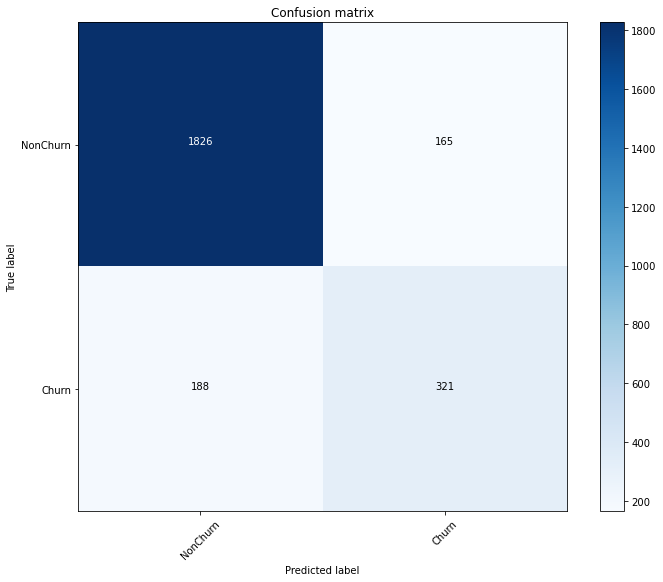

In [86]:
cnf_matrix_opt = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_opt, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()